# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [594]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [595]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [596]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [597]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [598]:
 # define your regions here
presel = {
        "mu": {
            "tagger>0.50": "THWW>0.5",
#             "msoftdrop": "fj_mass>40",
#             "met": "met_pt>20",
#             "lepmiso": "(lep_pt<55) | ( (lep_pt>55) & (lep_misolation<0.02))",
        },
        "ele": {
            "tagger>0.50": "THWW>0.5",
#             "fj_pt": "fj_pt>250",
#             "msoftdrop": "fj_mass>40",
#             "met": "met_pt>20",
#             "lepmiso": "(lep_pt<120) | ( (lep_pt>120) & (lep_misolation<0.02))",
        },
}

channels = ["ele", "mu"]
# channels = ["ele"]
samples = [
    "ggF", 
    "VBF",  
    "WH",
    "ZH",    
    "ttH",
    "QCD",
    "WJetsLNu",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",
    "DYJets",
    "WZQQ",
    # TODO: make sure it's WZQQ is NLO in next iteration
#     "WZQQorDYJets",    
    "Data",
]

years = ["2017", "2016", "2016APV", "2018"]
# years = ["2017", "2016", "2018"]

# years = ["2017"]

In [599]:
events_dict = {}

In [600]:
samples_dir = {
#     "2016":    "../eos/Feb9_2016",
#     "2016APV": "../eos/Feb9_2016APV",
#     "2017":    "../eos/Feb9_2017",    
#     "2018":    "../eos/Feb9_2018",
    
    # new jobs
    "2016":    "../eos/May31_hww_2016",
    "2016APV": "../eos/May31_hww_2016APV",
    "2017":    "../eos/May31_hww_2017",
    "2018":    "../eos/May31_hww_2018",
}

from make_stacked_hists import make_events_dict

events_dict = {}
for year in years:
    
    out = make_events_dict([year], channels, samples_dir[year], samples, presel)
    events_dict = {**events_dict, **out}

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:Applying tagger>0.50 selection on 1745 events
INFO:root:Will fill the VBF dataframe with the remaining 854 events
INFO:root:tot event weight 7.6048678973173125 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:Applying tagger>0.50 selection on 87 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1 events
INFO:root:tot event weight 1.6639318904239442 

INFO:root:Finding EWKWminus_WToLNu samples and should combine them under EWKvjets
INFO:root:Applying tagger>0.50 selection on 1953 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 127 events
INFO:root:tot event weight 38.74263155700244 

INFO:root:Finding EWKZ_ZToNuNu samples and should combine them under EWKvjets
INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:Applying tagger>0.50 selection on 40

INFO:root:Applying tagger>0.50 selection on 137227 events
INFO:root:Will fill the TTbar dataframe with the remaining 2822 events
INFO:root:tot event weight 97.38897248323246 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:Applying tagger>0.50 selection on 247 events
INFO:root:Will fill the QCD dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding EWKZ_ZToQQ samples and should combine them under EWKvjets
INFO:root:Applying tagger>0.50 selection on 88 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 3 events
INFO:root:tot event weight 0.09966589091019065 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:Applying tagger>0.50 selection on 73 events
INFO:root:Will fill the WZQQ dataframe with the remaining 1 events
INFO:root:tot event weight 0.45350642044630973 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:Applying tag

INFO:root:Finding EWKZ_ZToNuNu samples and should combine them under EWKvjets
INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:Applying tagger>0.50 selection on 5565 events
INFO:root:Will fill the WH dataframe with the remaining 2727 events
INFO:root:tot event weight 1.8656891445755954 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:Applying tagger>0.50 selection on 158739 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 13751 events
INFO:root:tot event weight 776.2600367463306 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:Applying tagger>0.50 selection on 412828 events
INFO:root:Will fill the TTbar dataframe with the remaining 12076 events
INFO:root:tot event weight 1406.0182186643206 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:Applying tagger>0.50 selection o

INFO:root:Applying tagger>0.50 selection on 129 events
INFO:root:Will fill the WZQQ dataframe with the remaining 1 events
INFO:root:tot event weight 0.425185533433758 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:Applying tagger>0.50 selection on 120 events
INFO:root:Will fill the Diboson dataframe with the remaining 11 events
INFO:root:tot event weight 2.686346077496206 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:Applying tagger>0.50 selection on 3464 events
INFO:root:Will fill the TTbar dataframe with the remaining 81 events
INFO:root:tot event weight 11.47612213802564 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:Applying tagger>0.50 selection on 2357 events
INFO:root:Will fill the QCD dataframe with the remaining 63 events
INFO:root:tot event weight 0.9347316702385785 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:Applying 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:Applying tagger>0.50 selection on 43264 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 2704 events
INFO:root:tot event weight 152.51758673087812 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:Applying tagger>0.50 selection on 357653 events
INFO:root:Will fill the TTbar dataframe with the remaining 9758 events
INFO:root:tot event weight 444.10789401490615 

INFO:root:Finding SingleElectron_Run2016G samples and should combine them under Data
INFO:root:Applying tagger>0.50 selection on 18103 events
INFO:root:Will fill the Data dataframe with the remaining 857 events
INFO:root:tot event weight 857.0 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:Applying tagger>0.50 selection on 10913 events
INFO:root:Will fill the SingleTop dataframe with the remaining 138 even

INFO:root:tot event weight 2.2382777272649927 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:Applying tagger>0.50 selection on 1663 events
INFO:root:Will fill the QCD dataframe with the remaining 56 events
INFO:root:tot event weight 118.82659093408648 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:Applying tagger>0.50 selection on 405 events
INFO:root:Will fill the WZQQ dataframe with the remaining 33 events
INFO:root:tot event weight 3.3037182379481824 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:Applying tagger>0.50 selection on 212 events
INFO:root:Will fill the WZQQ dataframe with the remaining 7 events
INFO:root:tot event weight 0.4797731420574371 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-400To650 samples and should combine them under DYJets
INFO:root:Applying tagger>0.50 selection on 112129 events
INFO:root:Will fill the DYJets dataframe wit

INFO:root:tot event weight 0.022461527357381817 

INFO:root:Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
INFO:root:Applying tagger>0.50 selection on 91268 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 5966 events
INFO:root:tot event weight 73.29637065870591 

INFO:root:Finding EWKZ_ZToLL samples and should combine them under EWKvjets
INFO:root:Applying tagger>0.50 selection on 168 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 11 events
INFO:root:tot event weight 3.0380730285745834 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:Applying tagger>0.50 selection on 5582 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 284 events
INFO:root:tot event weight 156.39884352372158 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:Applying tagger>0.50 selection on 1861 events
INFO:root:Will 

INFO:root:Finding QCD_Pt_170to300 samples and should combine them under QCD
INFO:root:Applying tagger>0.50 selection on 107 events
INFO:root:Will fill the QCD dataframe with the remaining 4 events
INFO:root:tot event weight 225.48336001640618 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
INFO:root:Applying tagger>0.50 selection on 47077 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 4232 events
INFO:root:tot event weight 494.37842081047296 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:Applying tagger>0.50 selection on 255 events
INFO:root:Will fill the WZQQ dataframe with the remaining 19 events
INFO:root:tot event weight 4.27496389236216 

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
INFO:root:Applying tagger>0.50 selection on 38503 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1386 events
INFO:root:tot ev

INFO:root:Will fill the QCD dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding SingleMuon_Run2016F_HIPM samples and should combine them under Data
INFO:root:Finding HWplusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:Applying tagger>0.50 selection on 1871 events
INFO:root:Will fill the WH dataframe with the remaining 750 events
INFO:root:tot event weight 0.913194431377892 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-100To250 samples and should combine them under DYJets
INFO:root:Applying tagger>0.50 selection on 29709 events
INFO:root:Will fill the DYJets dataframe with the remaining 867 events
INFO:root:tot event weight 39.74838113379472 

INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:Applying tagger>0.50 selection on 45 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 4 events
INFO:root:tot event weight 0.3617577329402102 

INFO:root:Finding ST_s-channel_4f_leptonDe

INFO:root:Will fill the ttH dataframe with the remaining 924 events
INFO:root:tot event weight 1.767643177312243 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:Applying tagger>0.50 selection on 172 events
INFO:root:Will fill the WZQQ dataframe with the remaining 5 events
INFO:root:tot event weight 0.3699031436622621 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:Applying tagger>0.50 selection on 1660 events
INFO:root:Will fill the QCD dataframe with the remaining 23 events
INFO:root:tot event weight 0.3278706774083205 

INFO:root:Finding EWKWplus_WToLNu samples and should combine them under EWKvjets
INFO:root:Applying tagger>0.50 selection on 875 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 42 events
INFO:root:tot event weight 13.808153779490498 

INFO:root:Finding GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8 samples and should combine them under ZH
INFO:root:Applying 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-100To250 samples and should combine them under DYJets
INFO:root:Applying tagger>0.50 selection on 19041 events
INFO:root:Will fill the DYJets dataframe with the remaining 981 events
INFO:root:tot event weight 41.33835375381449 

INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:Applying tagger>0.50 selection on 100 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 3 events
INFO:root:tot event weight 0.33752119026068317 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:Applying tagger>0.50 selection on 7282 events
INFO:root:Will fill the SingleTop dataframe with the remaining 145 events
INFO:root:tot event weight 0.5982306970722233 

INFO:root:Finding SingleElectron_Run2016F_HIPM samples and should combine them under Data
INFO:root:Finding DYJetsToLL_LHEFilterPtZ-50To100 samples and should combine them under DYJets
INFO:root:Applyi

INFO:root:tot event weight 0.9190782424050784 

INFO:root:Finding EWKWplus_WToLNu samples and should combine them under EWKvjets
INFO:root:Applying tagger>0.50 selection on 1029 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 99 events
INFO:root:tot event weight 32.44157784091633 

INFO:root:Finding GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8 samples and should combine them under ZH
INFO:root:Applying tagger>0.50 selection on 6612 events
INFO:root:Will fill the ZH dataframe with the remaining 3357 events
INFO:root:tot event weight 0.035796387770670984 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-0To50 samples and should combine them under DYJets
INFO:root:Applying tagger>0.50 selection on 360 events
INFO:root:Will fill the DYJets dataframe with the remaining 19 events
INFO:root:tot event weight 4.385256091972612 

INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:Applying tagger>0.50 selection on 28 events
INFO:root:W

INFO:root:tot event weight 0.867923983636822 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-50To100 samples and should combine them under DYJets
INFO:root:Applying tagger>0.50 selection on 3969 events
INFO:root:Will fill the DYJets dataframe with the remaining 288 events
INFO:root:tot event weight 62.318015997200874 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:Applying tagger>0.50 selection on 366 events
INFO:root:Will fill the QCD dataframe with the remaining 5 events
INFO:root:tot event weight 0.004530243308548613 

INFO:root:Finding SingleMuon_Run2018A samples and should combine them under Data
INFO:root:Finding WW samples and should combine them under Diboson
INFO:root:Applying tagger>0.50 selection on 595 events
INFO:root:Will fill the Diboson dataframe with the remaining 70 events
INFO:root:tot event weight 74.16132808198391 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-250To400 samples and should combine them under DYJets
INFO:root:Applyin

INFO:root:tot event weight 11.503453576300968 

INFO:root:Finding SingleMuon_Run2018D samples and should combine them under Data
INFO:root:Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
INFO:root:Applying tagger>0.50 selection on 46191 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3720 events
INFO:root:tot event weight 1858.5412726705074 

INFO:root:Finding QCD_Pt_470to600 samples and should combine them under QCD
INFO:root:Applying tagger>0.50 selection on 515 events
INFO:root:Will fill the QCD dataframe with the remaining 16 events
INFO:root:tot event weight 38.185601320294104 

INFO:root:Finding HZJ_HToWW_M-125 samples and should combine them under ZH
INFO:root:Applying tagger>0.50 selection on 9318 events
INFO:root:Will fill the ZH dataframe with the remaining 3847 events
INFO:root:tot event weight 2.5978015630275664 

INFO:root:Finding WZ samples and should combine them under Diboson
INFO:root:Applying tagger>0.50 selection on 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-250To400 samples and should combine them under DYJets
INFO:root:Applying tagger>0.50 selection on 165761 events
INFO:root:Will fill the DYJets dataframe with the remaining 3724 events
INFO:root:tot event weight 32.579453294983225 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:Applying tagger>0.50 selection on 19319 events
INFO:root:Will fill the SingleTop dataframe with the remaining 303 events
INFO:root:tot event weight 10.683486404998279 

INFO:root:Finding TTTo2L2Nu samples and should combine them under TTbar
INFO:root:Applying tagger>0.50 selection on 109129 events
INFO:root:Will fill the TTbar dataframe with the remaining 2304 events
INFO:root:tot event weight 117.36269149448287 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:Applying tagger>0.50 selection on 323 events
INFO:root:Will fill the QCD dataframe with the remaining 7 

INFO:root:Applying tagger>0.50 selection on 1200 events
INFO:root:Will fill the QCD dataframe with the remaining 26 events
INFO:root:tot event weight 0.09109393347380516 

INFO:root:Finding SingleMuon_Run2018B samples and should combine them under Data
INFO:root:Applying tagger>0.50 selection on 20087 events
INFO:root:Will fill the Data dataframe with the remaining 1087 events
INFO:root:tot event weight 1087.0 



In [601]:
for year in years:
    # electron channel
    df = pd.read_parquet(f"{samples_dir[year]}/fake_{year}_ele.parquet")
    for selection in presel["ele"]:
        df = df.query(presel["ele"][selection])

    events_dict[year]["ele"]["Fake"] = df
    
    # muon channel
    events_dict[year]["mu"]["Fake"] = 0

In [280]:
# # for LP
# for ch in channels:
#     out = make_events_dict(["2017"], channels, "../eos/May23_LP_2017", ["TTbar"], presel)
#     for selection in presel[ch]:
#         df = df.query(presel[ch][selection])

#     events_dict["2017"][ch]["TTbar_LP"] = df

In [287]:
def get_soverb(ev, presel, categories_sel, years, channels, precision=0, usefake=False):

    mass_window = [50, 150]

    num_sig = {
        "ggF": 0,
        "VBF": 0,
        "WH": 0,
        "ZH": 0,
        "ttH": 0,
    }
    
    samples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",
        "WJetsLNu",
        "TTbar",
        "SingleTop",
        "Diboson",
        "EWKvjets",
        "WZQQ",
        "DYJets",        
        "Data",
    ]

    
    if usefake:
        samples += ["Fake"]
        
        dominant_backgrounds = ["WJetsLNu", "TTbar", "Fake", "DYJets"]        
        
        num_bkg = {
            "WJetsLNu": 0, 
            "TTbar": 0, 
            "Fake": 0,
            "DYJets": 0,
            "Others": 0,
        }
    else:
        samples += ["QCD"]        
        
        dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]
        
        num_bkg = {
            "WJetsLNu": 0, 
            "TTbar": 0, 
            "QCD": 0,
            "DYJets": 0,
            "Others": 0,
        }

    deno_sig, deno_bkg = 0, 0
    s, b = 0, 0

    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                df = ev[year][ch][sample]                    

                if (ch == "mu") and (sample=="Fake"):
                        continue

                for region, sel in presel.items():
                    df = df.query(sel)

                for category, category_sel in categories_sel.items():
                    df = df.query(category_sel)

                ######################## composition start
                if sample in utils.signals:

                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()

                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()     
                ######################## composition end

                ######################## soverb start
                df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                if sample in utils.signals:                
                    s += df["event_weight"].sum()
                else:
                    b += df["event_weight"].sum()
                ######################## soverb end

    num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1], reverse=True))
    num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1], reverse=True))

    if len(years) == 4:
        lab = "RUN2"
    else:
        lab = "_".join(years)

    print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
    if len(list(categories_sel.items()))!=0:
        print("Category:", list(categories_sel.keys())[0])

    print("------------------------")

    if "SR" in list(presel.keys())[0]:
        print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
        print("------------------------")

    print(f"Signal: {deno_sig:.2f}")
    for sample in num_sig:
        print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")

    print("------------------------")
    print(f"Background: {deno_bkg:.2f}")
    for sample in num_bkg:
        if sample=="":
            if precision == 0:
                print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
            elif precision == 1:
                print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.1f}%")                
            elif precision == 2:
                print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.2f}%")
        else:
            if precision == 0:
                print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
            elif precision == 1:
                print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.1f}%")
            elif precision == 2:
                print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.2f}%")

In [288]:
presel = {
    "SR": "THWW>0.5",
}
categories_sel = {}
get_soverb(events_dict, presel, categories_sel, years, channels, usefake=True)

SR (RUN2):
------------------------
s/sqrt(b) in [50,150]: 1.54
------------------------
Signal: 303.66
- ggF: 55%
- VBF: 20%
- ttH: 10%
- WH: 10%
- ZH: 5%
------------------------
Background: 37796.58
- WJetsLNu: 64%
- TTbar: 25%
- Others: 6%
- DYJets: 4%
- Fake: 2%


In [542]:
def make_composition_table(ev, presel, add_soverb=False, use_Fake=False):

    from collections import OrderedDict
    
    all_MCsamples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",        
        "WJetsLNu",
        "TTbar",
        "SingleTop",
        "Diboson",
        "EWKvjets",
        "DYJets",
        "WZQQ",
    ]
    if use_Fake:    
        all_MCsamples += ["Fake"]
        bkg = ["TTbar", "WJetsLNu", "Fake", "Others"]        
    else:
        all_MCsamples += ["QCD"]
        bkg = ["TTbar", "WJetsLNu", "QCD", "Others"]        
    
    sig = ["VBF", "ggF", "WH", "ZH", "ttH"]

    mass_window = [50, 150]
    
    # make table
    print("\\begin{table}[!ht]")
    print("\\begin{center}")
    
    if add_soverb:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset. The last column includes $s/\sqrt{b}$ in a mass window of 100-150\GeV in the mass observable (the Higgs reconstructed mass).}")
    else:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset.}")
        
    if add_soverb:
        print("\\begin{tabular}{c|ccccc|cccc|c}")
    else:
        print("\\begin{tabular}{c|ccccc|cccc}")

    if add_soverb:    
        print("& \\multicolumn{5}{c|}{Signal yield} & \\multicolumn{4}{c|}{Background yield} & \\multicolumn{1}{c}{$s/\sqrt{b}$} \\\\\n")
        if use_Fake:
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & Fake & Other & \\\\\n")
        else:
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & QCD & Other & \\\\\n")
    else:
        print("& \\multicolumn{5}{c|}{Signal yield} & \\multicolumn{4}{c}{Background yield} \\\\\n")
        if use_Fake:        
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & Fake & Other \\\\\n")
        else:
            print("& VBF & ggF & WH & ZH & \\ttH & \\ttbar & W$+$jets & QCD & Other \\\\\n")
            
    print("\\hline")
    print("\\hline")

    for region, sel in presel.items():

        sig_dict = OrderedDict({
            "VBF": 0,
            "ggF": 0,
            "WH": 0,
            "ZH": 0,
            "ttH": 0,            
        })

        if use_Fake:            
            bkg_dict = OrderedDict({
                "TTbar": 0,
                "WJetsLNu": 0, 
                "Fake": 0,
                "Others": 0,    
            })
        else:
            bkg_dict = OrderedDict({
                "TTbar": 0,
                "WJetsLNu": 0, 
                "QCD": 0,
                "Others": 0,    
            })            

        tot_sig, tot_bkg = 0, 0
        s, b = 0, 0   # in mass window [100, 150]
        for year in years:
            for ch in channels:
                for sample in all_MCsamples:
                    
                    df = ev[year][ch][sample]
                    
                    if (ch == "mu") and (sample=="Fake"):
                        continue

                    df = df.query(sel)  

                    if sample in sig_dict:
                        tot_sig += df["event_weight"].sum()                    
                        sig_dict[sample] += df["event_weight"].sum()
                    elif sample in bkg_dict:
                        tot_bkg += df["event_weight"].sum()
                        bkg_dict[sample] += df["event_weight"].sum()
                    else:
                        tot_bkg += df["event_weight"].sum()                        
                        bkg_dict["Others"] += df["event_weight"].sum()                    

                    ######################## soverb start
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                    if sample in sig_dict:                
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()
                    ######################## soverb end

        texdata = "\multirow{2}{*}{" + region + "} & \multicolumn{5}{c|}{"
        texdata += str(round(tot_sig))
        
        if add_soverb:
            texdata += "} & \multicolumn{4}{c|}{"
            texdata += str(round(tot_bkg))
            texdata += "} & \multicolumn{1}{c}{"            
#             texdata += str(round(s/(b**0.5),3))
            texdata += "\multirow{2}{*}{" + str(round(s/(b**0.5),3)) + "}"
            
            texdata += "} \\\\\n"
        else:
            texdata += "} & \multicolumn{4}{c}{"
            texdata += str(round(tot_bkg))
            texdata += "} \\\\\n"
        
#         texdata += "\\cline{2-9} \n"
        
        for sample in sig_dict:
            texdata += f" & {(100*sig_dict[sample]/tot_sig):.0f}\%"
        for sample in bkg_dict:
            if bkg_dict[sample]<0:
                bkg_dict[sample]=0
            texdata += f" & {(100*bkg_dict[sample]/tot_bkg):.0f}\%"
        
        if add_soverb:
            texdata += " & "

        texdata += " \\\\\n"
        print(texdata)
        print("\\hline")

    print("\\hline")
    print("\\end{tabular}")
    print("\\label{region}")
    print("\\end{center}")
    print("\\end{table}")      

In [548]:
presel = {
#     "Pre-selection": f"THWW>0.5", # dummy
    
#     "Signal region": f"(THWW>0.92) & (n_bjets_T==0)",    
#     "Top control region": f"(THWW>0.5) & (n_bjets_T>0)",
#     "W+Jets control region": f"(THWW<0.92) & (THWW>0.50) & (n_bjets_T==0)",

    "VBF category": "(THWW>0.905 & n_bjets_T==0) & (mjj>1000) & (deta>3.5)",    
    "ggF category $p_T \in [250, 300]$": "(THWW>0.93 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>250) & (fj_pt<300)",
    "ggF category $p_T \in [300, 450]$": "(THWW>0.93 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>300) & (fj_pt<450)",
    "ggF category $p_T \in [450, \\mathrm{Inf}]$": "(THWW>0.93 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>450)",
    
#     "W+Jets control region (w/o MET cut)": f"(THWW<0.925) & (THWW>0.80) & (n_bjets_T==0)",
#     "W+Jets control region (MET$>$50\GeV)": f"(THWW<0.97) & (THWW>0.50) & (n_bjets_T==0) & (met_pt>50)",
#     "W+Jets control region (MET$>$100\GeV)": f"(THWW<0.97) & (THWW>0.50) & (n_bjets_T==0) & (met_pt>100)",
#     "W+Jets control region (MET$>$150\GeV)": f"(THWW<0.97) & (THWW>0.50) & (n_bjets_T==0) & (met_pt>150)",
#     "W+Jets control region (MET$>$200\GeV)": f"(THWW<0.97) & (THWW>0.50) & (n_bjets_T==0) & (met_pt>200)",
#     "THWW>0": f"THWW>0",
#     "THWW>0.1": f"THWW>0.1",
#     "THWW>0.3": f"THWW>0.3",
#     "THWW>0.5": f"THWW>0.5",
#     "THWW>0.7": f"THWW>0.7",
#     "THWW>0.9": f"THWW>0.9",
    
#     "SR": "(THWW>0.92 & n_bjets_T==0)",
#     "SR + (VH VScore$<$0.999)": "(THWW>0.92 & n_bjets_T==0) & VH_fj_VScore<0.999",
#     "SR + (VH VScore$<$0.995)": "(THWW>0.92 & n_bjets_T==0) & VH_fj_VScore<0.995",    
#     "SR + (VH VScore$<$0.99)": "(THWW>0.92 & n_bjets_T==0) & VH_fj_VScore<0.99",
#     "SR + (VH VScore$<$0.95)": "(THWW>0.92 & n_bjets_T==0) & VH_fj_VScore<0.95",
#     "SR + (VH VScore$<$0.90)": "(THWW>0.92 & n_bjets_T==0) & VH_fj_VScore<0.9",
}

make_composition_table(events_dict, presel, add_soverb=True, use_Fake=True)

\begin{table}[!ht]
\begin{center}
\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset. The last column includes $s/\sqrt{b}$ in a mass window of 100-150\GeV in the mass observable (the Higgs reconstructed mass).}
\begin{tabular}{c|ccccc|cccc|c}
& \multicolumn{5}{c|}{Signal yield} & \multicolumn{4}{c|}{Background yield} & \multicolumn{1}{c}{$s/\sqrt{b}$} \\

& VBF & ggF & WH & ZH & \ttH & \ttbar & W$+$jets & Fake & Other & \\

\hline
\hline
\multirow{2}{*}{VBF category} & \multicolumn{5}{c|}{13} & \multicolumn{4}{c|}{76} & \multicolumn{1}{c}{\multirow{2}{*}{1.746}} \\
 & 76\% & 21\% & 2\% & 1\% & 0\% & 29\% & 52\% & 1\% & 19\% &  \\

\hline
\multirow{2}{*}{ggF category $p_T \in [250, 300]$} & \multicolumn{5}{c|}{16} & \multicolumn{4}{c|}{318} & \multicolumn{1}{c}{\multirow{2}{*}{1.014}} \\
 & 18\% & 65\% & 10\% & 5\% & 3\% & 24\% & 48\% & 0\% & 28\% &  \\

\hline
\multirow{2}{*}{ggF category $p_T \in [300, 450]$} & \multicolumn{5}{c

In [243]:
def make_composition_table_sig(ev, presel):

    from collections import OrderedDict

    all_MCsamples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH", 
        "HTauTau"
    ]

    sig = ["VBF", "ggF"]         
    bkg = ["ttH", "WH", "ZH", "HTauTau"]

    mass_window = [50, 150]
    
    # make table
    print("\\begin{table}[!ht]")
    print("\\begin{center}")
    
    print("\\caption{Event yield contribution from different Higgs processes at pre-selection level and in the signal-like region, defined by a high tagger score, for the full Run2 dataset. The contribution of H(tau-tau) decays is negligible in both regions.}")
            
    print("\\begin{tabular}{c|cc|cccc}")

    print("& \\multicolumn{2}{c|}{Higgs Signal yields} & \\multicolumn{4}{c}{Higgs Background yields} \\\\\n")
    print("& VBF & ggF & \\ttH & WH & ZH & HTauTau \\\\\n")        
    print("\\hline")
    print("\\hline")

    for region, sel in presel.items():

        sig_dict = OrderedDict({
            "VBF": 0,
            "ggF": 0,             
        })

        bkg_dict = OrderedDict({
            "ttH": 0,
            "WH": 0, 
            "ZH": 0,
            "HTauTau": 0,
        })

        tot_sig, tot_bkg = 0, 0
        s, b = 0, 0   # in mass window [100, 150]
        for year in years:
            for ch in channels:
                for sample in all_MCsamples:

                    try:
                        df = ev[year][ch][sample]
                    except:
                        continue

                    df = df.query(sel)  

                    if sample in sig_dict:
                        tot_sig += df["event_weight"].sum()                    
                        sig_dict[sample] += df["event_weight"].sum()
                    elif sample in bkg_dict:
                        tot_bkg += df["event_weight"].sum()
                        bkg_dict[sample] += df["event_weight"].sum()
                    else:
                        tot_bkg += df["event_weight"].sum()                        
                        bkg_dict["Others"] += df["event_weight"].sum()                    

                    ######################## soverb start
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                    if sample in sig_dict:                
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()
                    ######################## soverb end


        texdata = region
        for sample in sig_dict:
            texdata += f" & {(sig_dict[sample]):.0f}"
        for sample in bkg_dict:
            texdata += f" & {(bkg_dict[sample]):.0f}"
        
        texdata += " \\\\\n"
        print(texdata)
        print("\\hline")

    print("\\hline")
    print("\\end{tabular}")
    print("\\label{region}")
    print("\\end{center}")
    print("\\end{table}")

In [244]:
presel = {
    "Pre-selection": f"THWW>0", # dummy

#     "SR using pt flatten: score> 85": f"({tagger}>0.91) & (n_bjets_T==0)",
    r"$T_{HWW}^{\ell\nu qq} > 0.92$": f"{tagger}>0.92",

#     "Signal region": f"(THWW>0.98) & (n_bjets_T==0)",    
#     "Top control region": f"(THWW>0.5) & (n_bjets_T>0)",
#     "W+Jets control region": f"(THWW<0.97) & (fj_ParT_score_finetuned>0.50) & (n_bjets_T==0) & (met_pt>100)",

#     "VBF category": "(THWW>0.925 & n_bjets_T==0) & (mjj>1000) & (deta>3.5)",    
#     "ggF category $p_T \in [250, 300]$": "(THWW>0.95 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>250) & (fj_pt<300)",
#     "ggF category $p_T \in [300, 450]$": "(THWW>0.95 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>300) & (fj_pt<450)",
#     "ggF category $p_T \in [450, \\mathrm{Inf}]$": "(THWW>0.95 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>450)",
    
}

make_composition_table_sig(events_dict, presel)

\begin{table}[!ht]
\begin{center}
\caption{Event yield contribution from different Higgs processes at pre-selection level and in the signal-like region, defined by a high tagger score, for the full Run2 dataset. The contribution of H(tau-tau) decays is negligible in both regions.}
\begin{tabular}{c|cc|cccc}
& \multicolumn{2}{c|}{Higgs Signal yields} & \multicolumn{4}{c}{Higgs Background yields} \\

& VBF & ggF & \ttH & WH & ZH & HTauTau \\

\hline
\hline
Pre-selection & 61 & 167 & 31 & 29 & 16 & 0 \\

\hline
$T_{HWW}^{\ell\nu qq} > 0.92$ & 18 & 44 & 5 & 7 & 4 & 0 \\

\hline
\hline
\end{tabular}
\label{region}
\end{center}
\end{table}


# Stacked hists

In [297]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = (0, 0)

In [605]:
vars_to_plot = [
    
    ############# AN start
    "FirstFatjet_pt",
    "fj_lsf3",
    "fj_mass",
    "fj_ParT_mass",
    "fj_pt",
    "ht",    
    "lep_fj_dr",    
    "lep_isolation_ele",
    "lep_isolation_ele_highpt",
    "lep_isolation_ele_lowpt",
    "lep_isolation_mu",
    "lep_isolation_mu_highpt",
    "lep_isolation_mu_lowpt",
    "lep_isolation",
    "lep_met_mt",
    "lep_misolation_ele",
    "lep_misolation_ele_highpt",
    "lep_misolation_ele_lowpt",    
    "lep_misolation_mu",
    "lep_misolation_mu_highpt",
    "lep_misolation_mu_lowpt",
    "lep_misolation",
    "lep_pt",
    "met_fj_dphi",
    "met_pt",
    "NumFatjets",
    "NumOtherJets",
    "rec_higgs_m",    
    "rec_W_lnu_m",
    "rec_W_qq_m",
    "SecondFatjet_pt",
    "THWW",
    ############## AN end
    
    ############## Fake vs QCD
#     "FirstFatjet_pt",
#     "fj_pt",
#     "lep_fj_dr",    
#     "lep_pt",
#     "met_pt",
#     "SecondFatjet_pt",
#     "rec_higgs_m",
#     "THWW",

    ############## Control regions
#     "fj_pt",
#     "lep_pt",
#     "lep_fj_dr",
#     "rec_higgs_m",
]

samples_to_plot = [
    "ggF", 
    "VBF",
    "ttH",
    "WH",
    "ZH",
    
#     "QCD",
    "Fake",

    "SingleTop",
    "Diboson",
    "EWKvjets",

    "Data",

    "WJetsLNu",
#     "WJetsLNu_unmatched",
#     "WJetsLNu_matched",    
    
    "DYJets",
    "WZQQ",
#     "WZQQorDYJets",  
    
    "TTbar",
#     "TTbar_LP",
    
#     "TTbar_allmatched",
#     "TTbar_unmatched",
]

# samples_to_plot = ["QCD"]

In [614]:
tagger = "THWW"
# tagger = "fj_ParT_score"

WP1 = 0.5
# tagger_cut = 0.9   # VBF
# tagger_cut = 0.95  # ggF
WP2 = 0.93

WP_VBF = 0.91

presel = {
    "Pre-selection": f"({tagger}>0.5)",   # dummy    
#     "Pre-selection": f"({tagger}>{WP1})",   # dummy
    
#     "SR": f"{tagger}>0.9 & (n_bjets_T==0)",
#     "Top CR": f"({tagger}>0.5) & (n_bjets_T>0)",
#     "WJets CR": f"({tagger}<{WP2}) & ({tagger}>{WP1}) & (n_bjets_T==0)",
}

categories_sel = {
#     "VBF": f"( ({tagger}>{WP_VBF}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
#     "ggF": "(mjj<1000) | (deta<3.5)",
        
#     r"ggF pT [250, 300]": f"( ({tagger}>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>250) & (fj_pt<300) )",
#     f"ggF pT [300, 450]": f"( ({tagger}>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>300) & (fj_pt<450) )",
#     r"ggF pT [450, Inf]": f"( ({tagger}>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>450) )",
}

channels = ["ele", "mu"]
# channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]
years = ["2016APV"]

num, den = 0, 0
threshold = 0

# fill histograms
hists = {}

import utils

massbin = 5
for var in vars_to_plot:

    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(55, 255, massbin)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),            
        )       
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utils.axis_dict[var],
            storage=hist2.storage.Weight(),            
        )        
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
                if ch=="mu":
                    if sample=="Fake":
                        continue
                region, sel = list(presel.items())[0]

#                 if "TTbar" in sample:
#                     df = ev[year][ch]["TTbar"]
                    
#                     if "TTbar_allmatched" in sample:
#                         df = df[df["fj_isTop_W_lep_b"]==1]                        
#                     else:
#                         df = df[df["fj_isTop_W_lep_b"]!=1]                        
                
#                 else:
#                 df = events_dict[year][ch][sample]

#                 if "WJetsLNu" in sample:
#                     df = events_dict[year][ch]["WJetsLNu"]
                    
#                     if "unmatched" in sample:
#                         df = df[df["fj_V_isMatched"]!=1]
#                     else:
#                         df = df[df["fj_V_isMatched"]==1]
                
#                 else:
                df = events_dict[year][ch][sample]
        
                
                df = df.query(sel)
                                     
                if len(categories_sel)>=1:
                    category, category_sel = list(categories_sel.items())[0]
                    df = df.query(category_sel)
            
                if sample == "EWKvjets":
                    threshold = 20
                    den += len(df['event_weight'])
                    num += sum(df["event_weight"]>threshold)

                    avg_good_weight = df["event_weight"][df["event_weight"]<threshold].mean()

                    df["event_weight"][df["event_weight"]>threshold] = avg_good_weight
                    

                if "lep_isolation_ele" in var:
                    if ch=="ele":
                        
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>120)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<120)]                            

                        x = df["lep_isolation"]
                    else:
                        continue
                        
                elif "lep_isolation_mu" in var:
                    if ch=="mu":
                        
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>55)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<55)] 

                        x = df["lep_isolation"]

                    else:
                        continue
                    
                elif "lep_misolation" in var:
                    if ch == "mu":
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>55)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<55)] 

                    else:
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>120)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<120)] 

                    x = df["lep_misolation"]

                else:
                    x = df[var]
                
                w = df["event_weight"]
                
#                 if sample != "Data":
# #                     w *= df["btag_1a"]
#                     w *= df["0btag_1b"]
# #                     w *= df["1pbtag_1b"]

#                 if sample == "TTbar_allmatched":
# #                     w *= 0.915 # at WP=0.924
#                     w *= 0.958 # at WP=0.5

                hists[var].fill(
                    samples=sample,
                    var=x,
                    weight=w,
                )     
try:
    print(f"Removing {num} out of {den} EWKvjets events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1
    
for var in vars_to_plot:
    fix_neg_yields(hists[var])

Removing 0 out of 10784 EWKvjets events by applying event_weight<20 (0.00%)
Fake, has 3 bins with negative yield.. will set them to 0
Fake, has 5 bins with negative yield.. will set them to 0
DYJets, has 9 bins with negative yield.. will set them to 0
Fake, has 4 bins with negative yield.. will set them to 0
DYJets, has 2 bins with negative yield.. will set them to 0
Fake, has 5 bins with negative yield.. will set them to 0
DYJets, has 1 bins with negative yield.. will set them to 0
Fake, has 6 bins with negative yield.. will set them to 0
Fake, has 5 bins with negative yield.. will set them to 0
DYJets, has 1 bins with negative yield.. will set them to 0
Fake, has 3 bins with negative yield.. will set them to 0
DYJets, has 1 bins with negative yield.. will set them to 0
DYJets, has 5 bins with negative yield.. will set them to 0
DYJets, has 5 bins with negative yield.. will set them to 0
ttH, has 1 bins with negative yield.. will set them to 0
Fake, has 7 bins with negative yield.. wi

Will plot FirstFatjet_pt histogram
Will plot fj_lsf3 histogram
Will plot fj_mass histogram
Will plot fj_ParT_mass histogram
Will plot fj_pt histogram
Will plot ht histogram
Will plot lep_fj_dr histogram
Will plot lep_isolation_ele histogram
Will plot lep_isolation_ele_highpt histogram
Will plot lep_isolation_ele_lowpt histogram
Will plot lep_isolation_mu histogram
Will plot lep_isolation_mu_highpt histogram
Will plot lep_isolation_mu_lowpt histogram
Will plot lep_isolation histogram
Will plot lep_met_mt histogram
Will plot lep_misolation_ele histogram
Will plot lep_misolation_ele_highpt histogram
Will plot lep_misolation_ele_lowpt histogram
Will plot lep_misolation_mu histogram
Will plot lep_misolation_mu_highpt histogram
Will plot lep_misolation_mu_lowpt histogram


../python/utils.py:634: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax, rax, sax, dax) = plt.subplots(


Will plot lep_misolation histogram
Will plot lep_pt histogram
Will plot met_fj_dphi histogram
Will plot met_pt histogram
Will plot NumFatjets histogram
Will plot NumOtherJets histogram
Will plot rec_higgs_m histogram
Will plot rec_W_lnu_m histogram
Will plot rec_W_qq_m histogram
Will plot SecondFatjet_pt histogram
Will plot THWW histogram
Pre-selection (2016APV):
------------------------
Signal: 38.90
- ggF: 54%
- VBF: 20%
- ttH: 11%
- WH: 10%
- ZH: 5%
------------------------
Background: 4885.62
- WJetsLNu: 62.3%
- TTbar: 26.5%
- Others: 5.9%
- DYJets: 3.0%
- Fake: 2.2%


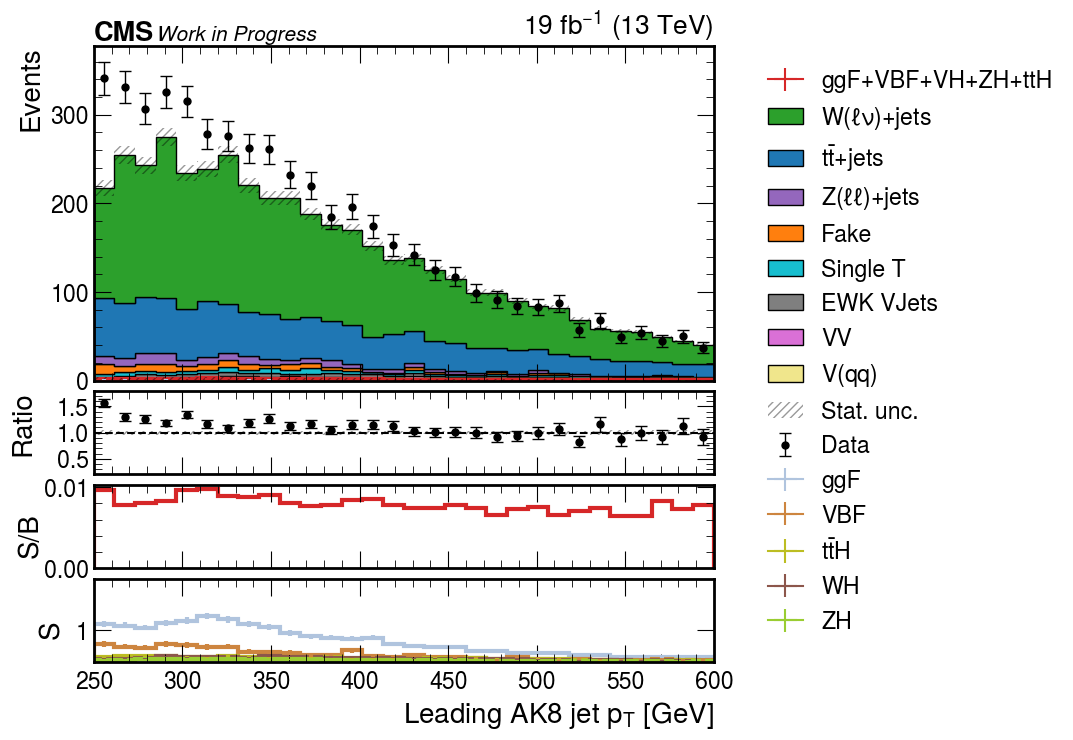

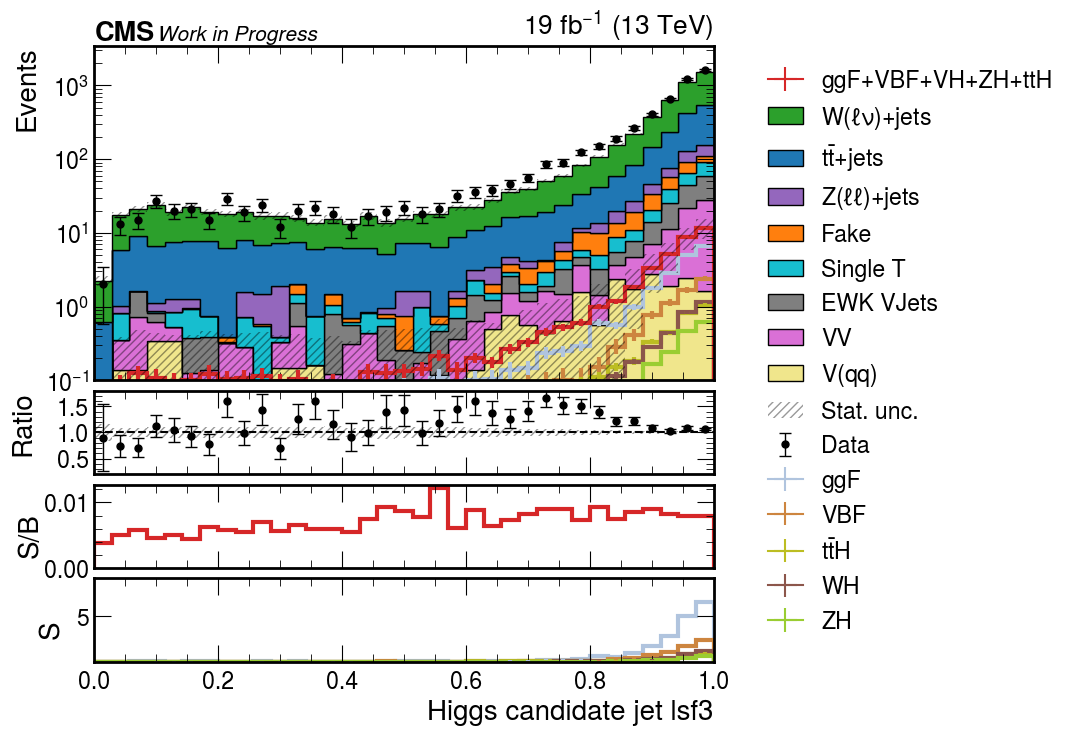

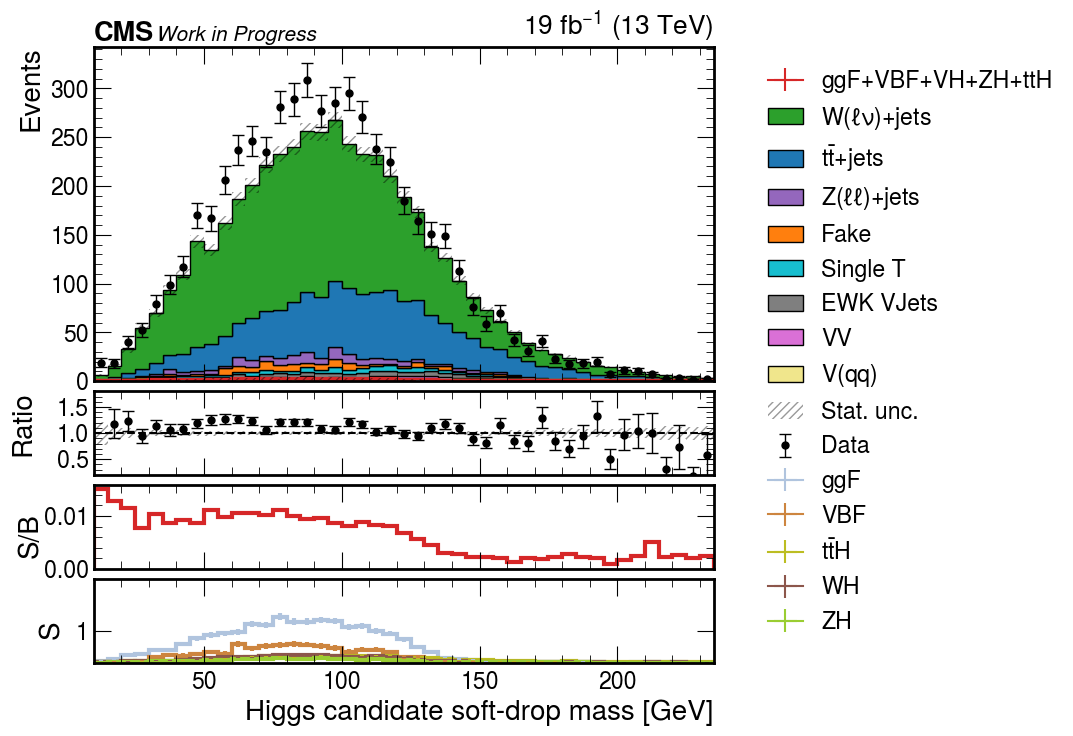

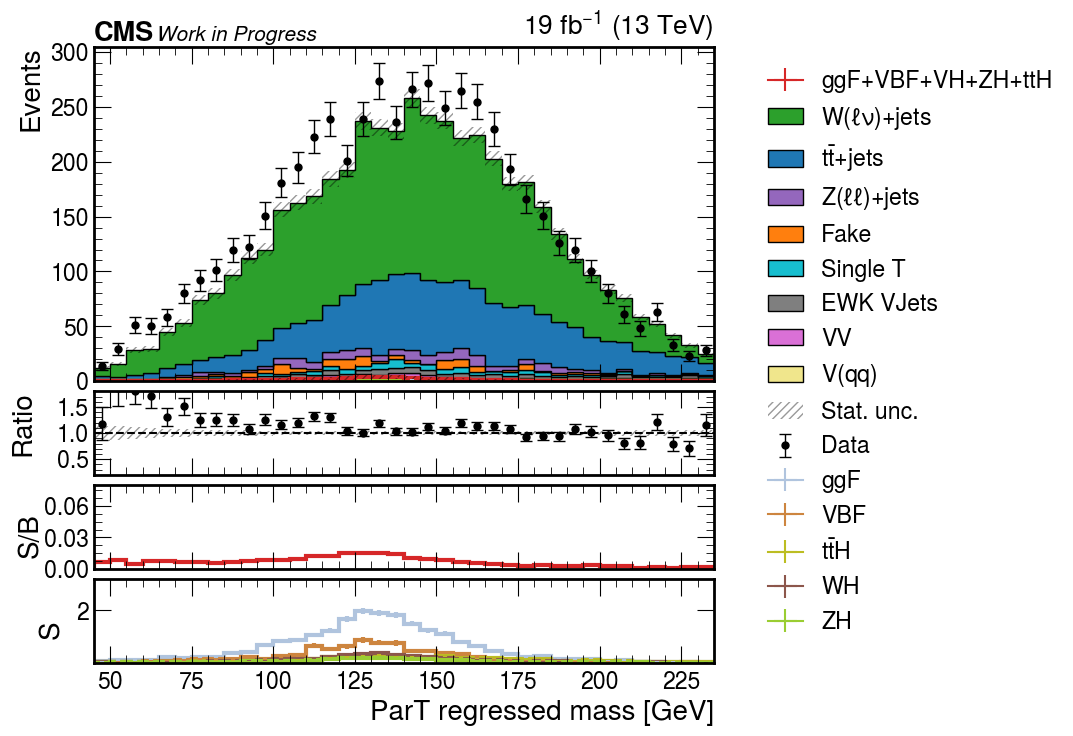

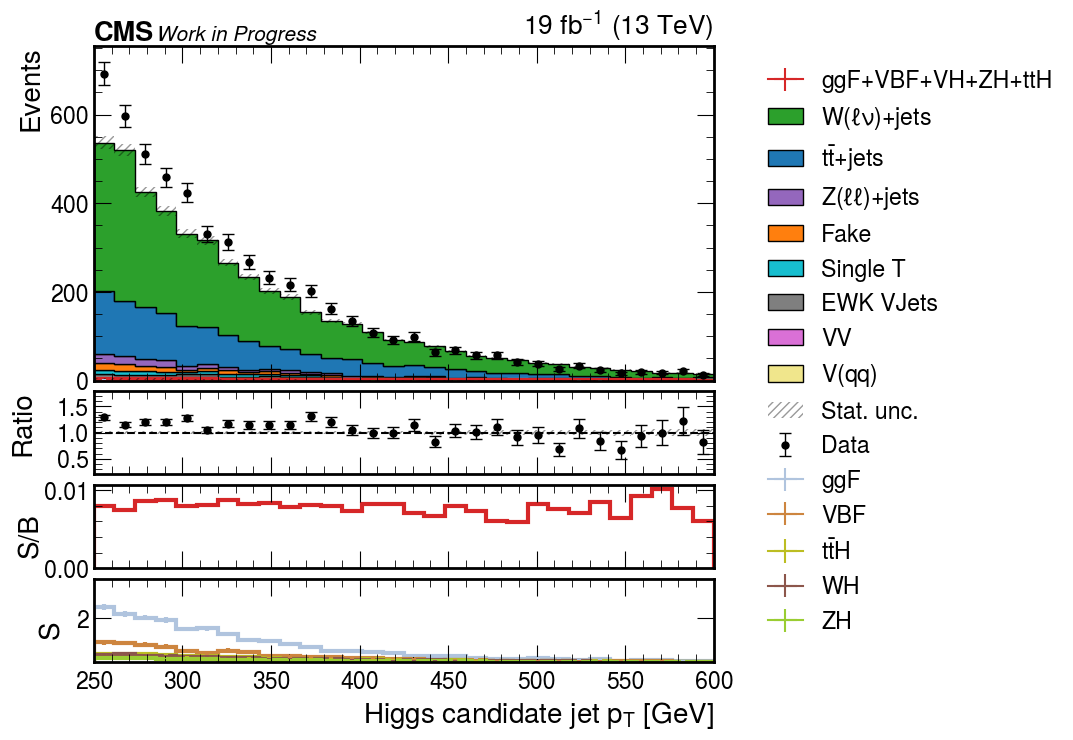

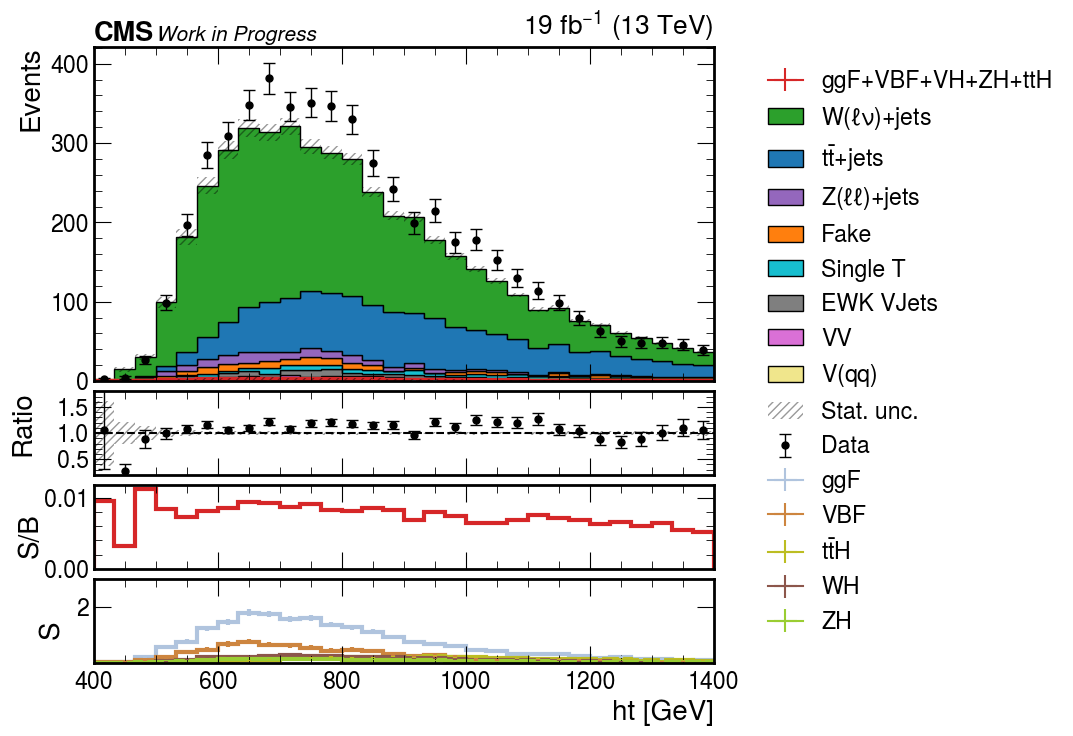

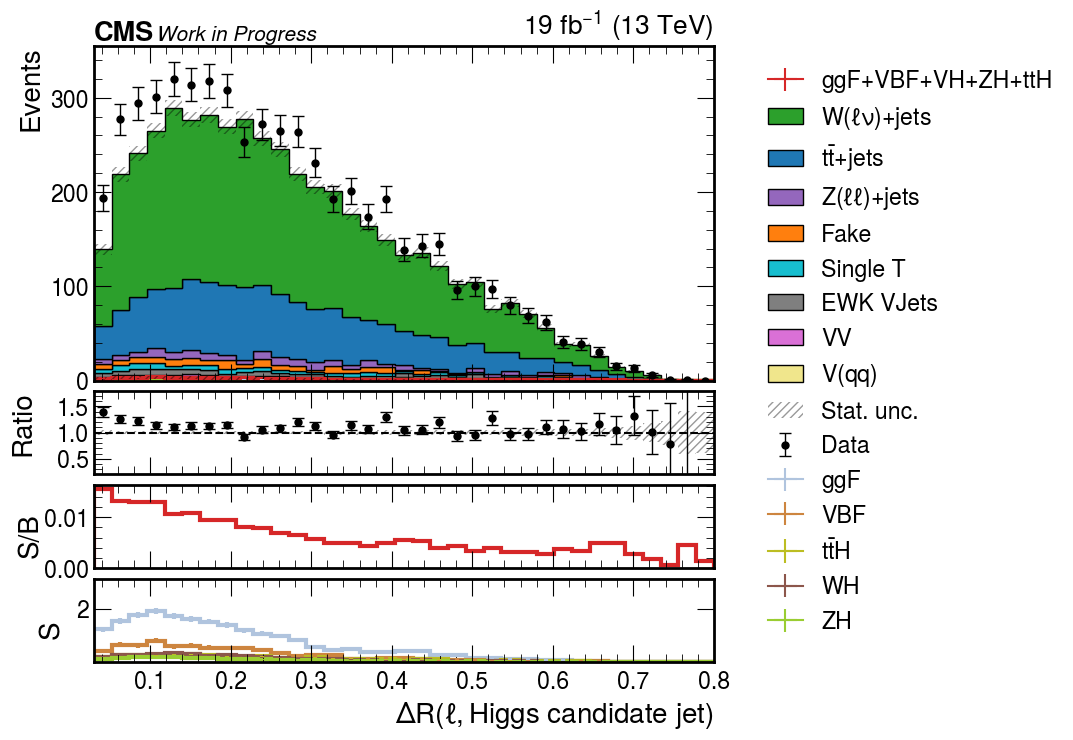

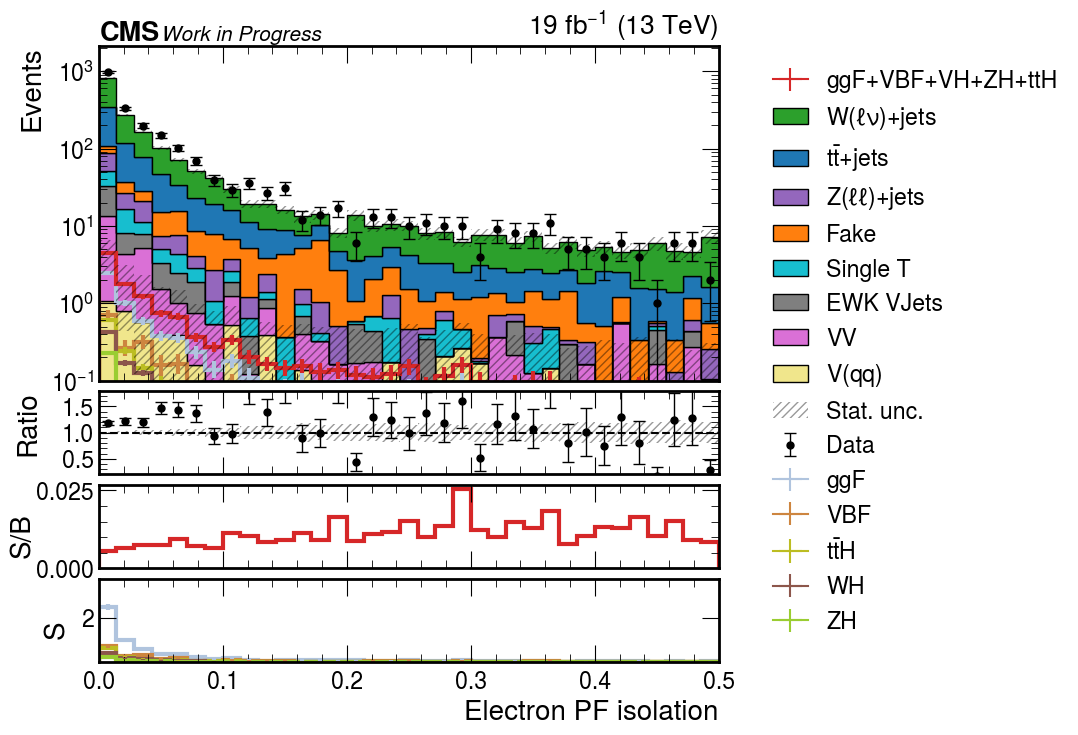

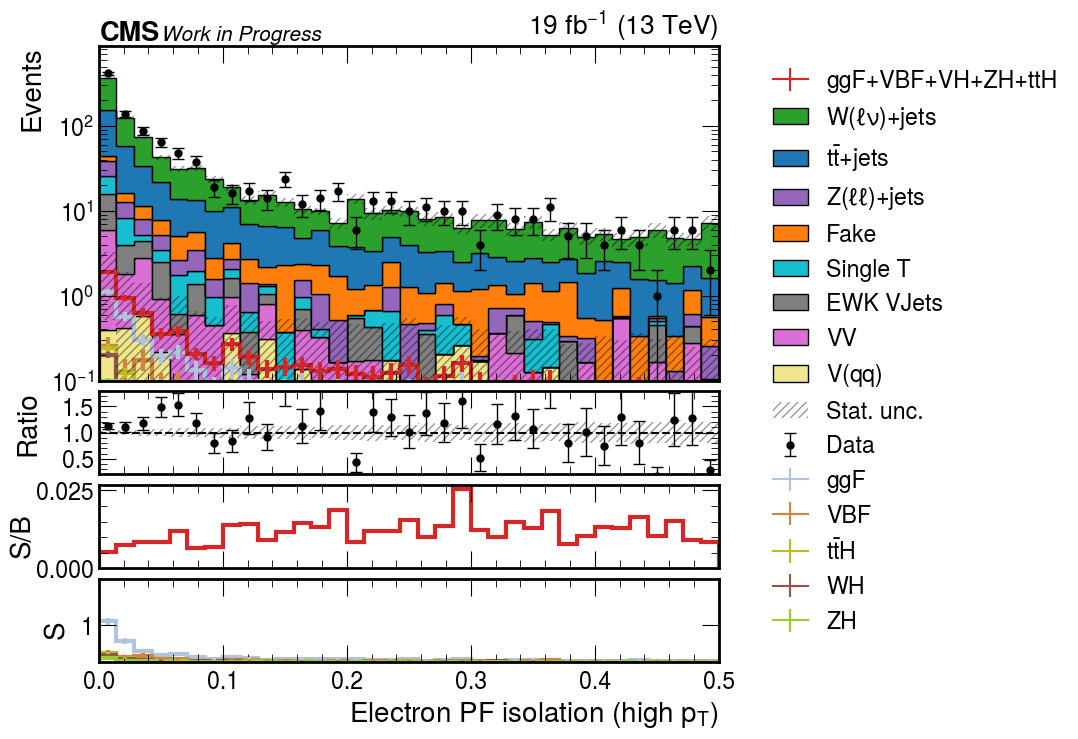

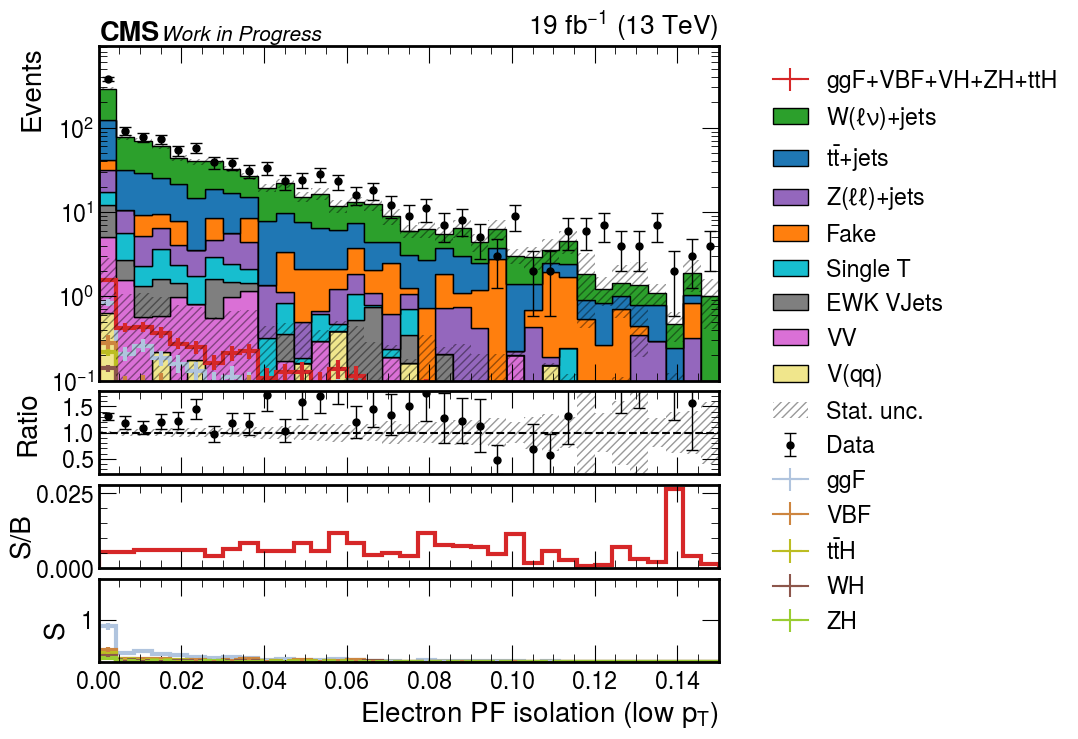

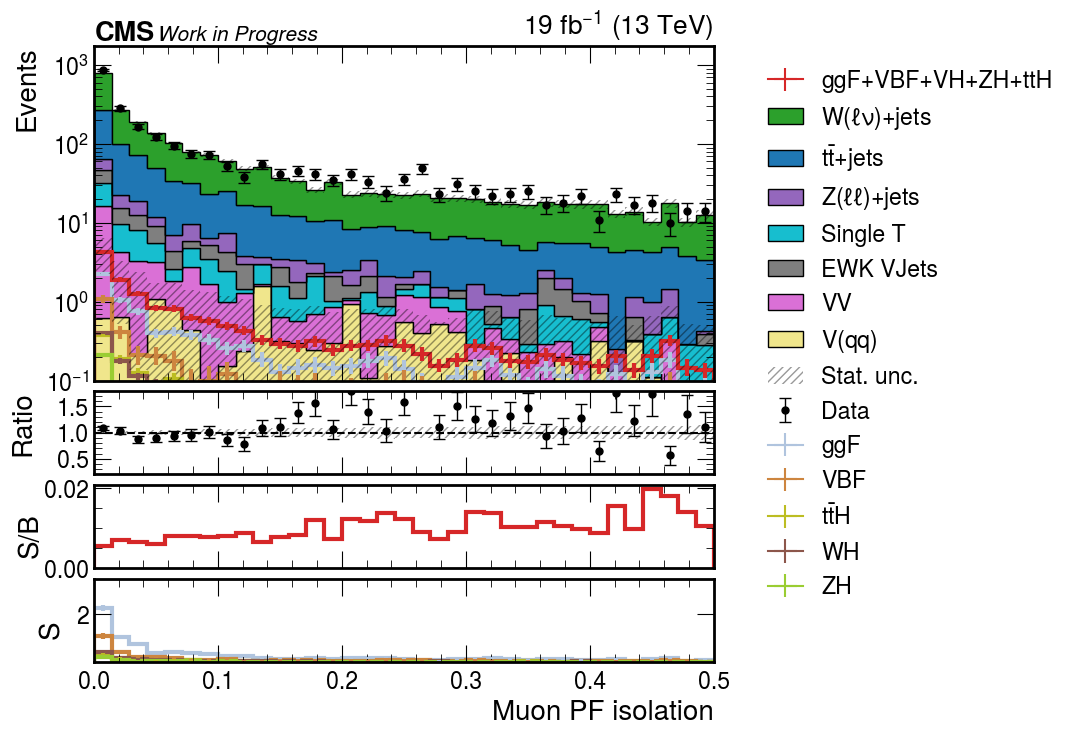

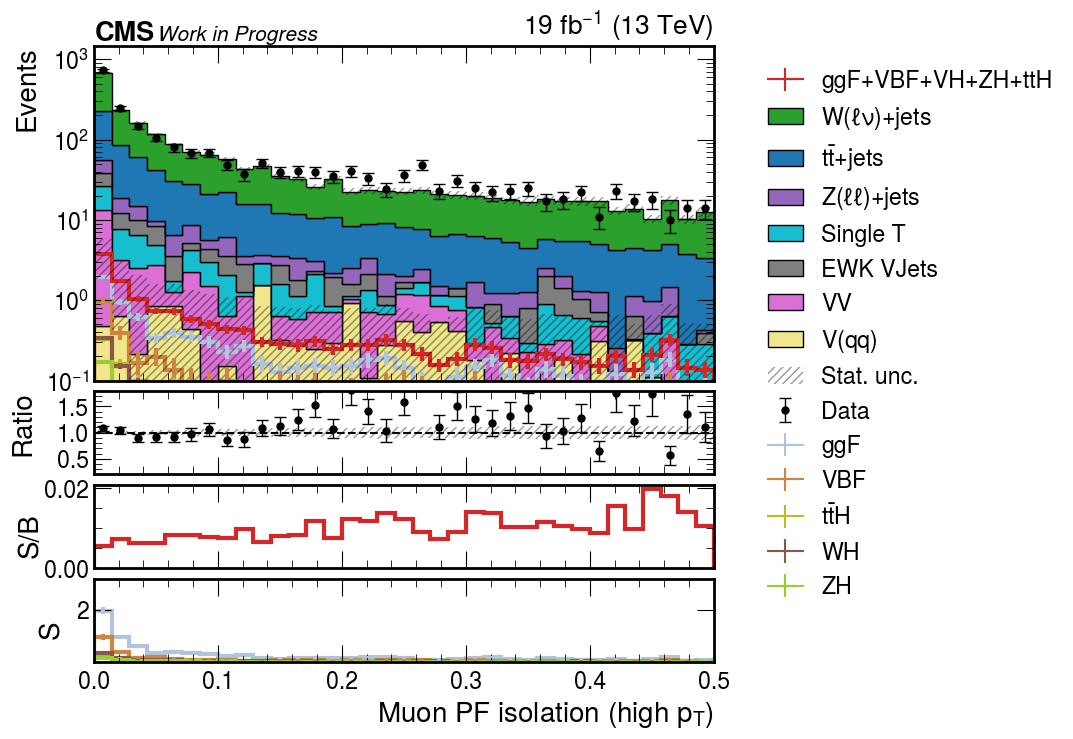

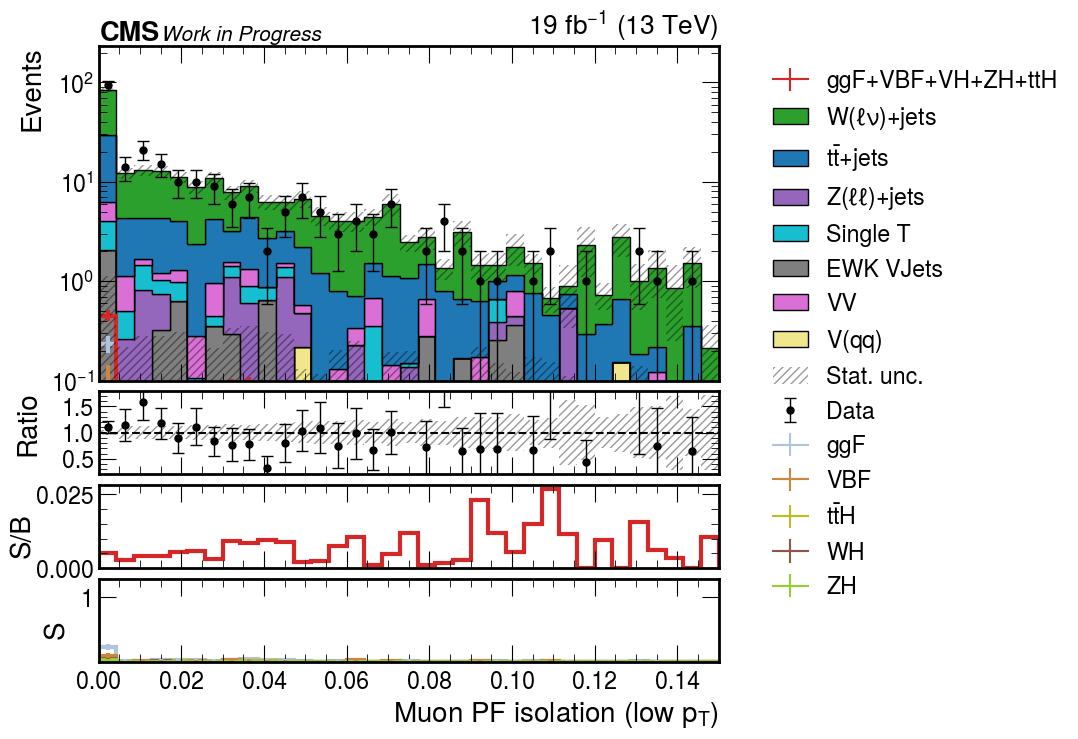

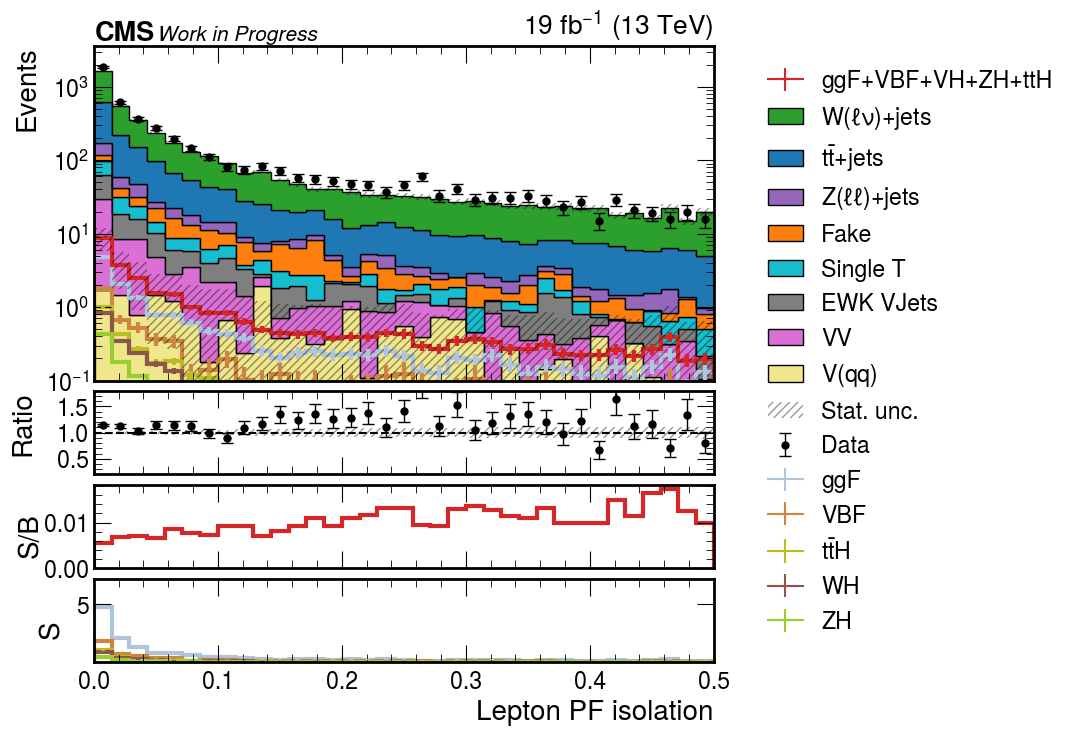

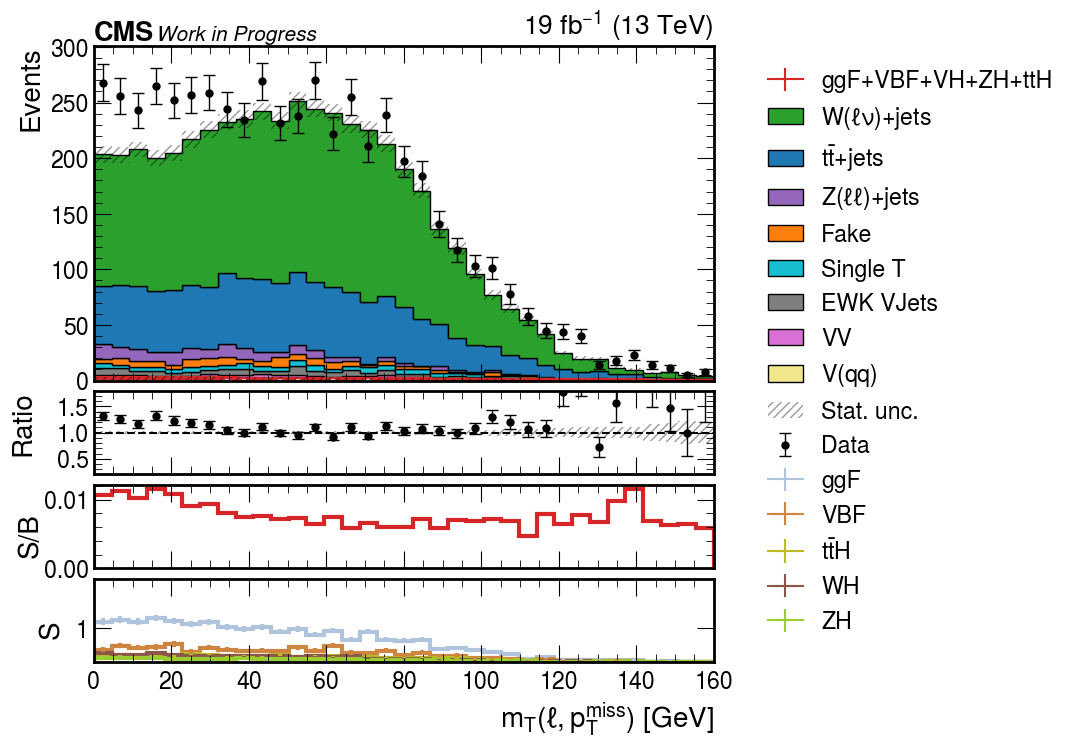

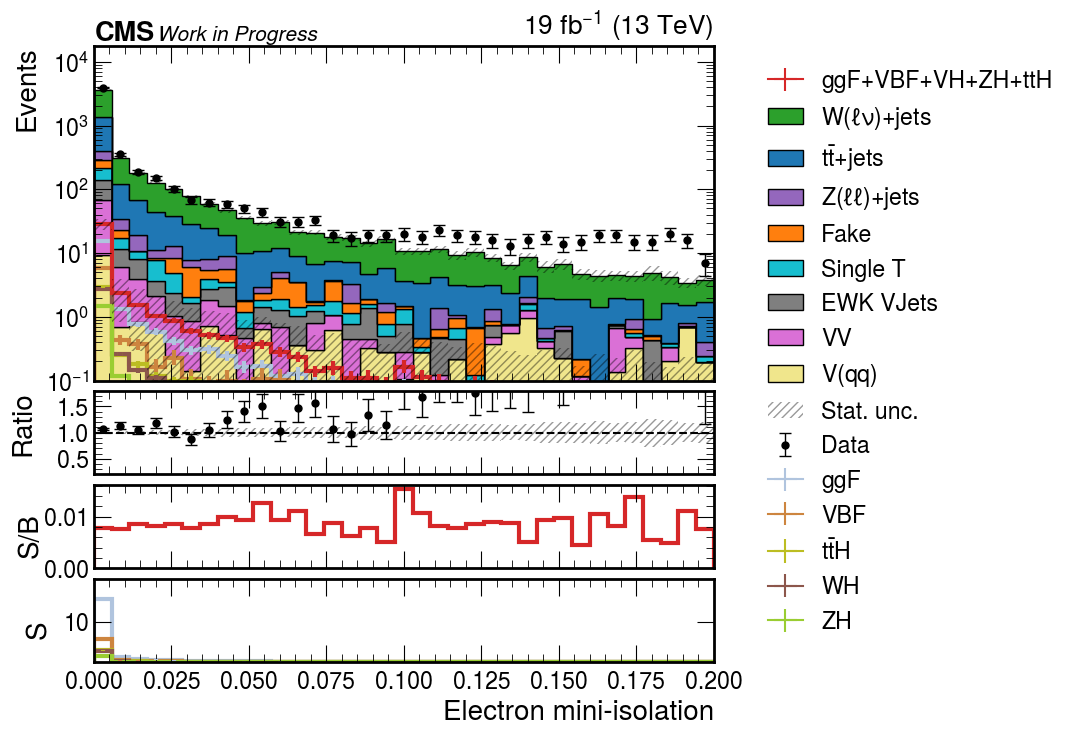

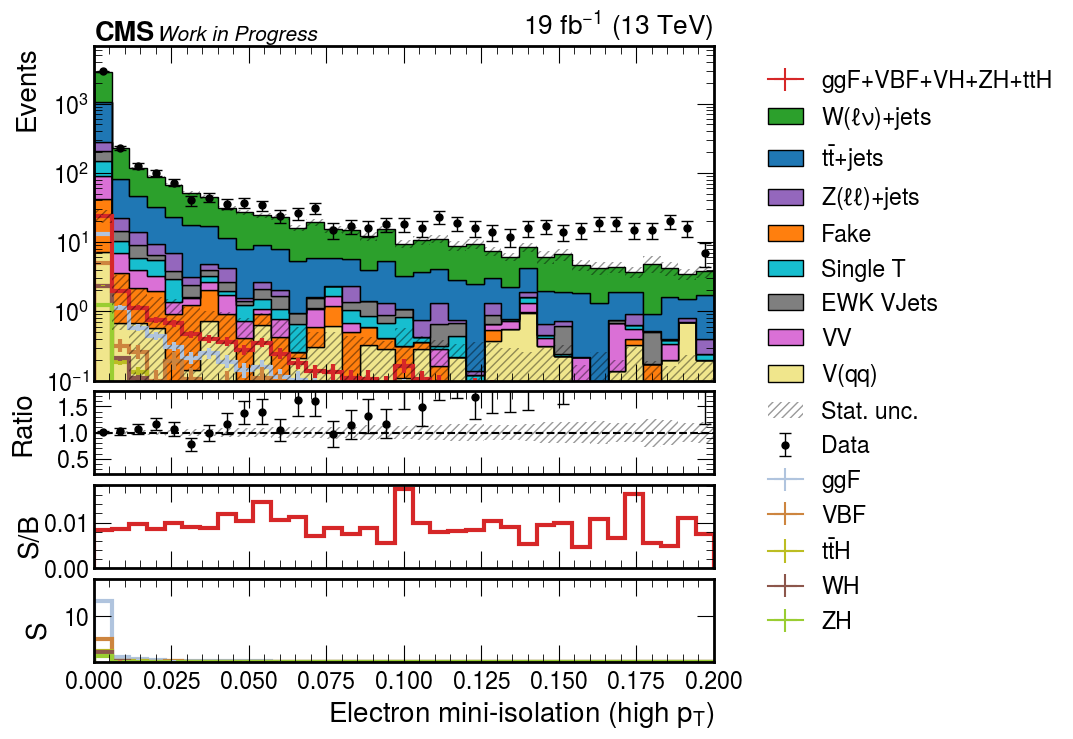

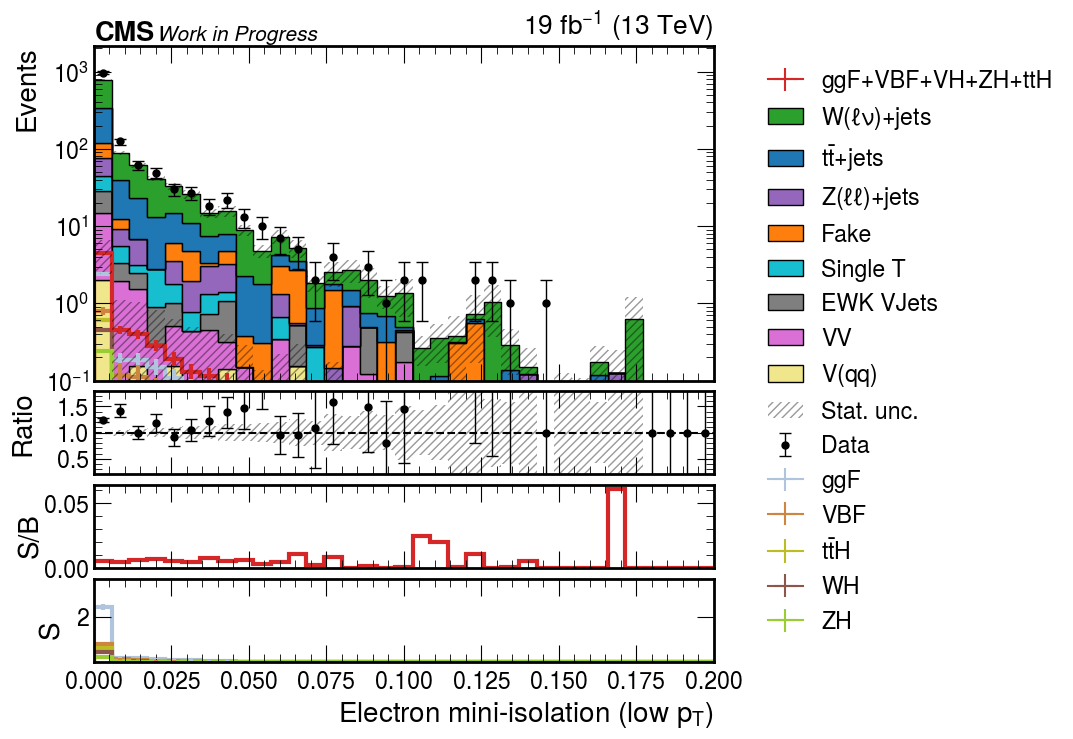

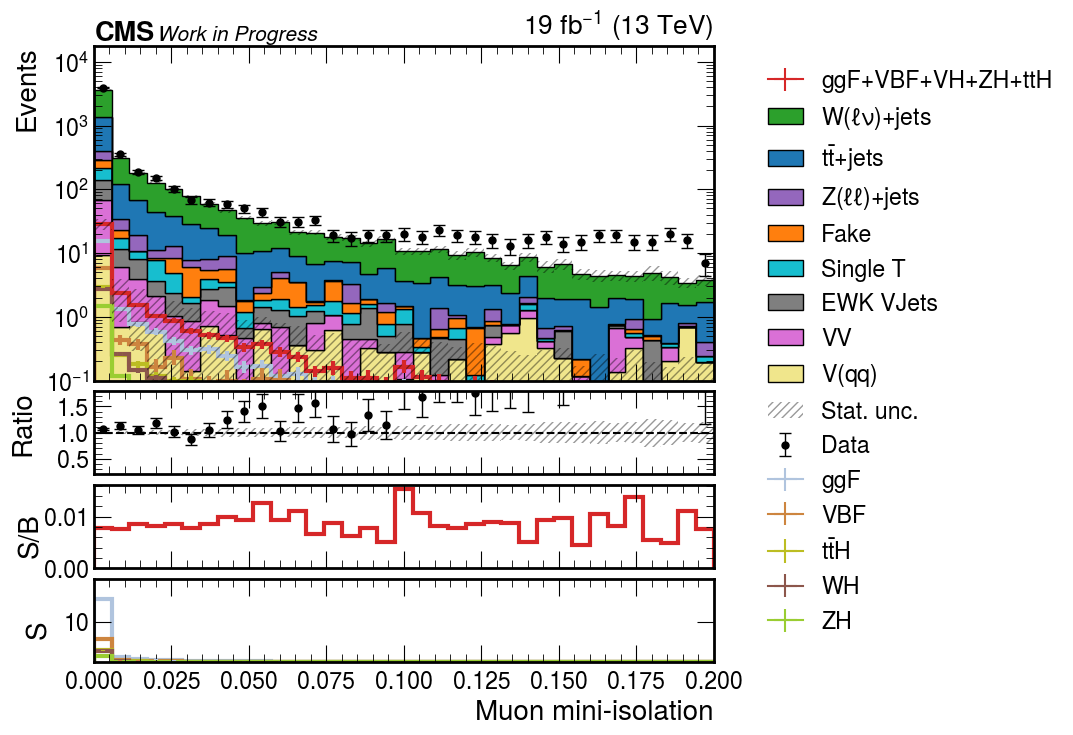

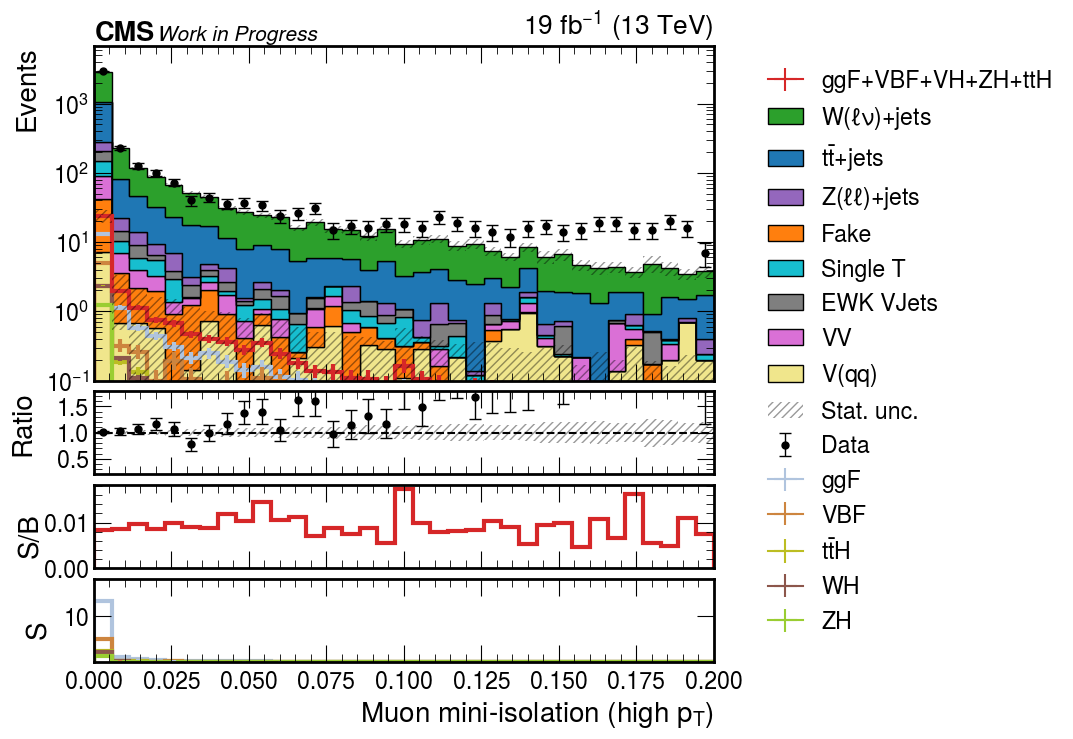

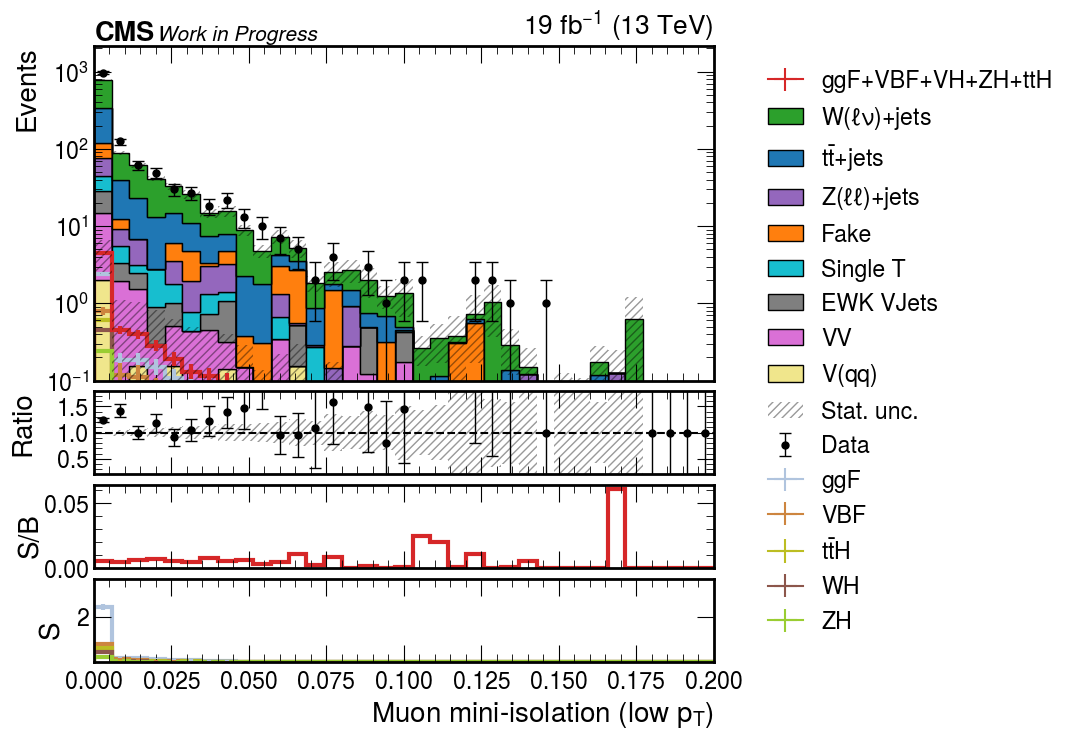

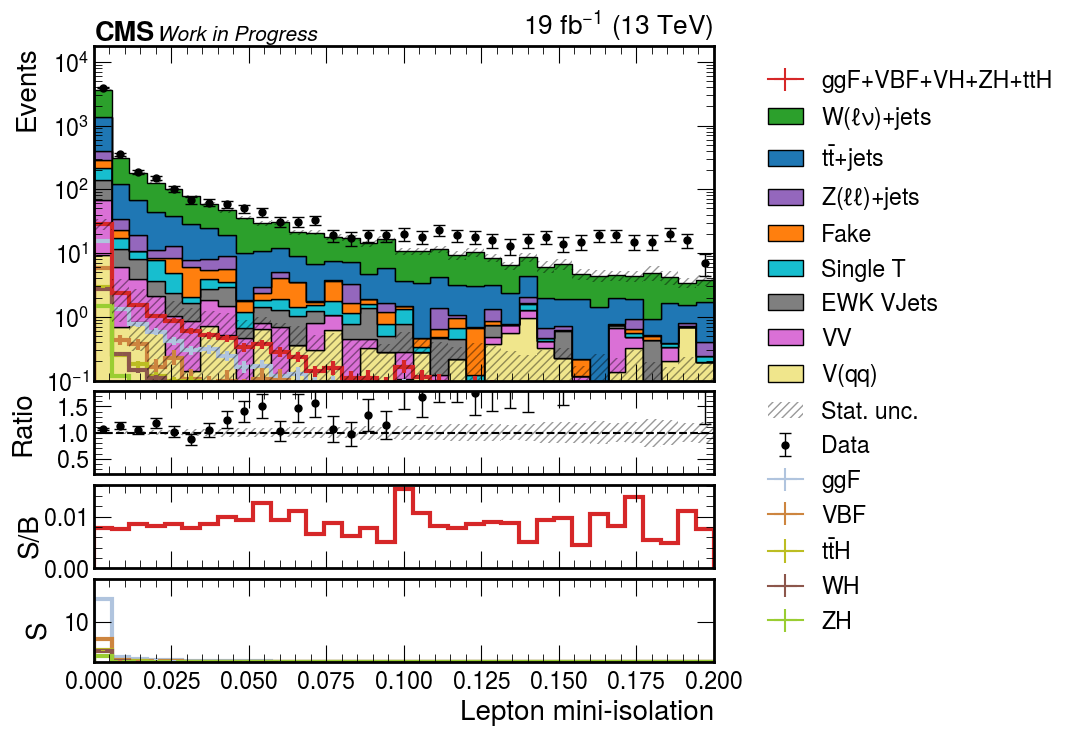

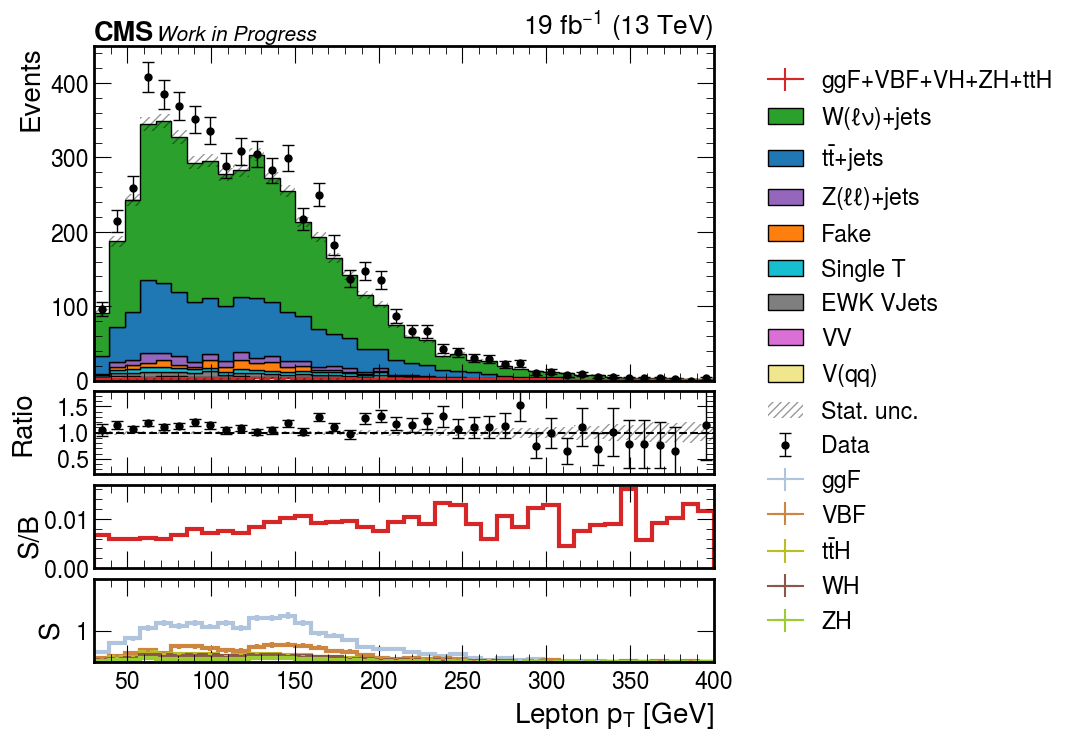

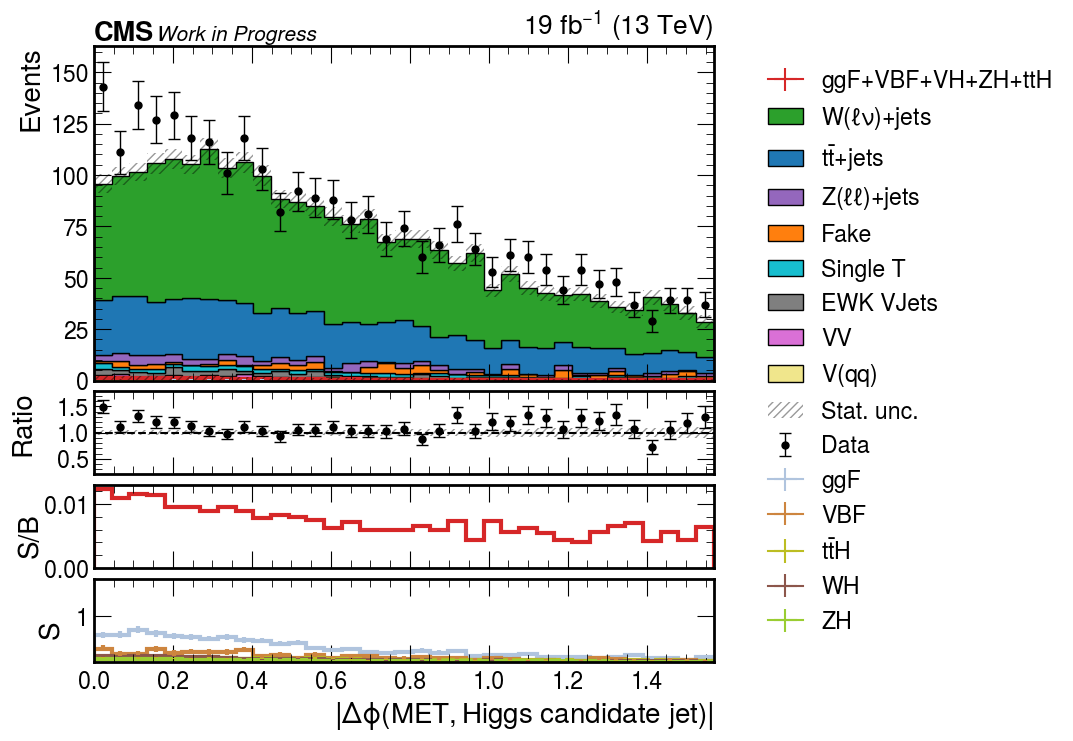

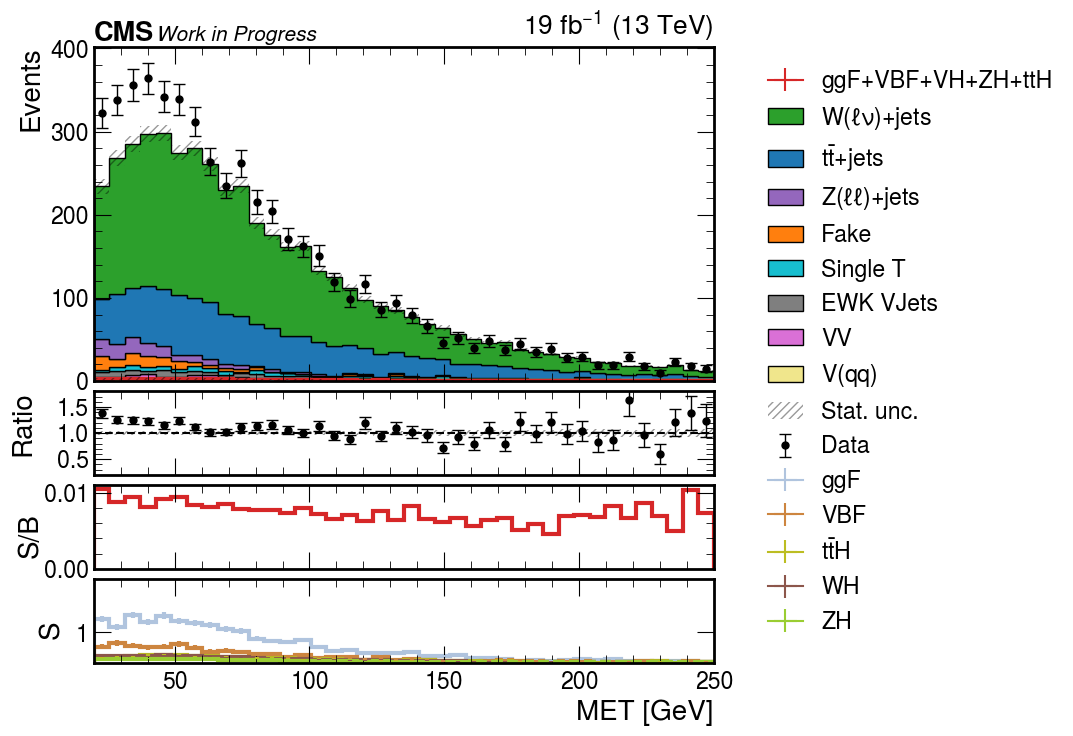

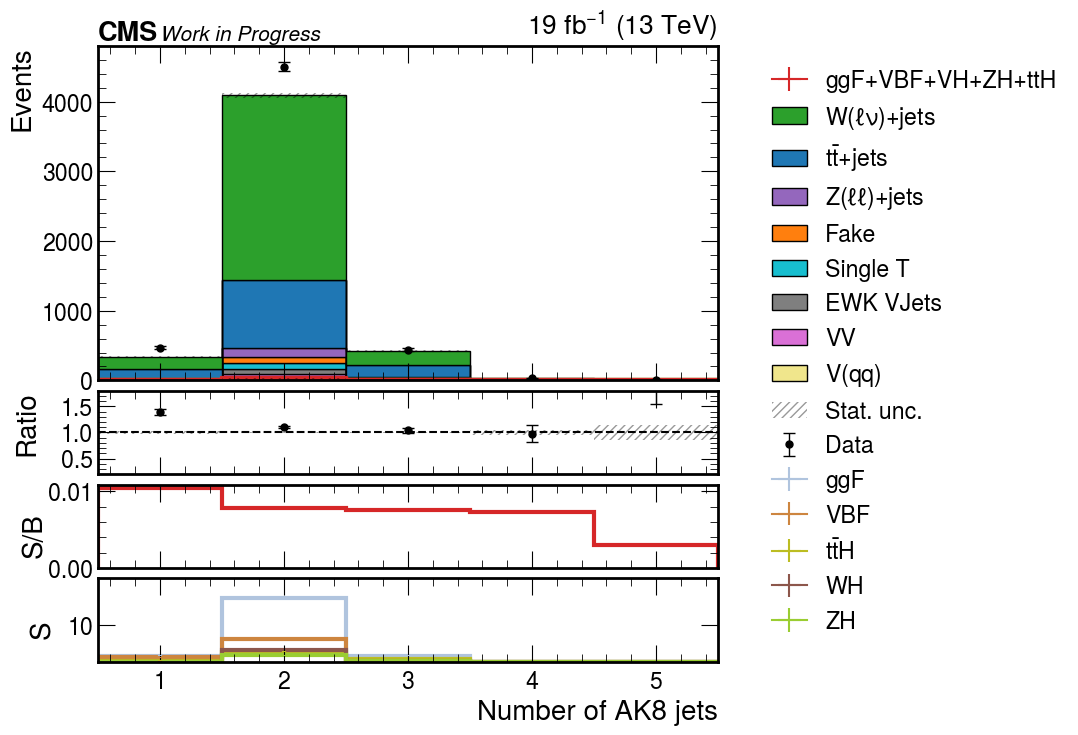

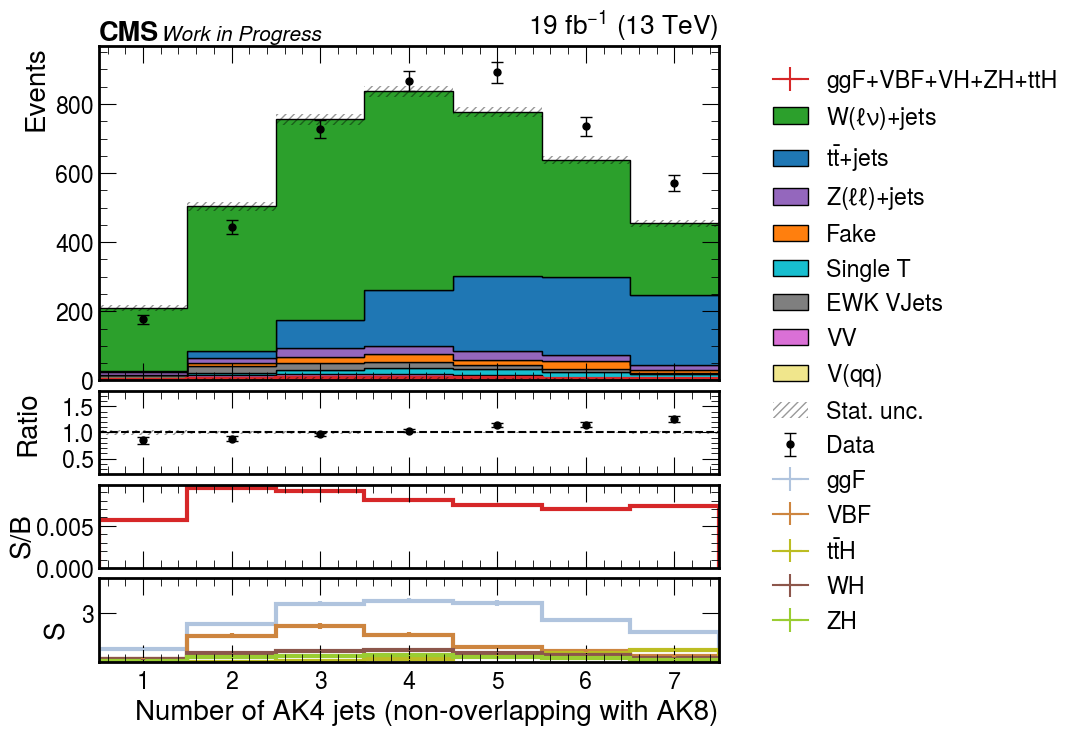

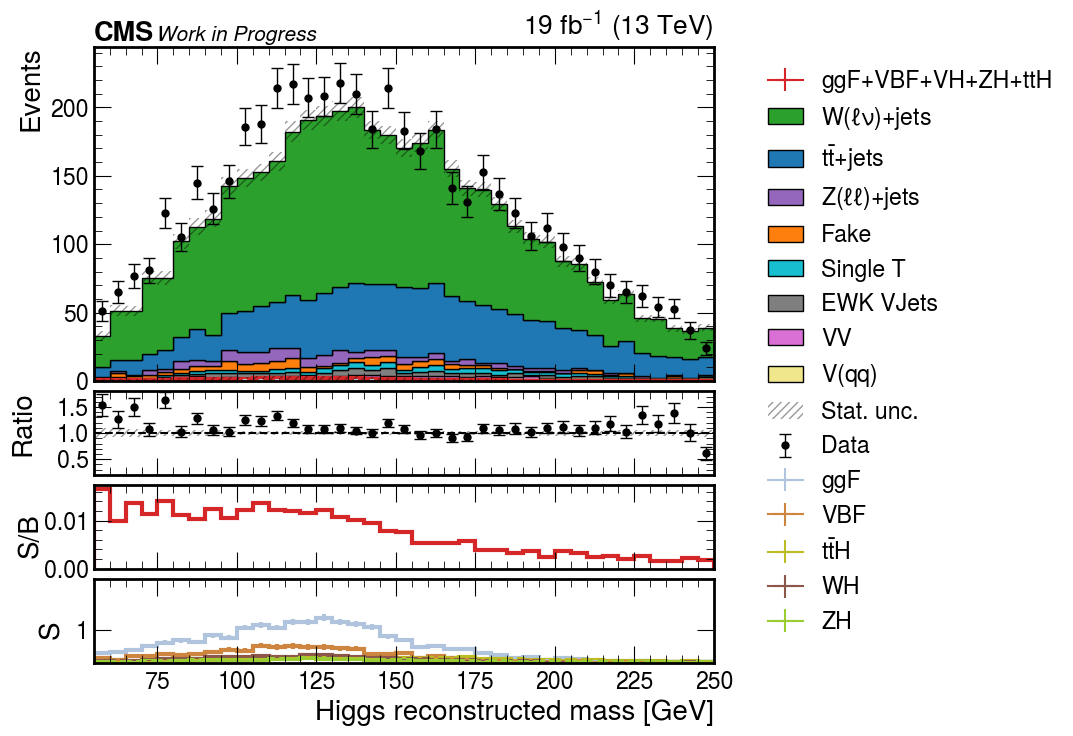

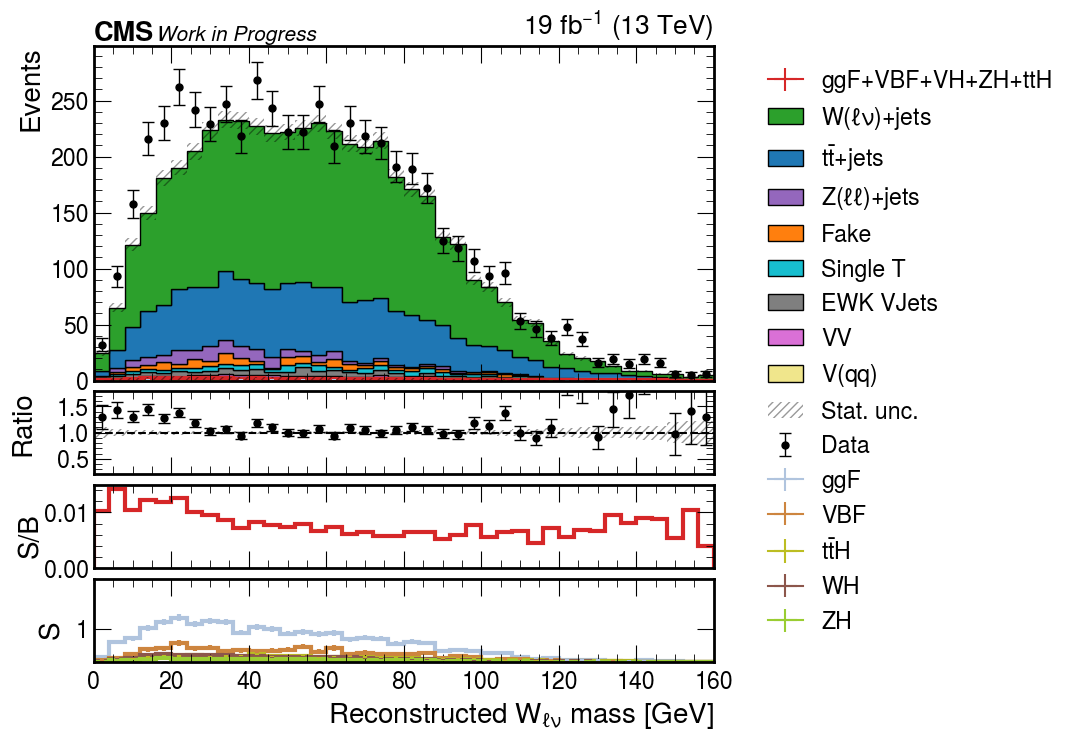

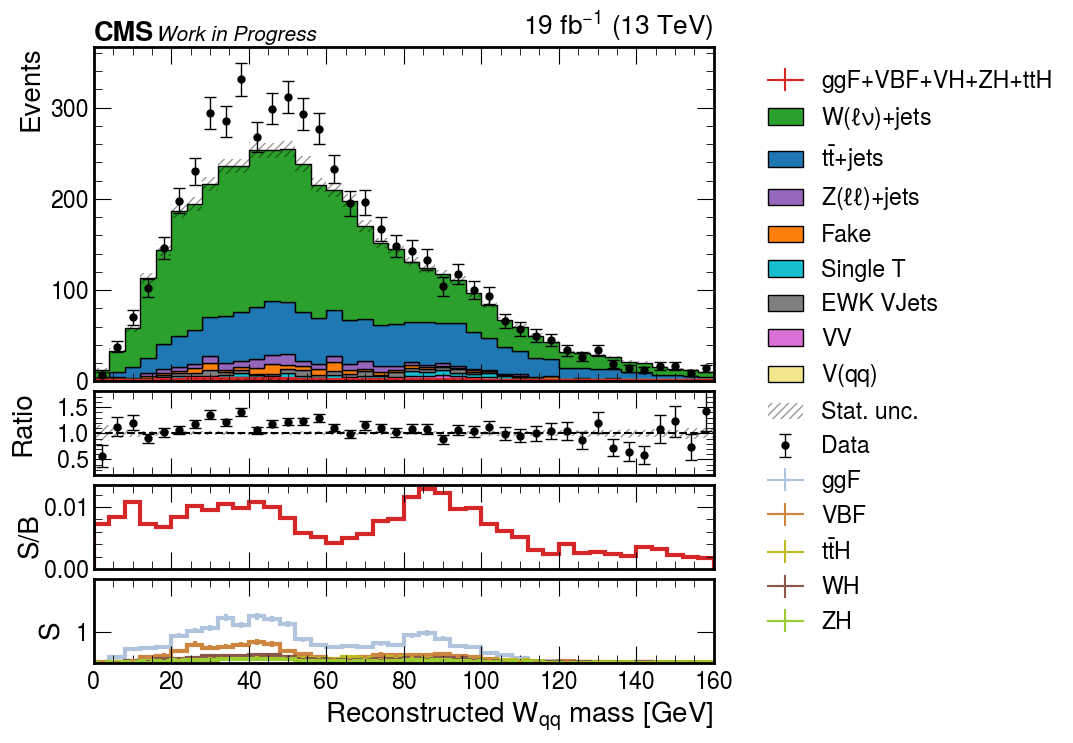

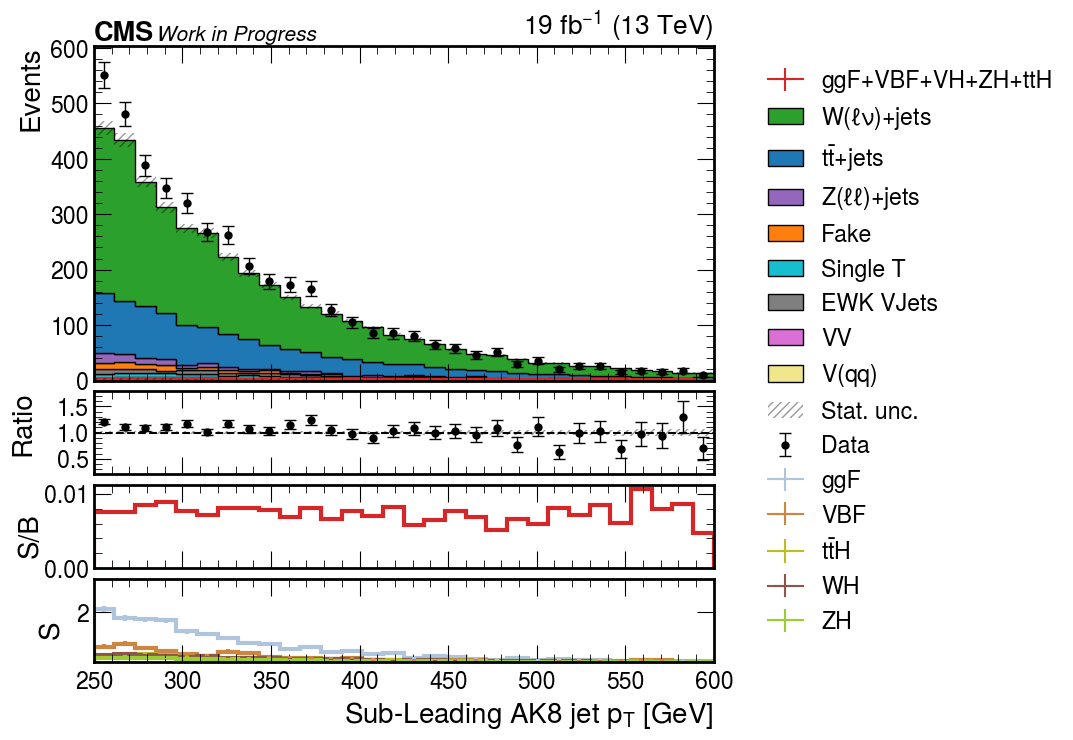

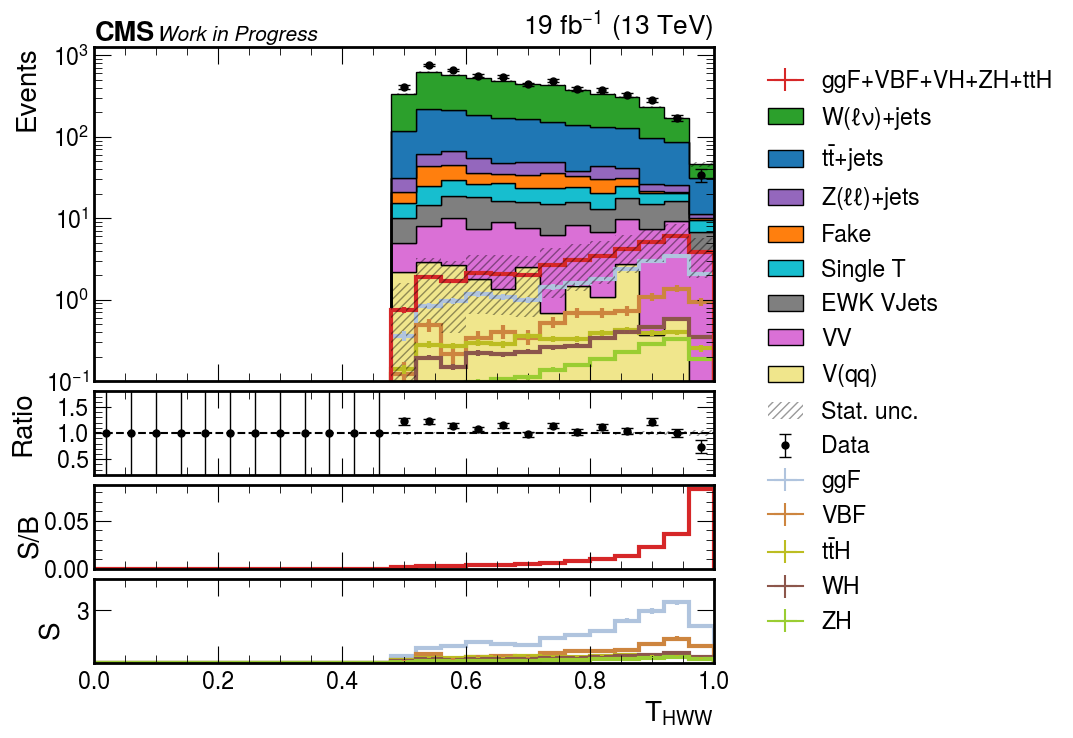

In [615]:
plt.rcParams.update({"font.size": 20})
add_data = True

if "SR" in region or ("Signal region") in region:
    add_soverb=True
    blind_region=[90,160]
    if "SR1" in region:
        mult=5
    else:
        mult=10
else:
    add_soverb=True
    blind_region=False
    mult=1
    
if "CR" in region:
    blind_region = False
    mult = 1

    
if "VBF" in categories_sel:
    mult = 5
    
if len(years) > 1:
    from utils import plot_hists as plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_Run2/"
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/WJetsCR/"
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/TopCR/"

#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_Run2/"
else:
    from utils import plot_hists_sb as plot_hists

    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_{years[0]}/"
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_{years[0]}/"
# from utils import plot_hists as plot_hists

# PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol/"

# PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_Run2_noTHWWcut/fakes/"
# PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_Run2_noTHWWcut/qcd/"

# PATH = f"/Users/fmokhtar/Desktop/AN_2024/TopCR/"
# PATH = f"/Users/fmokhtar/Desktop/AN_2024/WJetsCR/"
# PATH = f"/Users/fmokhtar/Desktop/AN_2024/WJetsCR_splitWmatched/"

if not os.path.exists(PATH):
    # Create the directory
    os.makedirs(PATH)    

nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}
    
plot_hists(hists, years, channels, vars_to_plot,
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=mult,
            outpath=PATH,
#             text_=f"{nice_ch[ch]} channel",
#             text_=region + f"\n {list(categories_sel.keys())[0]} category",
#             text_=region + f"\n category: {list(categories_sel.keys())[0]} \n Applying qcd event_weight<{threshold}",
#             text_=region + f"\n Applying qcd event_weight<{threshold}",
            blind_region=blind_region,
#            save_as=f"{years[0]}_{channels[0]}"
#            save_as=f"{ch}"
          )
# print()
if "QCD" in samples_to_plot:
    get_soverb(events_dict, presel, categories_sel, years, channels, precision=1)
else:
    get_soverb(events_dict, presel, categories_sel, years, channels, precision=1, usefake=True)    

In [577]:
df = events_dict["2017"]["ele"]["WH"]
for key in df:
    if "JES" in key:
        print(key)

fj_ptJES_up
fj_ptJES_down
fj_ptJES_FlavorQCD_up
fj_ptJES_FlavorQCD_down
fj_ptJES_RelativeBal_up
fj_ptJES_RelativeBal_down
fj_ptJES_HF_up
fj_ptJES_HF_down
fj_ptJES_BBEC1_up
fj_ptJES_BBEC1_down
fj_ptJES_EC2_up
fj_ptJES_EC2_down
fj_ptJES_Absolute_up
fj_ptJES_Absolute_down
fj_ptJES_BBEC1_2017_up
fj_ptJES_BBEC1_2017_down
fj_ptJES_RelativeSample_2017_up
fj_ptJES_RelativeSample_2017_down
fj_ptJES_EC2_2017_up
fj_ptJES_EC2_2017_down
fj_ptJES_HF_2017_up
fj_ptJES_HF_2017_down
fj_ptJES_Absolute_2017_up
fj_ptJES_Absolute_2017_down
fj_ptJES_Total_up
fj_ptJES_Total_down
mjjJES_up
mjjJES_down
mjjJES_FlavorQCD_up
mjjJES_FlavorQCD_down
mjjJES_RelativeBal_up
mjjJES_RelativeBal_down
mjjJES_HF_up
mjjJES_HF_down
mjjJES_BBEC1_up
mjjJES_BBEC1_down
mjjJES_EC2_up
mjjJES_EC2_down
mjjJES_Absolute_up
mjjJES_Absolute_down
mjjJES_BBEC1_2017_up
mjjJES_BBEC1_2017_down
mjjJES_RelativeSample_2017_up
mjjJES_RelativeSample_2017_down
mjjJES_EC2_2017_up
mjjJES_EC2_2017_down
mjjJES_HF_2017_up
mjjJES_HF_2017_down
mjjJES_Absol

In [ ]:
tagger = "THWW"
# tagger = "fj_ParT_score"

WP1 = 0.5
# tagger_cut = 0.9   # VBF
# tagger_cut = 0.95  # ggF
WP2 = 0.93

WP_VBF = 0.905

presel = {
#     "Pre-selection": f"({tagger}>0.5)",   # dummy    
#     "Pre-selection": f"({tagger}>{WP1})",   # dummy
    
    "SR": f"{tagger}>0.9 & (n_bjets_T==0)",
#     "Top CR": f"({tagger}>0.5) & (n_bjets_T>0)",
#     "WJets CR": f"({tagger}<{WP2}) & ({tagger}>{WP1}) & (n_bjets_T==0)",
}

categories_sel = {
    "VBF": f"( ({tagger}>{WP_VBF}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
#     "ggF": "(mjj<1000) | (deta<3.5)",
        
#     r"ggF pT [250, 300]": f"( ({tagger}>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>250) & (fj_pt<300) )",
#     f"ggF pT [300, 450]": f"( ({tagger}>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>300) & (fj_pt<450) )",
#     r"ggF pT [450, Inf]": f"( ({tagger}>{WP2}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>450) )",
}

channels = ["ele", "mu"]
# channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]
# years = ["2018"]

num, den = 0, 0
threshold = 0

# fill histograms
hists = {}

import utils

massbin = 20
for var in vars_to_plot:

    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(55, 255, massbin)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),            
        )       
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utils.axis_dict[var],
            storage=hist2.storage.Weight(),            
        )        
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
                if ch=="mu":
                    if sample=="Fake":
                        continue
                region, sel = list(presel.items())[0]

                df = events_dict[year][ch][sample]
        
                
                df = df.query(sel)

                x = df[var]
                
                w = df["event_weight"]
                
#                 if sample != "Data":
# #                     w *= df["btag_1a"]
#                     w *= df["0btag_1b"]
# #                     w *= df["1pbtag_1b"]

#                 if sample == "TTbar_allmatched":
# #                     w *= 0.915 # at WP=0.924
#                     w *= 0.958 # at WP=0.5

                hists[var].fill(
                    samples=sample,
                    var=x,
                    weight=w,
                )     
try:
    print(f"Removing {num} out of {den} EWKvjets events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1
    
for var in vars_to_plot:
    fix_neg_yields(hists[var])

In [626]:
df = events_dict["2016"]["ele"]["ggF"]
for key in df:
    if "btag" in key:
        print(key)

weight_btag
weight_btagSFlight2016Up
weight_btagSFlight2016Down
weight_btagSFbc2016Up
weight_btagSFbc2016Down
weight_btagSFlightCorrelatedUp
weight_btagSFlightCorrelatedDown
weight_btagSFbcCorrelatedUp
weight_btagSFbcCorrelatedDown


(array([  1., 975.,   3.,   1.,   2.,   1.,   1.,   1.,   2.,   4.]),
 array([0.9352177 , 0.97184151, 1.00846532, 1.04508912, 1.08171293,
        1.11833674, 1.15496055, 1.19158436, 1.22820817, 1.26483197,
        1.30145578]),
 <BarContainer object of 10 artists>)

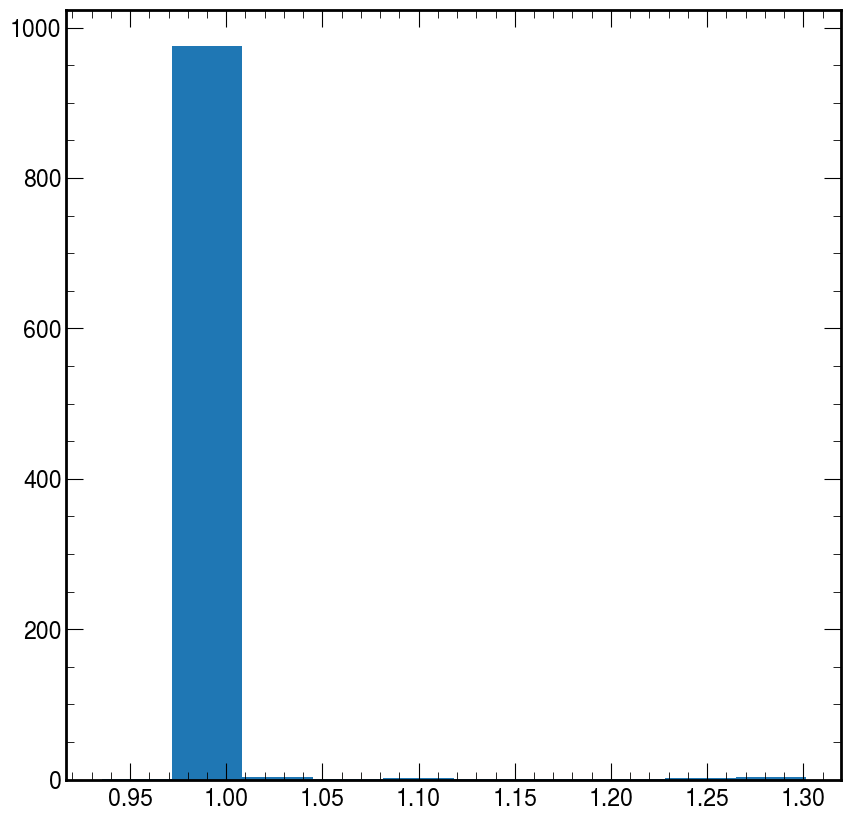

In [627]:
plt.hist(df["weight_btagSFlightCorrelatedUp"])

(array([  1.,   4.,   3.,   2.,   5.,   1.,   0.,   0.,   0., 975.]),
 array([0.65237297, 0.68978057, 0.72718817, 0.76459577, 0.80200337,
        0.83941097, 0.87681856, 0.91422616, 0.95163376, 0.98904136,
        1.02644896]),
 <BarContainer object of 10 artists>)

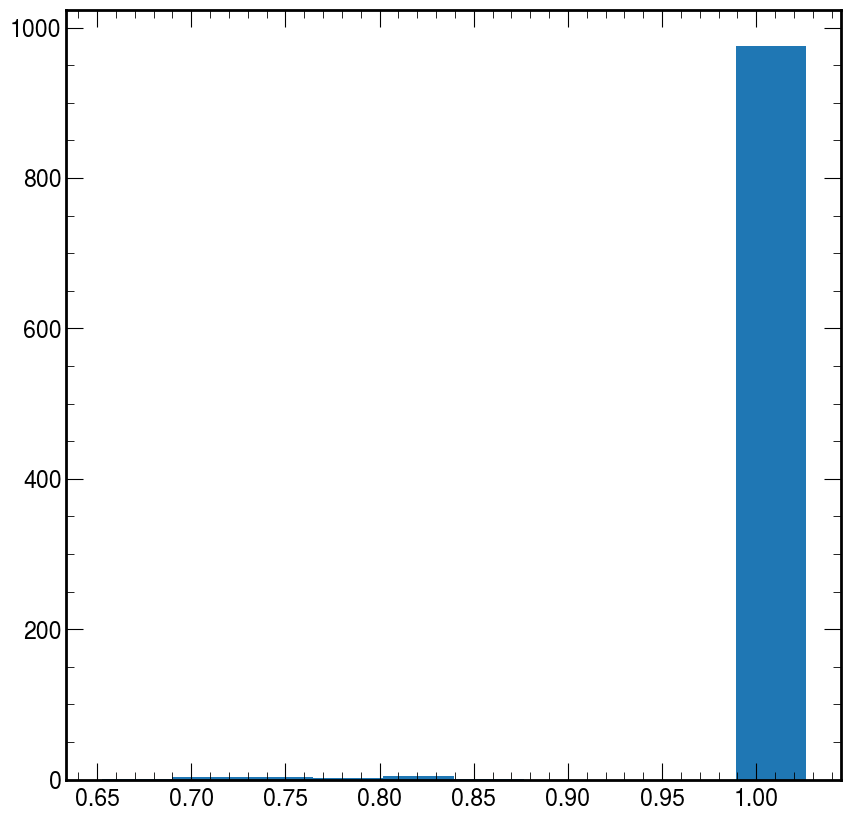

In [628]:
plt.hist(df["weight_btagSFlightCorrelatedDown"])

In [ ]:
# different corrections

lab_dict = {
    "old_corrections": r"Old NLO W+jets corrections",
    "new_corrections": r"New NLO W+jets corrections",
}

fig, ax = plt.subplots(figsize=(10, 8))
for corr in ["old_corrections", "new_corrections"]:
    hep.histplot(h[{"corr": corr}].project("var"),
        label=lab_dict[corr],
        density=False,
        yerr=True,
        flow=None,
    )
ax.legend(title=region, loc="upper right")
ax.set_ylabel(r"Events WJetsLNu (normalized to $\sigma$)")
# ax.set_ylim(0, 0.013)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.0f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/wjetscorr.pdf")     

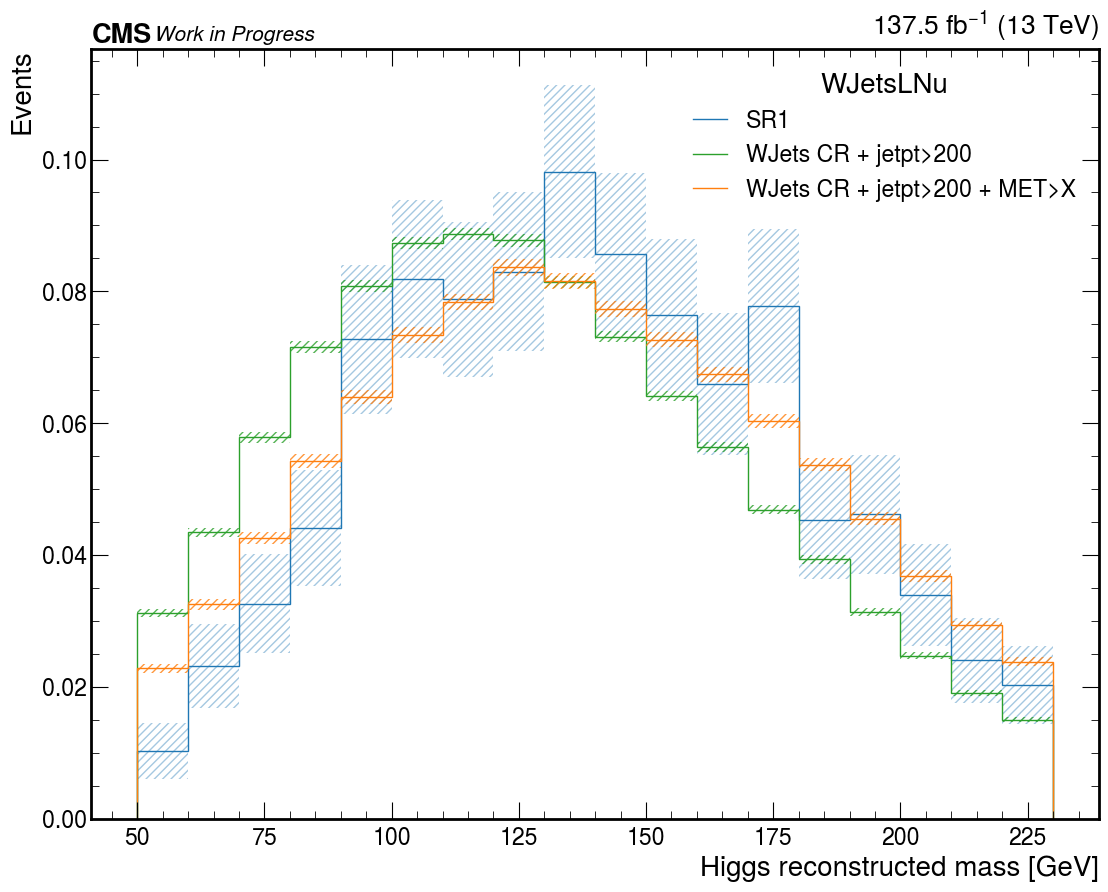

In [243]:
# different regions
fig, ax = plt.subplots(figsize=(13, 10))
color_region = {
    "SR1": "tab:blue",
    "SR2": "tab:orange",
    "WJets CR": "tab:green",
    "Top CR": "tab:green", 
    
    "WJets CR + jetpt>200": "tab:green",
    "WJets CR + jetpt>250": "tab:orange",
    "WJets CR + jetpt>300": "tab:blue",
    
    "WJets CR + jetpt>200 + MET>X": "tab:orange",
    "WJets CR + jetpt>250 + MET>X": "tab:green",
    "WJets CR + jetpt>300 + MET>X": "tab:red",

}

errps = {
    "SR1": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["SR1"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.4,
    },
    "SR2": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["SR2"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.4,
    },
    "WJets CR": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },   
    "Top CR": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },  
    "WJets CR + jetpt>200": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>200"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },
    "WJets CR + jetpt>250": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>250"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },
    "WJets CR + jetpt>300": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>300"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },   
    "WJets CR + jetpt>200 + MET>X": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>200 + MET>X"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },       
    
    "WJets CR + jetpt>250 + MET>X": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>250 + MET>X"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },       
    
    "WJets CR + jetpt>300 + MET>X": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>300 + MET>X"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },       
        
    
}

if False:
    bkg = h[{"region": ["SR1", "SR2"]}].project("var")
    bkg2 = bkg.values()/bkg.values().sum()
    hep.histplot(
    #         bkg,
        bkg2,
        bins=bkg.axes[0].edges,        
        ax=ax,
    #         density=True,
        linewidth=1,
        label="Signal Region (SR1+SR2)",
        flow="none",
    )

    ax.stairs(
        values=(bkg + np.sqrt(bkg))/bkg.values().sum(),
        baseline=(bkg - np.sqrt(bkg))/bkg.values().sum(),
        edges=bkg.axes[0].edges,
        **errps["SR1"],        
        label="Stat. unc.",
    )    
    
for region in presel:
    if "SR2" in region:
        continue

    bkg = h[{"region": region}].project("var")    
    
    bkg2 = bkg.values()/bkg.values().sum()
    hep.histplot(
#         bkg,
        bkg2,
        bins=bkg.axes[0].edges,        
        ax=ax,
#         density=True,
        linewidth=1,
        label=region,
        flow="none",
        color=color_region[region]
    )
    
    ax.stairs(
        values=(bkg + np.sqrt(bkg))/bkg.values().sum(),
        baseline=(bkg - np.sqrt(bkg))/bkg.values().sum(),
        edges=bkg.axes[0].edges,
        **errps[region],        
#         label="Stat. unc.",
    )
    


ax.set_xlabel(bkg.axes.label[0])
ax.legend(title=" + ".join(sample for sample in samples), loc="upper right")
ax.set_ylabel("Events")
# ax.set_ylim(0, 0.015)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/z.pdf")     

In [550]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
    
    
#     "Pre-selection + jetpt>200": f"{tagger}>0.5",    
    "Pre-selection + jetpt>250": f"{tagger}>0.5 & fj_pt>250",  
#     "Pre-selection + jetpt>300": f"{tagger}>0.5 & fj_pt>300",
        
    
#     "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}<0.98) & ({tagger}>0.97) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0)",
    
#     "WJets CR + jetpt>200": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200",   
#     "WJets CR + jetpt>250": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
      
#     "WJets CR + jetpt>200 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200", 
#     "WJets CR + jetpt>250 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
    
#     "Top CR": f"({tagger}>0.50) & (n_bjets_T>=0)",      
    

}

channels = ["ele", "mu"]
channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
var = "met_pt"

# samples = ["ggF", "VBF", "VH", "ttH"]
samples = ["ggF", "QCD"]
# samples = ["WJetsLNu", "DYJets"]

# samples = ["WJetsLNu"]
# samples = ["TTbar"]

h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),        
    hist2.axis.StrCategory([], name="region", growth=True),    
#     hist2.axis.Variable(list(range(50, 240, 10)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    hist2.axis.Regular(30, 0, 250, name="var", label=r"MET", overflow=True),
    
)
ev = events_dict["new_corrections"]

num, den = 0, 0
threshold = 0
for region, sel in presel.items():

    for year in years:
        for ch in channels:   
            for sample in samples:

                df = ev[year][ch][sample]

                df = df.query(sel)    

#                 if (sample == "DYJets"):
#                     threshold = 50
#                     den += len(df['event_weight'])
#                     num += sum(df["event_weight"]>threshold)

#                     df = df[df["event_weight"] < threshold]
                    
                h.fill(
                    samples=sample,
                    region=region,
                    var=df[var],
                    weight=df["event_weight"],
                )     
try:
    print(f"Removing {num} out of {den} DYJets events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1                             

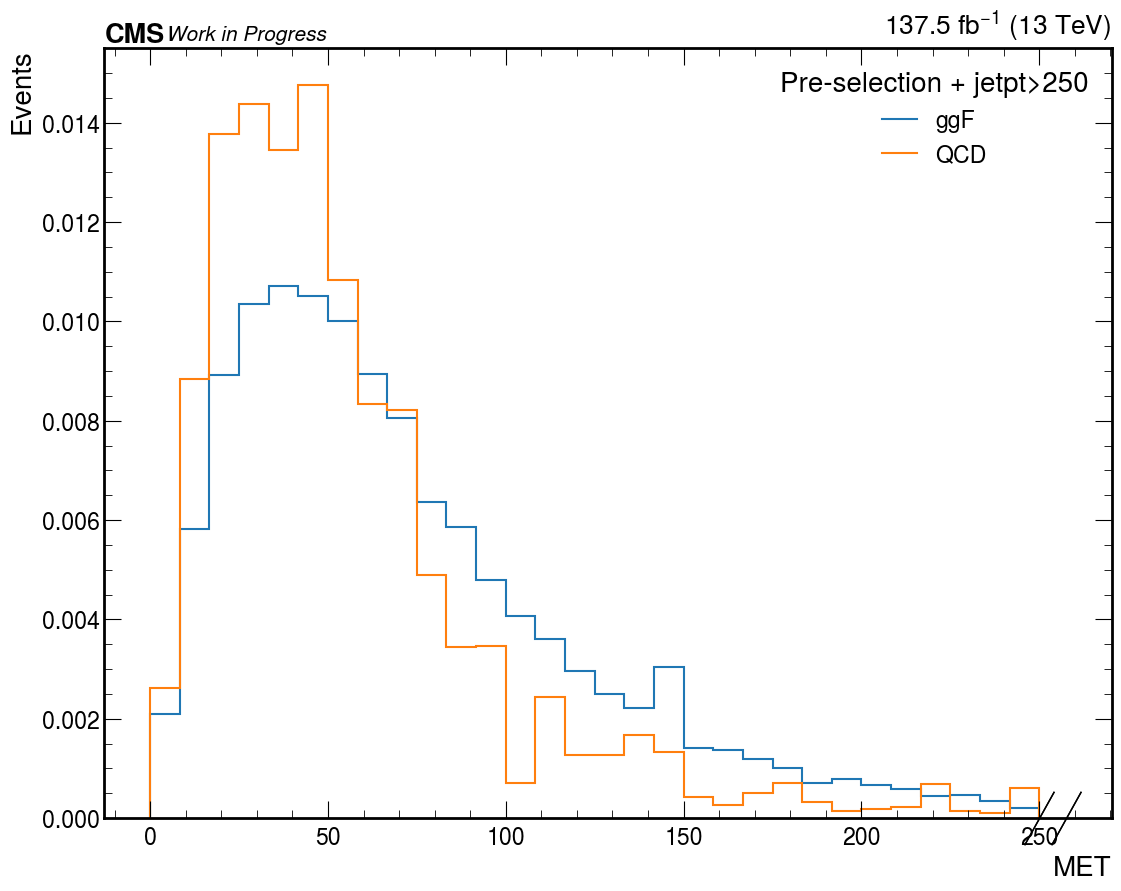

In [553]:
region = "Pre-selection + jetpt>250"
# region = "SR1"

# different regions
fig, ax = plt.subplots(figsize=(13, 10))
for sample in samples:
    hep.histplot(h[{"region": region, "samples": sample}].project("var"),
        label=sample,
        density=True,
#         yerr=True,
    )
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Events")
ax.set_ylim(0)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/z.pdf")     

In [655]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
    
    
    "Pre-selection + jetpt>200": f"{tagger}>0.5",    
    "Pre-selection + jetpt>250": f"{tagger}>0.5 & fj_pt>250",  
    "Pre-selection + jetpt>300": f"{tagger}>0.5 & fj_pt>300",
        
    
#     "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}<0.98) & ({tagger}>0.97) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0)",
    
#     "WJets CR + jetpt>200": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200",   
#     "WJets CR + jetpt>250": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
      
#     "WJets CR + jetpt>200 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200", 
#     "WJets CR + jetpt>250 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
    
#     "Top CR": f"({tagger}>0.50) & (n_bjets_T>=0)",      
    

}


years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
var = "met_pt"

samples = ["ggF", "VBF", "VH", "ttH"]
# samples = ["QCD"]
# samples = ["WJetsLNu"]
# samples = ["TTbar"]

h = hist2.Hist(
    hist2.axis.StrCategory([], name="channels", growth=True),        
    hist2.axis.StrCategory([], name="region", growth=True),    
#     hist2.axis.Variable(list(range(50, 240, 10)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    hist2.axis.Regular(30, 0, 250, name="var", label=r"MET", overflow=True),
    
)
ev = events_dict["new_corrections200"]
channels = ["ele", "mu"]

num, den = 0, 0
threshold = 0
for region, sel in presel.items():

    for year in years:
        for ch in channels:   
            for sample in samples:

                df = ev[year][ch][sample]

                df = df.query(sel)    

#                 if (sample == "QCD"):
#                     threshold = 200
#                     den += len(df['event_weight'])
#                     num += sum(df["event_weight"]>threshold)

#                     df = df[df["event_weight"] < threshold]
                    
                h.fill(
                    channels=ch,
                    region=region,
                    var=df[var],
                    weight=df["event_weight"],
                )     
try:
    print(f"Removing {num} out of {den} qcd events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1                             

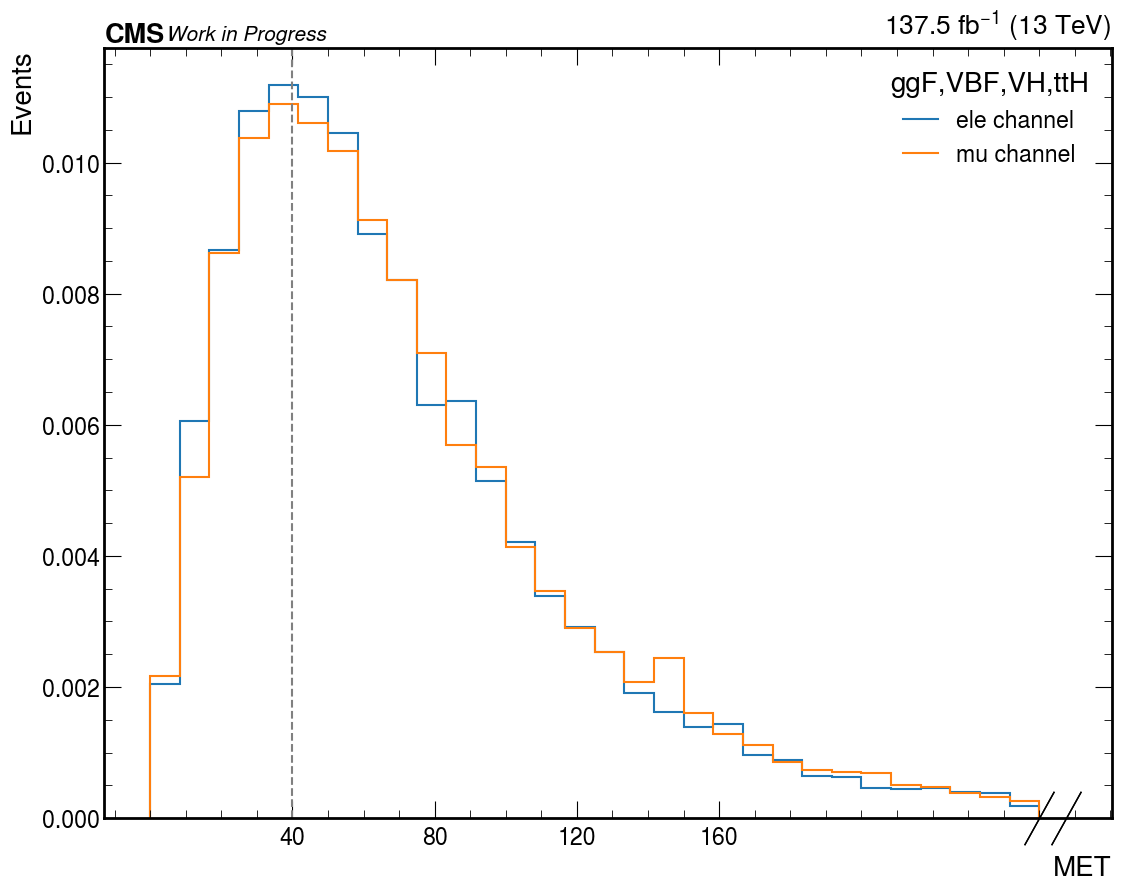

In [656]:
region = "Pre-selection + jetpt>200"
# region = "SR1"

# different regions
fig, ax = plt.subplots(figsize=(13, 10))
for ch in channels:
    hep.histplot(h[{"region": region, "channels": ch}].project("var"),
        label=ch + " channel",
        density=True,
#         yerr=True,
    )
ax.legend(title=",".join(samples), loc="upper right")
ax.set_ylabel("Events")
ax.set_ylim(0)
# ax.set_yscale("log")
ax.axvline(x=40, linestyle="--", color="grey")

ax.set_xticks([40, 80, 120, 160])
lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/z.pdf")     

# WJetsLNu corrections

In [646]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
    
    "Pre-selection": f"{tagger}>0.5",    
    
#     "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}<0.98) & ({tagger}>0.97) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0)",
    
#     "WJets CR + jetpt>200": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200",   
#     "WJets CR + jetpt>250": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
      
#     "WJets CR + jetpt>200 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200", 
#     "WJets CR + jetpt>250 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
    
#     "Top CR": f"({tagger}>0.50) & (n_bjets_T>=0)",      
    

}

channels = ["ele", "mu"]
channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="corr", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="corr", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )  
    
for region, sel in presel.items():

    for year in years:
        for ch in channels:   
            for corr_ in ["old_corrections", "new_corrections"]:

                df = events_dict[corr_][year][ch]["WJetsLNu"]

                df = df.query(sel)    

                h.fill(
                    corr=corr_,
                    var=df[var],
                    weight=df["event_weight"],
                )

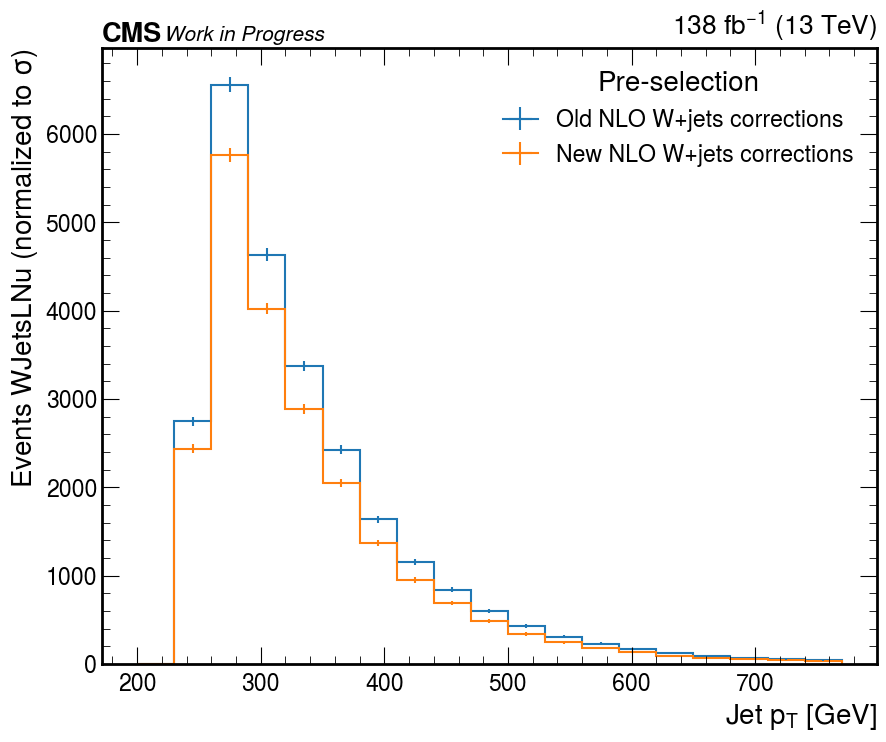

In [661]:
# different corrections

lab_dict = {
    "old_corrections": r"Old NLO W+jets corrections",
    "new_corrections": r"New NLO W+jets corrections",
}

fig, ax = plt.subplots(figsize=(10, 8))
for corr in ["old_corrections", "new_corrections"]:
    hep.histplot(h[{"corr": corr}].project("var"),
        label=lab_dict[corr],
        density=False,
        yerr=True,
        flow=None,
    )
ax.legend(title=region, loc="upper right")
ax.set_ylabel(r"Events WJetsLNu (normalized to $\sigma$)")
# ax.set_ylim(0, 0.013)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.0f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/wjetscorr.pdf")     

In [161]:
samples_to_plot = [
    'WJetsToLNu_HT-70To100',
    'WJetsToLNu_HT-100To200',
    'WJetsToLNu_HT-200To400',
    'WJetsToLNu_HT-400To600',
    'WJetsToLNu_HT-600To800',
    'WJetsToLNu_HT-800To1200',
    'WJetsToLNu_HT-1200To2500',
    'WJetsToLNu_HT-2500ToInf',    
]

In [181]:
tagger = "fj_ParT_score_finetuned"
presel = {
#     "Pre-selection": f"fj_pt>0",       

    "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20)",
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
hists = {}

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )      

corr = "new_corrections_wjets"
ev = events_dict[corr]

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            region, sel = list(presel.items())[0]

            try:
                df = ev[year][ch][sample]
                df = df.query(sel)
                if "MET>X" in region:
                    if ch=="ele":
                        df = df[df["met_pt"]>70]
                    else:
                        df = df[df["met_pt"]>50]
                x = df[var]                            
                if len(x)==0:
                    x = 0   
                w = df["event_weight"]
                
            except:
                print(f"{sample} does not exist in {corr}")
                x = 0
                w = 0
                
            h.fill(
                samples=sample, var=x, weight=w,
            )

WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets
WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets
WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets


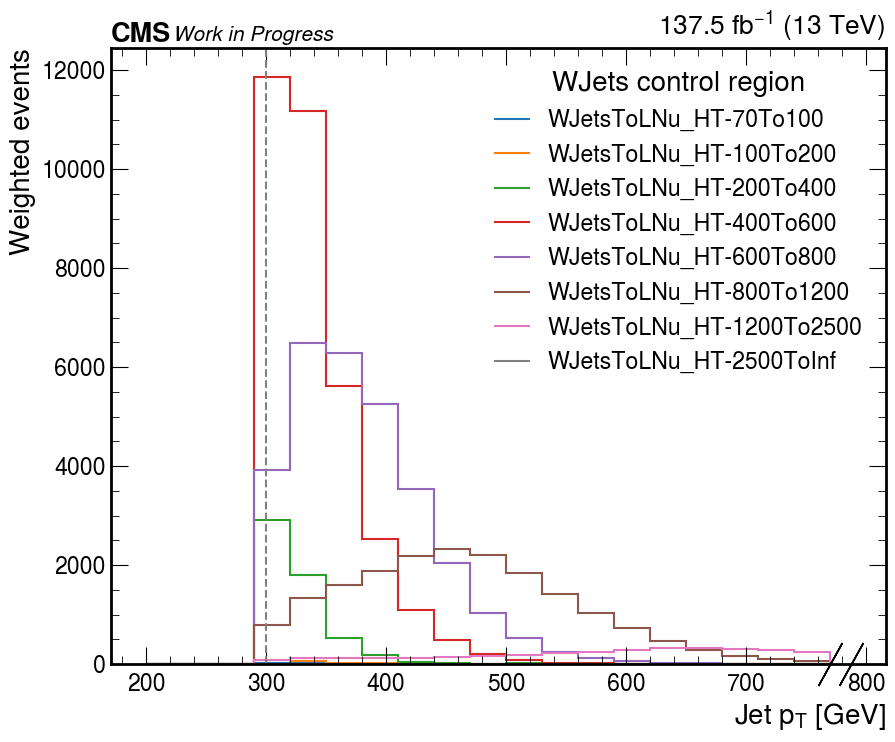

In [182]:
fig, ax = plt.subplots(figsize=(10, 8))
for sample in samples_to_plot:
    hep.histplot(h[{"samples": sample}].project("var"),
        label=sample,
#         density=True,
#         yerr=False,
    )
ax.axvline(300, linestyle="--", color="grey")
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Weighted events")
# ax.set_ylim(0.01, 10e4)
# ax.set_ylim(0, 2500)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/wjetscorr.pdf")     

# High qcd weights

In [1855]:
samples_to_plot = list(events_dictqcd["signal_region"]["2017"]["ele"].keys())
samples_to_plot

['QCD_Pt_3200toInf',
 'QCD_Pt_1800to2400',
 'QCD_Pt_2400to3200',
 'QCD_Pt_1000to1400',
 'QCD_Pt_600to800',
 'QCD_Pt_300to470',
 'QCD_Pt_170to300',
 'QCD_Pt_800to1000',
 'QCD_Pt_470to600',
 'QCD_Pt_1400to1800']

In [1856]:
tagger = "fj_ParT_score_finetuned"
presel = {
    "Pre-selection": f"fj_pt>0",       

#     "High purity signal region": f"({tagger}>0.97)",
#     "High purity signal region + MET>X": f"({tagger}>0.97)",
    
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
#     "Medium purity signal region + MET>X": f"({tagger}<0.97) & ({tagger}>0.85)",
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
#     "WJets control region + MET>X": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
    
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
hists = {}

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )      
else:
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(0, 500, 20)), name="var", label=r"Event weight", overflow=True)
    )      

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            region, sel = list(presel.items())[0]

            df = events_dictqcd["signal_region"][year][ch][sample]
            df = df.query(sel)

            if "MET>X" in region:
                if ch=="ele":
                    df = df[df["met_pt"]>70]
                else:
                    df = df[df["met_pt"]>50]

            x = df[var]
            if len(x)==0:
                x = 0   
                
            if var=="event_weight":
                h.fill(
                    samples=sample, var=x,
                )

            else:
                h.fill(
                    samples=sample, var=x, weight=df["event_weight"],
                )

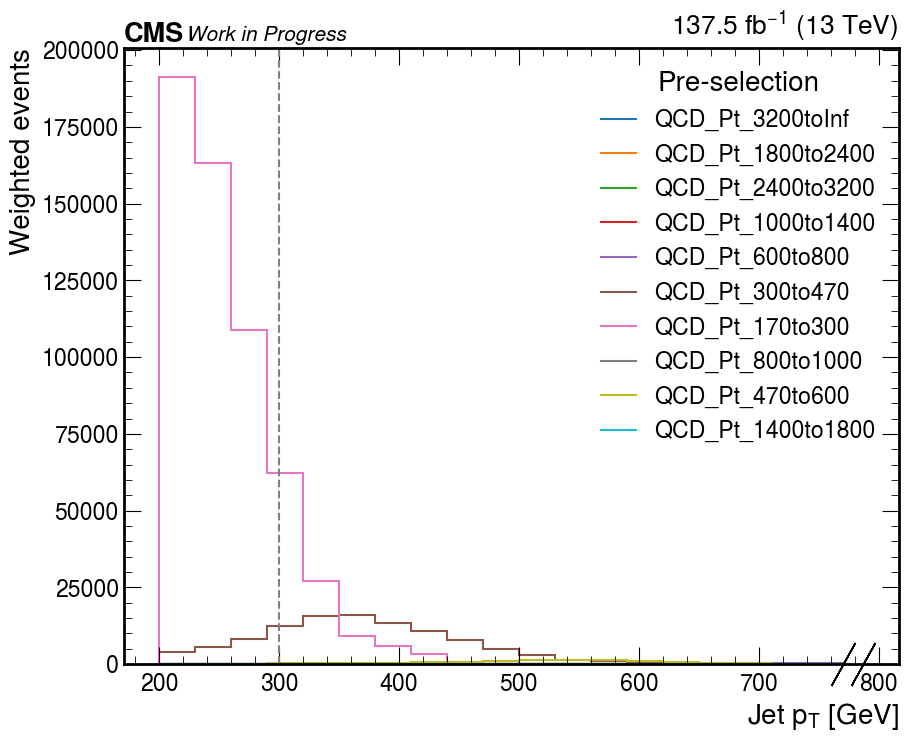

In [1857]:
fig, ax = plt.subplots(figsize=(10, 8))
for sample in samples_to_plot:
    hep.histplot(h[{"samples": sample}].project("var"),
        label=sample,
#         density=True,
#         yerr=False,
    )
ax.axvline(300, linestyle="--", color="grey")
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Weighted events")
# ax.set_ylim(0.01, 10e4)
# ax.set_ylim(0, 2500)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/qcd_high_weights_wjets_jetpt.pdf")     

# soverb

In [149]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]

In [150]:
samples

['ggF',
 'VH',
 'VBF',
 'ttH',
 'QCD',
 'DYJets',
 'WJetsLNu',
 'WZQQ',
 'TTbar',
 'SingleTop',
 'Diboson',
 'Data']

In [333]:
# tagger = "ParT_finetuned"
tagger = "fj_ParT_score_finetuned"

presel = {
#     "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)", 
    "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20)", 

#     "WJets control region + dR>0.2": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0) & (lep_fj_dr>0.2)",    

#     "Top control region": f"({tagger}<0.2) & (n_bjets_T>0)",  
#     "Top control region + dR>0.1": f"({tagger}<0.20) & (n_bjets_T>0) & (lep_fj_dr>0.1)",      

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
#     "Lep iso": f"fj_pt>0",
}

categories_sel = {
#     "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
#     "ggF_pt200to300": "( (mjj<1000) | (deta<3.5) ) & (fj_pt<300)",    
#     "ggF_pt300toinf": "( (mjj<1000) | (deta<3.5) ) & (fj_pt>300)",
    
}

mass_window = [80, 160]

years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "DYJets": 0,
    "Others": 0,
}

deno_sig, deno_bkg = 0, 0
s, b = 0, 0

for year in years:
    for ch in channels:
        for sample in samples:
            if sample=="Data":
                continue

            for k, v in presel.items():
                if "QCD" in k:
                    df = events_dict["qcd_region"][year][ch][sample]
                else:
                    df = events_dict["signal_region"][year][ch][sample]

                df = df.query(v)  
                
#                 if "High" in k:
#                     if sample == "QCD":
#                         df = df[df["event_weight"]<140]
#                 if "Medium" in k:
#                     if sample == "QCD":
#                         df = df[df["event_weight"]<200]
            
#             for category, category_sel in categories_sel.items():
#                 df = df.query(category_sel)            
            
#             if sample == "QCD":
#                 df = df[df["event_weight"]<50]
                
#             if ch=="ele":
#                 df = df[df["met_pt"]>70]
#             else:
#                 df = df[df["met_pt"]>50]
                
#             df = df[df["n_bjets_L"]==0]
#             df = df[df["lep_fj_dr"]>0.2]
            df = df[df["lep_met_mt"]>40]
    
#             df = df[(df["fj_pt"]/df["lep_pt"])<3]

#             df = df[np.abs(df["met_fj_dphi"])<2.5]

#             df = df[df["fj_ParT_mass"]<50]

#             df = df[df["fj_pt"]>250]
            ######################## composition start
            if sample in utils.signals:
                
                deno_sig += df["event_weight"].sum()
                num_sig[sample] += df["event_weight"].sum()
            else:
                deno_bkg += df["event_weight"].sum()
                
                if sample in dominant_backgrounds:
                    num_bkg[sample] += df["event_weight"].sum()
                else:
                    num_bkg["Others"] += df["event_weight"].sum()     
            ######################## composition end
            
            ######################## soverb start
            df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
    
            if sample in utils.signals:                
                s += df["event_weight"].sum()
            else:
                b += df["event_weight"].sum()
            ######################## soverb end

In [334]:
num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

if len(years) == 4:
    lab = "Run2"
else:
    lab = "_".join(years)

print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
# print("Category:", category)

print("------------------------")

if "purity" in list(presel.keys())[0]:
    print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
    print("------------------------")

print(f"Signal: {deno_sig:.2f}")
for sample in num_sig:
    print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")
    
print("------------------------")
print(f"Background: {deno_bkg:.2f}")
for sample in num_bkg:
    if sample=="":
        print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
    else:
        print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%") 

WJets control region (Run2):
------------------------
Signal: 475.17
- ttH: 16%
- VH: 17%
- VBF: 20%
- ggF: 47%
------------------------
Background: 497404.16
- Others: 2%
- QCD: 5%
- DYJets: 15%
- TTbar: 18%
- WJetsLNu: 59%


In [587]:
(0.74**2 + 0.81**2 + 0.59**2)**0.5   # VBF / ggF200-300 / ggF300-450 / ggF450-inf

1.2457126474432216

# WJetsLNu region

In [455]:
tagger = "fj_ParT_score_finetuned_v2_nor2"

# mass_window = [50, 200]

years = ["2018", "2017"]
# years = ["2017"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "Others": 0,
}
deno_sig, deno_bkg = 0, 0

# tagger_cuts = [0.01, 0.02, 0.03, 0.04, 0.07, 0.09, 0.1, 0.2, 0.8]
# tagger_cuts = np.linspace(0.01, 0.8, 21)
tagger_cuts = np.linspace(0.01, 0.3, 21)
ttt = []
for tagger_cut in tagger_cuts:
    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                df = events_dict[year][ch][sample]

    #             df = df[(df["rec_higgs_m"]>mass_window[0]) & (df["rec_higgs_m"]<mass_window[1])]

                df = df[df["event_weight"]<140]
                df = df[df[tagger]<0.85]
                df = df[df[tagger]>tagger_cut]
                df = df[df["n_bjets_L"]==0]                


                if sample in utils.signals:
                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()
                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()
                        
    ttt.append(100*(num_bkg["WJetsLNu"]/deno_bkg))  

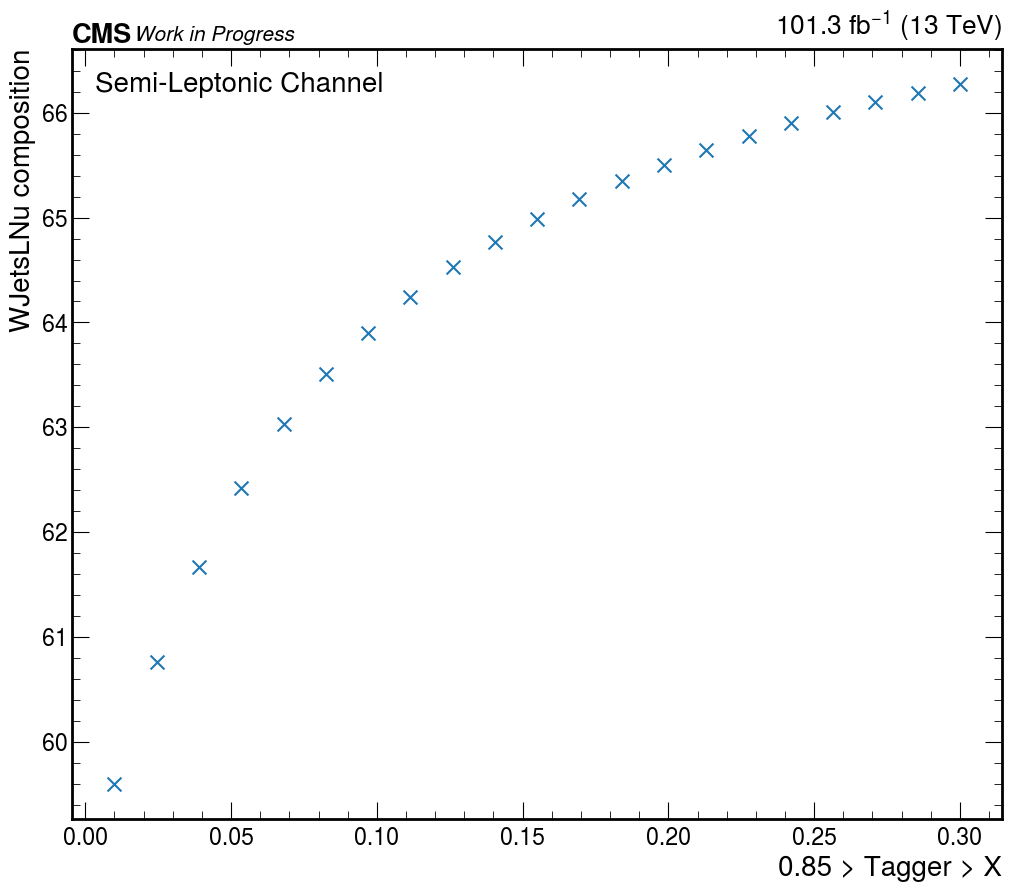

In [456]:
years = ["2018", "2017"]
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(tagger_cuts, ttt, marker="x", s=100)

# ax.axvline(0.85, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"WJetsLNu composition");
ax.set_xlabel(r"0.85 > Tagger > X")
# ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])

lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_W_region4.pdf")  

# Sculpting

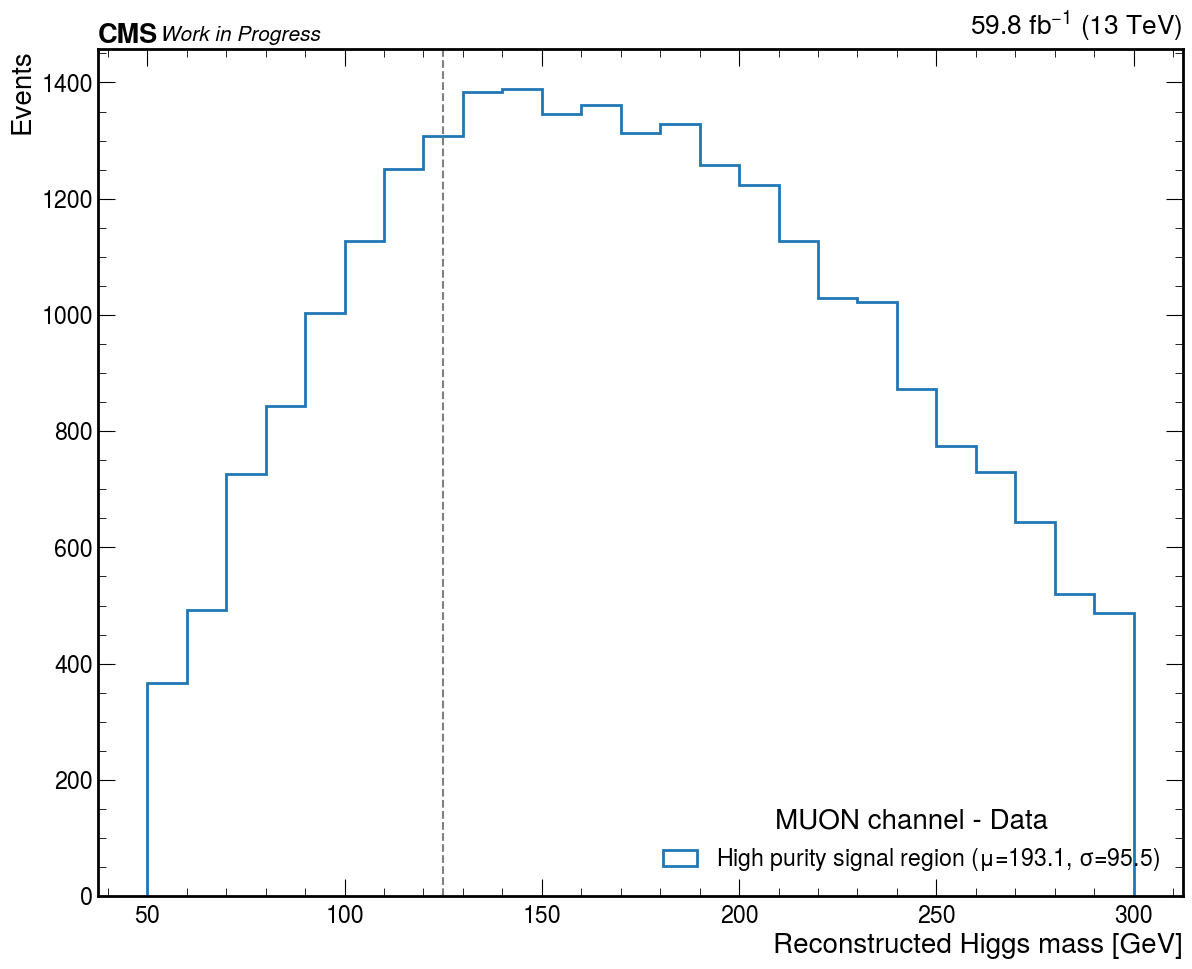

In [531]:
plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score_finetuned_v2_10_12"
tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  

#     "Top control region + dR>0.1": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.1)",
#     "Top control region + dR>0.2": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.2)",
#     "Top control region + dR>0.3": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.3)",
#     "Top control region + dR>0.4": f"({tagger}<0.9) & (n_bjets_T>0) & (lep_fj_dr>0.4)",
    
#     "WJets control region": f"({tagger}<0.80) & ({tagger}>0.20) & (n_bjets_L==0)",

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
    
#     "ParT-finetuned>0.97": f"(fj_ParT_score_finetuned_v2_nor2>0.97)",
#     "ParT>0.99": f"(fj_ParT_score>0.99)"
    
    
}

nice_ch = {
    "ele": "ELECTRON",
    "mu": "MUON",
}

sample = "Data"
channels = ["mu"]#, "ele"]
years = ["2018"]#, "2017"]

fig, ax = plt.subplots(figsize=(14, 11))
for k, v in presel.items():
    
    for year in years:

        if "QCD" in k:
            region="qcd_region"
        else:
            region="signal_region"

        df1 = events_dict[region][year]["mu"][sample]    
        df2 = events_dict[region][year]["ele"][sample]

        df = pd.concat([df1, df2])

        if len(years) > 1:
            df1 = events_dict[region][years[1]]["mu"][sample]    
            df2 = events_dict[region][years[1]]["ele"][sample]

            df11 = pd.concat([df1, df2])

            df = pd.concat([df, df11])
            break
            
    bins = 26

    df1 = df.copy().query(v)

    x = df1["rec_higgs_m"]
#     w = df1["event_weight"]

    ax.hist(
        x, 
        bins=np.linspace(50,300,bins), 
#         weights=w,
#         density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--")#, label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

In [514]:
all_files = glob.glob("ttt/*")
log_files = glob.glob("ttt/log*")

In [505]:
all_files

['ttt/t', 'ttt/log.txt', 'ttt/a.txt']

In [506]:
log_files

['ttt/log.txt']

# Data

In [803]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [804]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",    
    "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

categories_sel = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [200, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>200) & (fj_pt<450)",
    rf"ggF category ($p_T$ $\in$ [300, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>300)",
}

samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
# channels = ["mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1 (tagger>0.97 + nbjetsT==0)": 10,
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": 100,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():
                for category, category_sel in categories_sel.items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


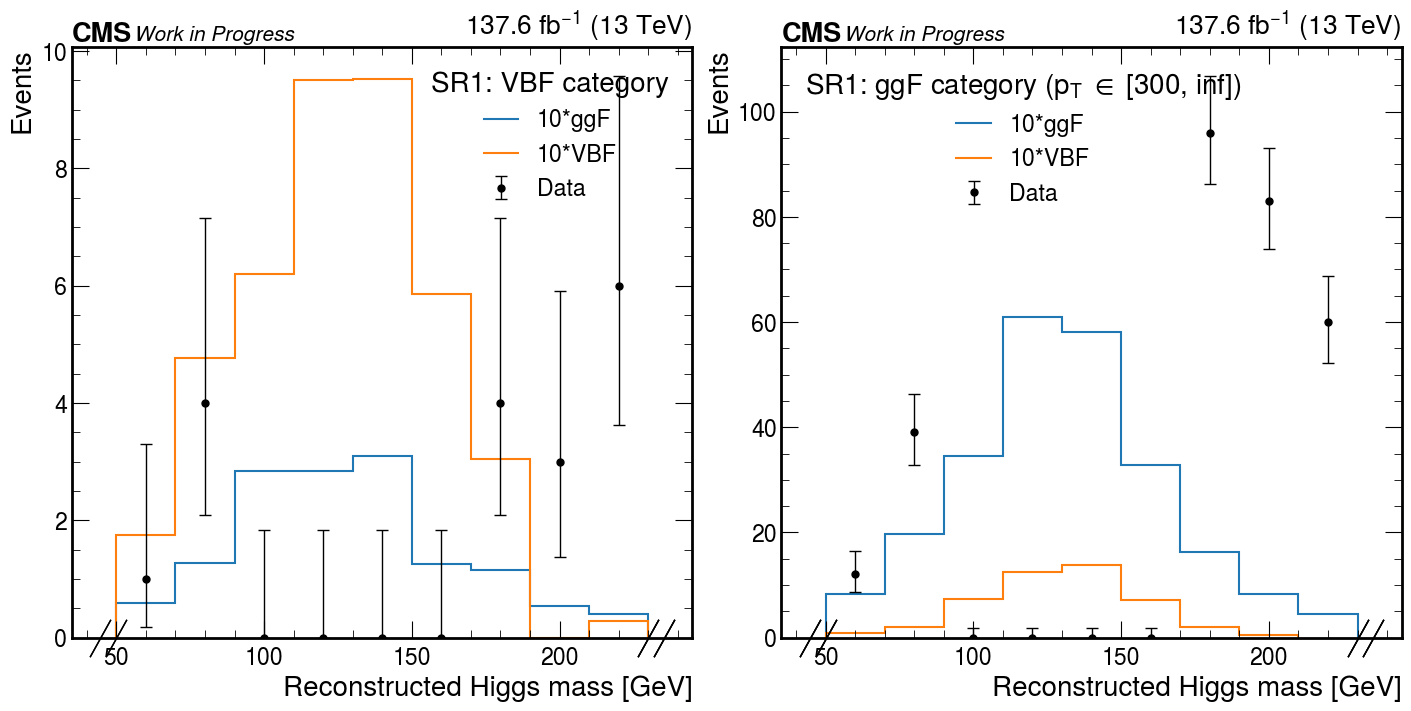

In [805]:
fig, axs = plt.subplots(1, 2, figsize=(14,7), constrained_layout=True)

region = list(regions_sel.items())[0][0]
for i, category in enumerate(categories_sel):
    for sample in samples:
        
        
        if sample == "Data":
            if blind:
                hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   
            
        else:
            if mult[region]==1:
                lab = sample            
            else:
                lab = f"{mult[region]}*{sample}"
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    
                

    axs[i].legend(title=f"SR1: {category}")
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
#     if i==2:
#         axs[i].set_yticks([0,4,8,12,16])
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/ww3.pdf")

In [1099]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",    
    "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",

    
#     "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

categories_sel = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
    rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
    rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
#     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        
}

samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1": 10,
    "SR2": 100,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():
                for category, category_sel in categories_sel.items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


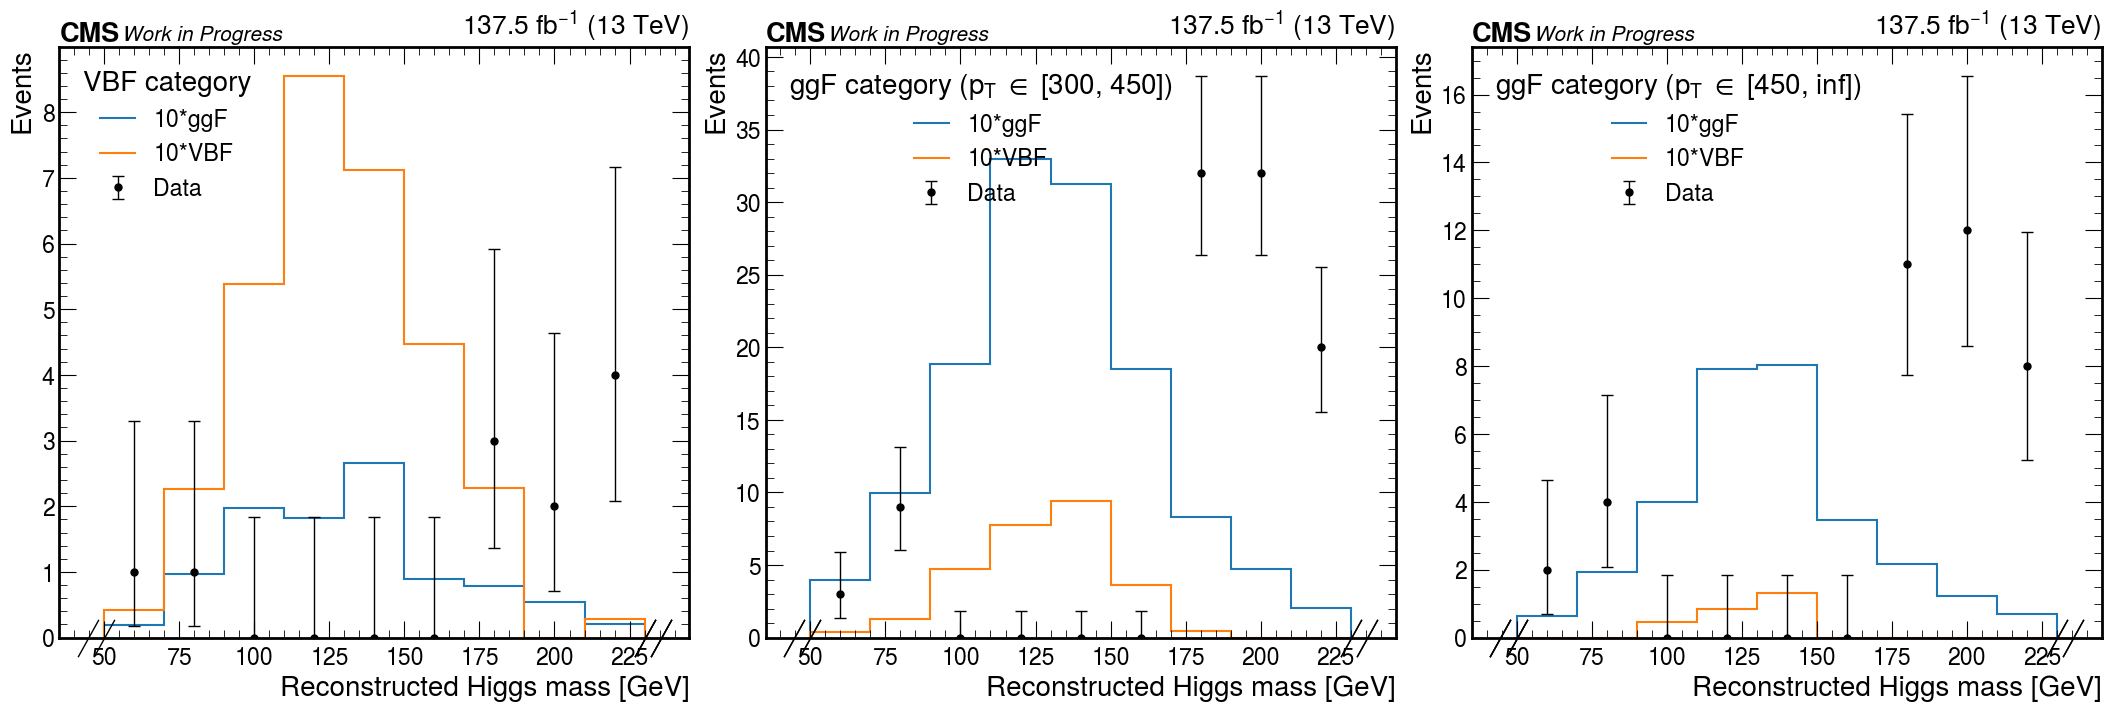

In [1100]:
fig, axs = plt.subplots(1, 3, figsize=(21,7), constrained_layout=True)

region = list(regions_sel.items())[0][0]
for i, category in enumerate(categories_sel):
    for sample in samples:
        
        
        if sample == "Data":
            if blind:
                hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   
            
        else:
            if mult[region]==1:
                lab = sample            
            else:
                lab = f"{mult[region]}*{sample}"
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    
            
    axs[i].legend(title=category)
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
#     if i==2:
#         axs[i].set_yticks([0,4,8,12,16])
plt.savefig(f"/Users/fmokhtar/Desktop/AN/ww2.pdf")

In [25]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",   
    
    "SR1": f"(n_bjets_T==0)",
    
#     "SR1": f" & (n_bjets_T==0)",
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",

    
#     "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

# categories_sel = {
#     "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
# #     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
# #     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
# #     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        
# }

categories_sel = {
    "SR1": {
        "VBF": f"({tagger}>0.97) & (mjj>1000) & (deta>3.5)",
        rf"ggF $p_T$ $\in$ [250, 300]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>250) & (fj_pt<300)",        
        rf"ggF $p_T$ $\in$ [300, 450]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
        rf"ggF $p_T$ $\in$ [450, Inf]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>450)",
    },
    
    "SR2": {
    rf"all inclusive": "(mjj<1000) & (deta<3.5)",
    }
}
#     "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
#     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        


samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1": 10,
    "SR2": 10,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():

                for category, category_sel in categories_sel[region].items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


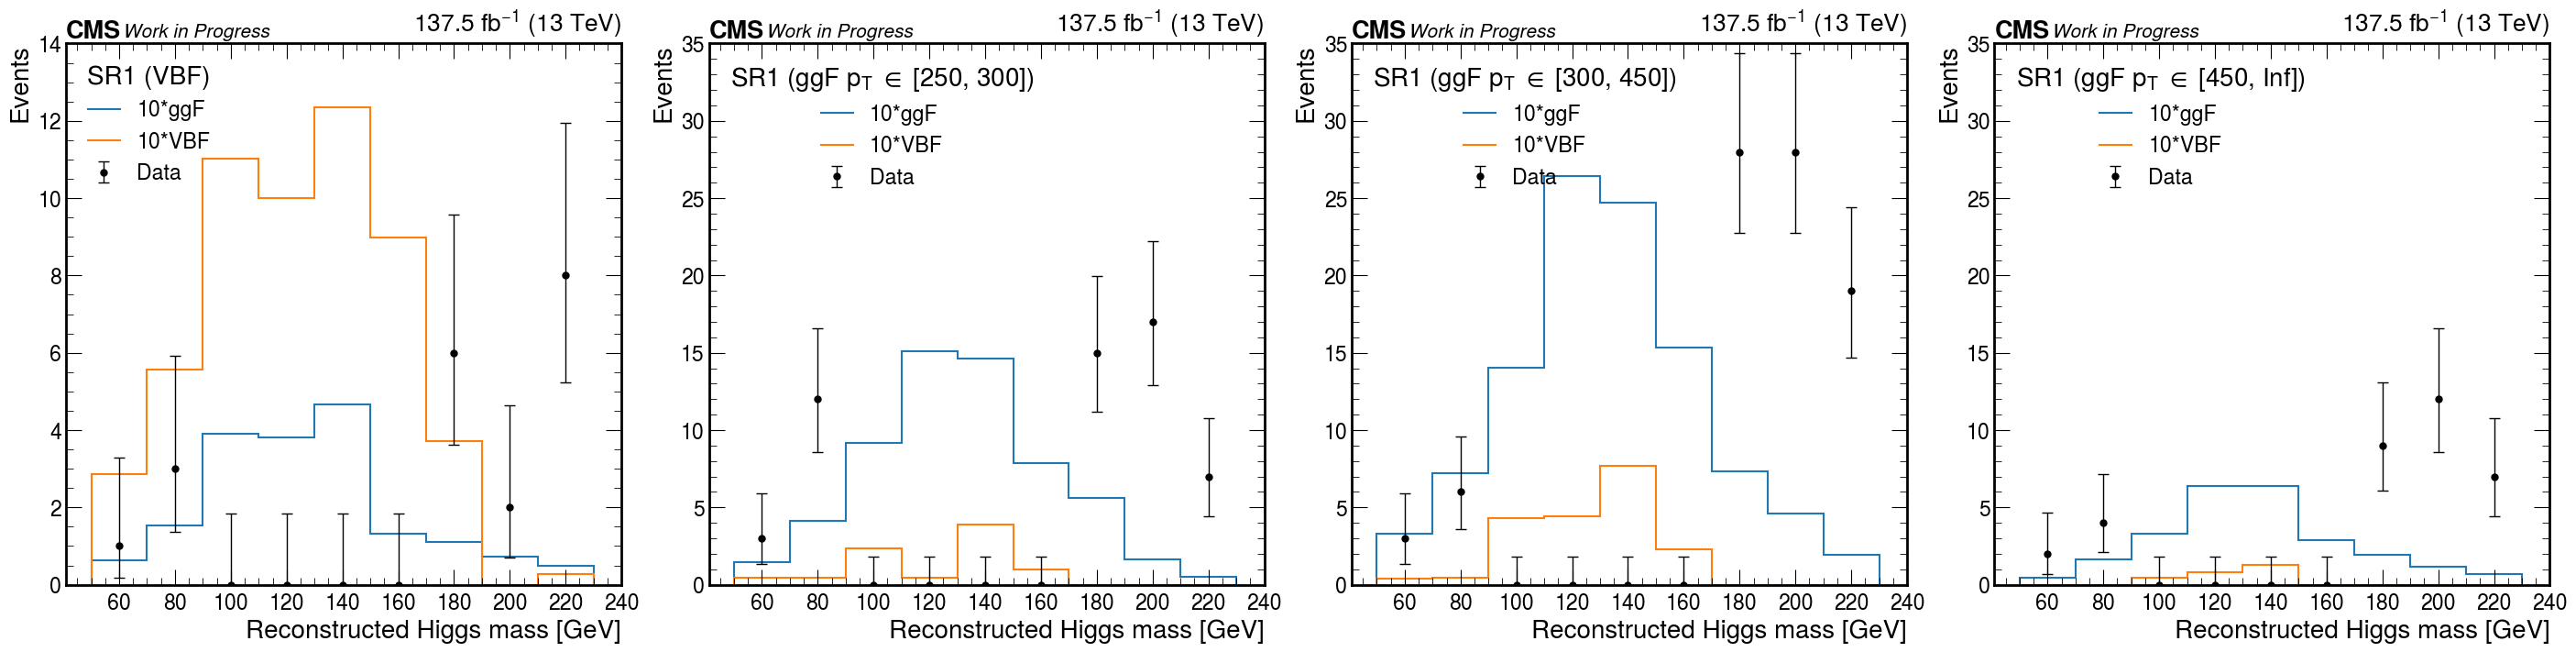

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(28,7), constrained_layout=True)

for region in regions_sel:
    for i, category in enumerate(categories_sel[region]):
        if region=="SR2":
            i=3
        for sample in samples:


            if sample == "Data":
                if blind:
                    hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])

                hep.histplot(
                    hists[{"samples": sample, "regions": region, "categories": category}],
                    ax=axs[i],
                    label=sample,
                    histtype="errorbar",
                    color="k",
                    capsize=4,   
                    flow="none"                    
                    
                )   

            else:
                if mult[region]==1:
                    lab = sample            
                else:
                    lab = f"{mult[region]}*{sample}"

                hep.histplot(
                    hists[{"samples": sample, "regions": region, "categories": category}],
                    ax=axs[i],
                    histtype="step",
                    label=lab,
                    flow="none"
                )    
#         if i==3:
#             axs[i].legend(title=f"{region}", loc="upper left")
#         else:
#             axs[i].legend(title=f"{region} ({category})", loc="upper left")

        axs[i].legend(title=f"{region} ({category})", loc="upper left")                

            
        if i==0:
            axs[i].set_ylim(0,14)
        if i==1:
            axs[i].set_ylim(0,35)
        if i==2:
            axs[i].set_ylim(0,35)            
        if i==3:
            axs[i].set_ylim(0,35)
            
            
        axs[i].set_ylabel(f"Events")
        axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
        axs[i].set_ylim(0)    
        hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
        hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
        
        axs[i].set_xticks(np.array(list(range(50, 240, 20))) + 10)
    plt.savefig(f"/Users/fmokhtar/Desktop/AN/ww2.pdf")

# QCD

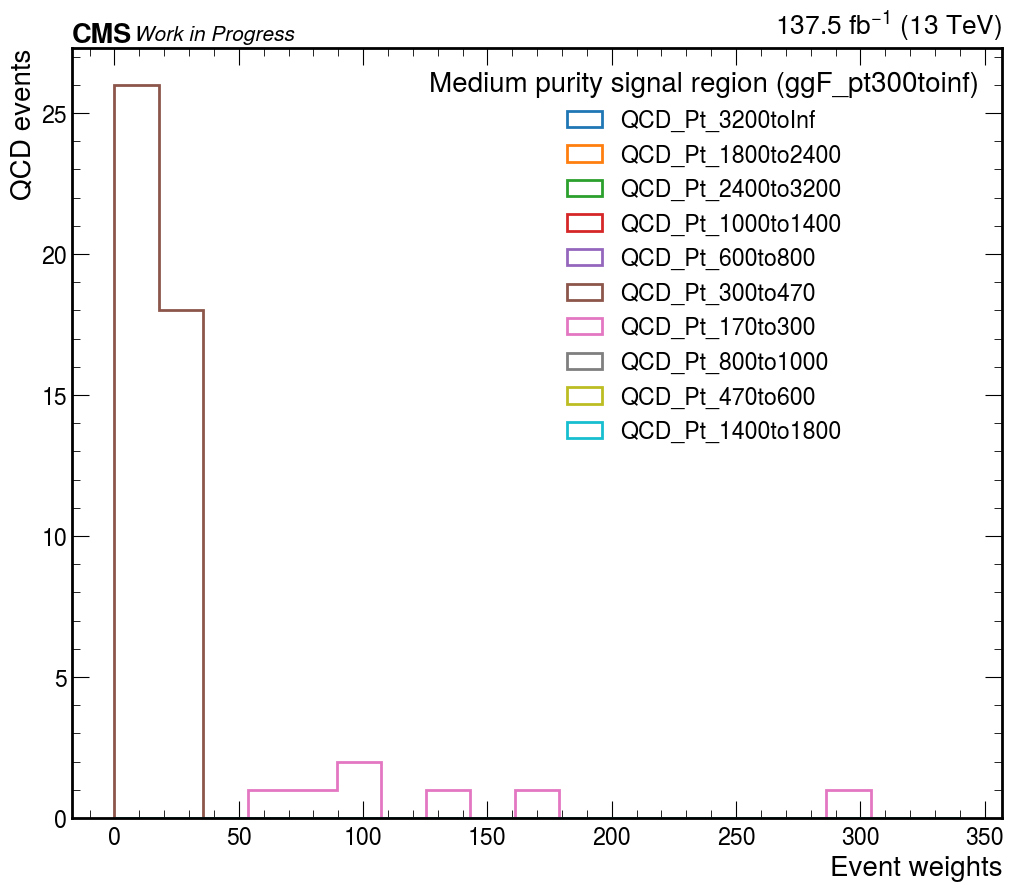

In [573]:
################### option 1
plt.rcParams.update({"font.size": 20})
nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

region_sel = {
#     "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
}
categories_sel = {
#     "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
#     "ggF_pt200to300": "( (mjj<1000) & (deta<3.5) & (fj_pt<300) )",
    "ggF_pt300toinf": "( (mjj<1000) & (deta<3.5) & (fj_pt>300) )",
    
}
blind = True
blind_region = (80, 160)
mult = 10

years = ["2018", "2017", "2016APV", "2016"]
sample="QCD"

fig, ax = plt.subplots(figsize=(12,10))    

ws = {}

for sample in events_dict2["signal_region"]["2017"][ch]:
    ws[sample] = []
    for year in years:
        for ch in ["ele", "mu"]:
            try:
                df = events_dict2["signal_region"][year][ch][sample]
            except:
                continue

            for region, sel in region_sel.items():
                df = df.query(sel)

            for category, category_sel in categories_sel.items():
                df = df.query(category_sel)

            w = df[f"event_weight"]
            ws[sample] += w.tolist() 
    
    ws[sample] = np.array(ws[sample])
    ws[sample] = ws[sample][ws[sample]>10]

    bins = 20
    ax.hist(
        ws[sample],
        bins=np.linspace(0,340,bins), 
        histtype="step", 
        linewidth=2, 
        label=sample
    )
#     break

lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0

ax.legend(title=f"{region} ({category})", loc="upper right")

ax.set_ylabel(f"QCD events")
ax.set_xlabel(f"Event weights")  
ax.set_ylim(0)

hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/WWW_QCD_weights_medium_{category}.pdf")        

In [441]:
def plot_ratio(h, years, region1 = "Medium_signal_region", region2 = "QCD_region", sample="QCD", category="VBF", tag=""):
    
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10, 10),
        gridspec_kw={"height_ratios": (4, 2), "hspace": 0.07},
        sharex=True,
    )

    hep.histplot(
        h[{"region": region1, "categories": category}],
        ax=ax,
#         histtype="step",
        histtype="errorbar",        
        label=region1,
        density=True
    )
    hep.histplot(
        h[{"region": region2, "categories": category}],
        ax=ax,
        histtype="step",
        label=region2,
        density=True    
    )

    from hist.intervals import ratio_uncertainty

    data_val = h[{"region": region1, "categories": category}].values()
    tot_val = h[{"region": region2, "categories": category}].values()
    yerr = ratio_uncertainty(data_val, tot_val, "poisson")
    

    data_val /= data_val.sum()
    tot_val /= tot_val.sum()

    print(tot_err_MC)
    hep.histplot(
        data_val / tot_val,
        h[{"region": region1, "categories": category}].axes.edges[0],
        yerr=yerr,
        ax=rax,
        histtype="step",
        color="k",
#         capsize=4,
    )
    
    
    
    
    
    ax.set_xlabel("")
    rax.set_xlabel(f"{h.axes[-1].label}")  # assumes the variable to be plotted is at the last axis

    rax.set_ylabel("Ratio", fontsize=20, loc="center")

    
#     rax.set_ylim(0, 0.004)
#     rax.set_yticks([0, 0.4, 1, 1.4])
    
    rax.axhline(1, ls="--", color="k")    
#     rax.set_ylim(0, 2.5)
#     rax.set_yticks([0, 0.4, 1, 1.4])

    ax.legend(title=category)
    
    lum_ = 0
    for year in years:
        lum = 0
        for ch in ["ele", "mu"]:
            with open("../fileset/luminosity.json") as f:
                lum += json.load(f)[ch][year] / 1000.0

        lum_ += lum / len(channels)

    hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)

    hep.cms.text("Work in Progress", ax=ax, fontsize=15)
    
    
    ax.set_ylabel(f"Normalized {sample} events")
    
    if tag:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku3/ratio_{sample}_{tag}.pdf")        
    else:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku3/ratio_{sample}.pdf")   

In [442]:
tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
    "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",
    "0.85>Tagger>0.20": f"({tagger}<0.85) & ({tagger}>0.20)",

#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
    
#     "Top control region": f"({tagger}<0.20) & (n_bjets_T>0)",  
    "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  

}

categories_sel = {
    "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
    "ggF_pt200to300": "( (mjj<1000) & (deta<3.5) & (fj_pt<300) )",
    "ggF_pt300toinf": "( (mjj<1000) & (deta<3.5) & (fj_pt>300) )",
    
}
            
channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

sample = "QCD"

# fill histograms
hists = {}
for var in vars_to_plot:
            
    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            hist2.axis.StrCategory([], name="categories", growth=True),            
            hist2.axis.Variable(
                list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
            )
        )
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            utils.axis_dict[var],
        )
        
    for year in years:
        for ch in channels:
                
            for region, region_sel in presel.items():
                for category, category_sel in categories_sel.items():
                
                    if "QCD control region" in region:
                        df = events_dict["qcd_region"][year][ch][sample]
                    else:
                        df = events_dict["signal_region"][year][ch][sample]

                    if "High" in region:
                        if sample == "QCD":
                            df = df[df["event_weight"]<140]
                    elif "Medium" in region:
                        if sample == "QCD":
                            df = df[df["event_weight"]<200]

                    df = df.query(region_sel)
                    df = df.query(category_sel)

                    hists[var].fill(
                        region=region,
                        categories=category,
                        mass_observable=df[var],
                        weight=df["event_weight"],
                    )     

KeyError: 'signal_region'

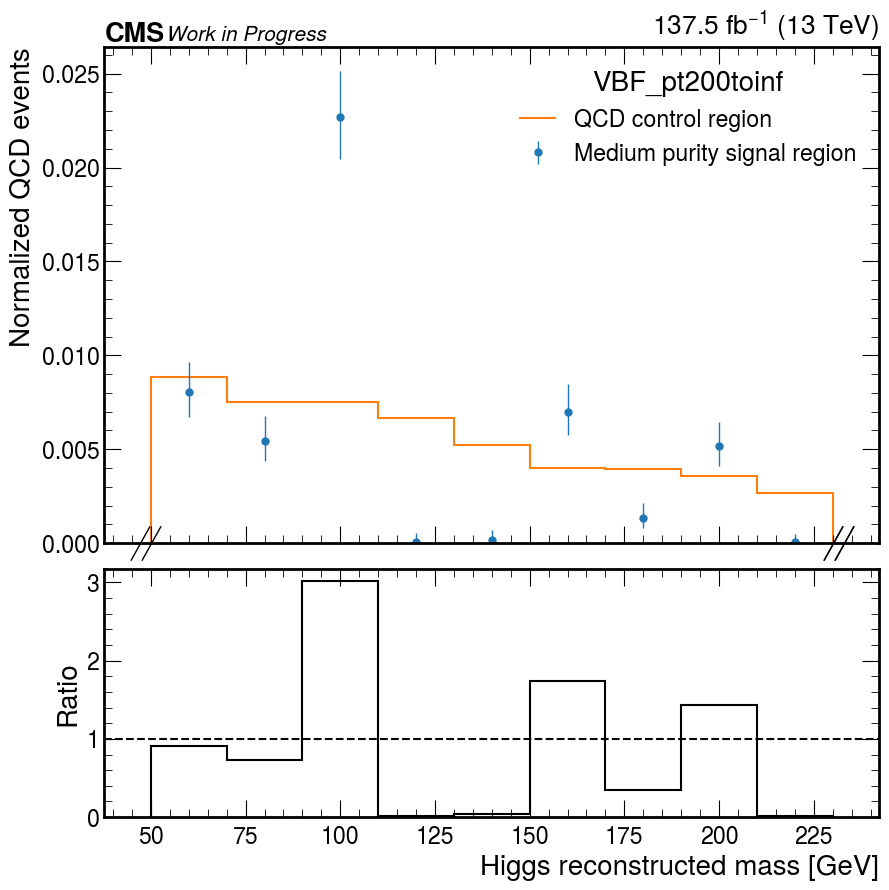

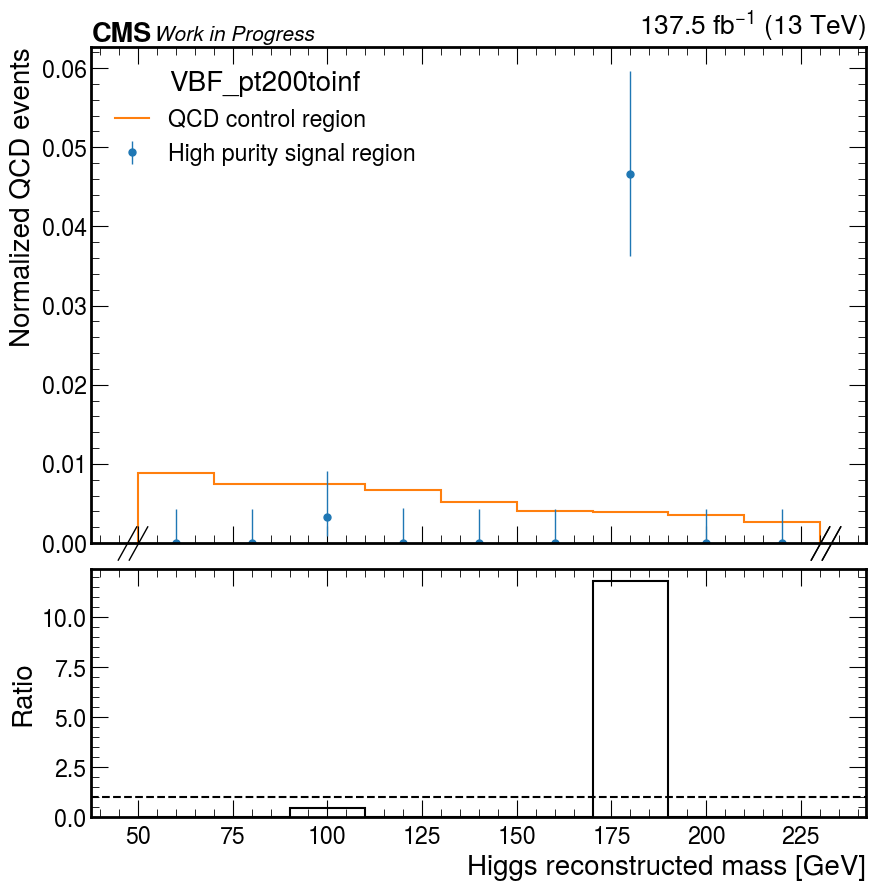

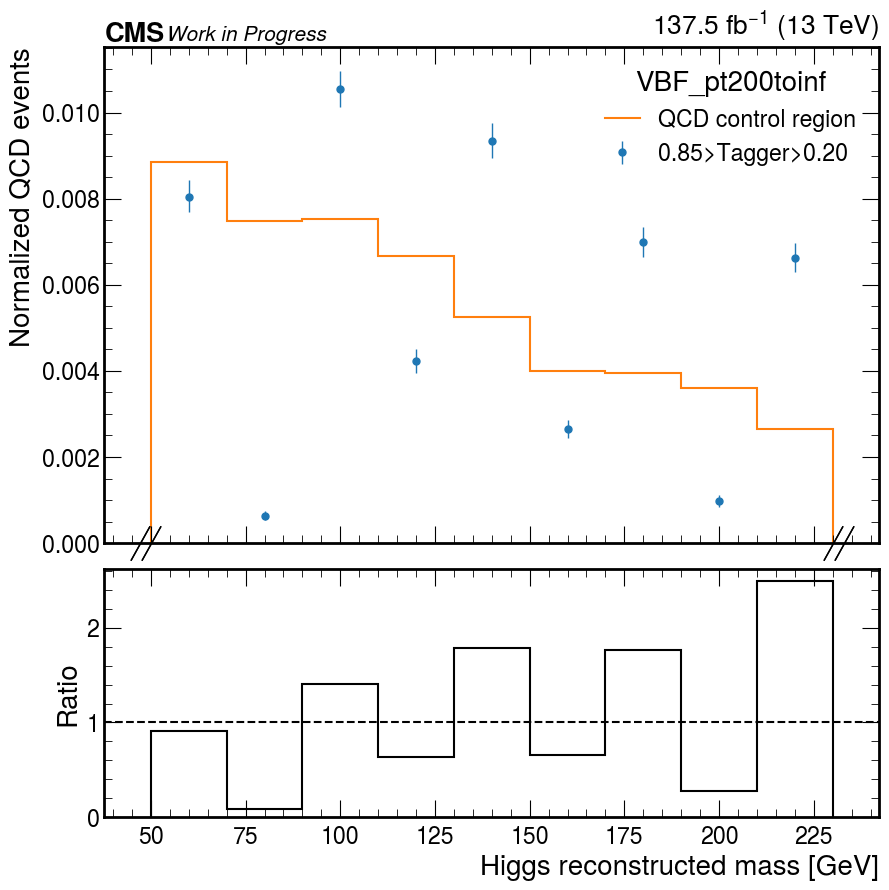

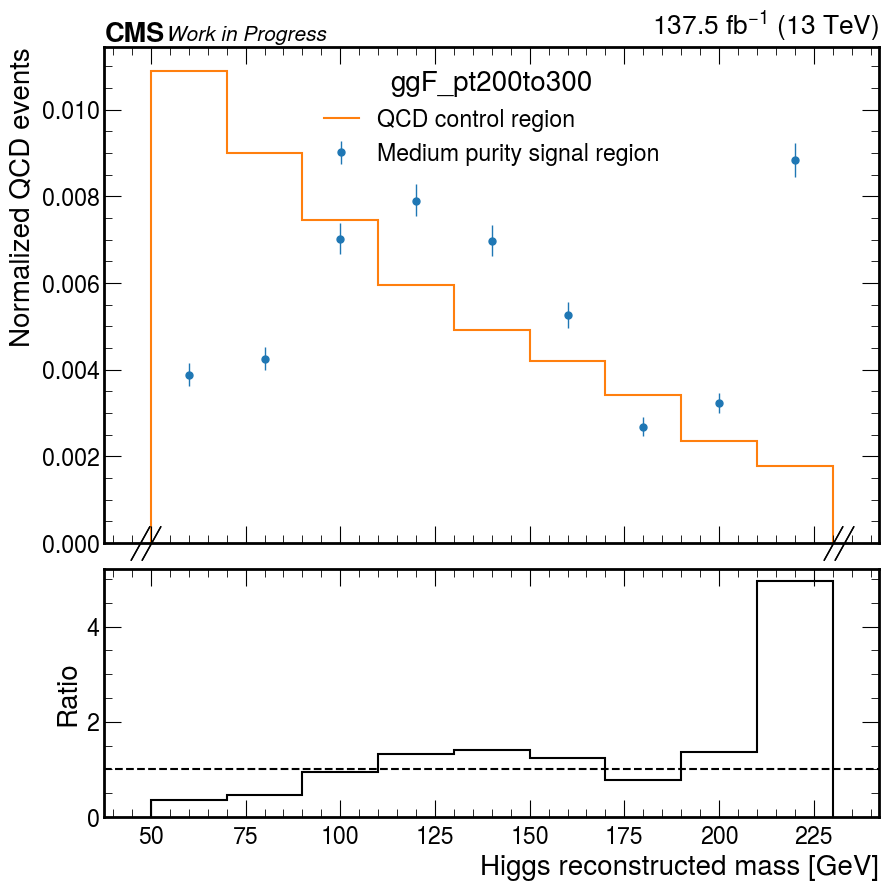

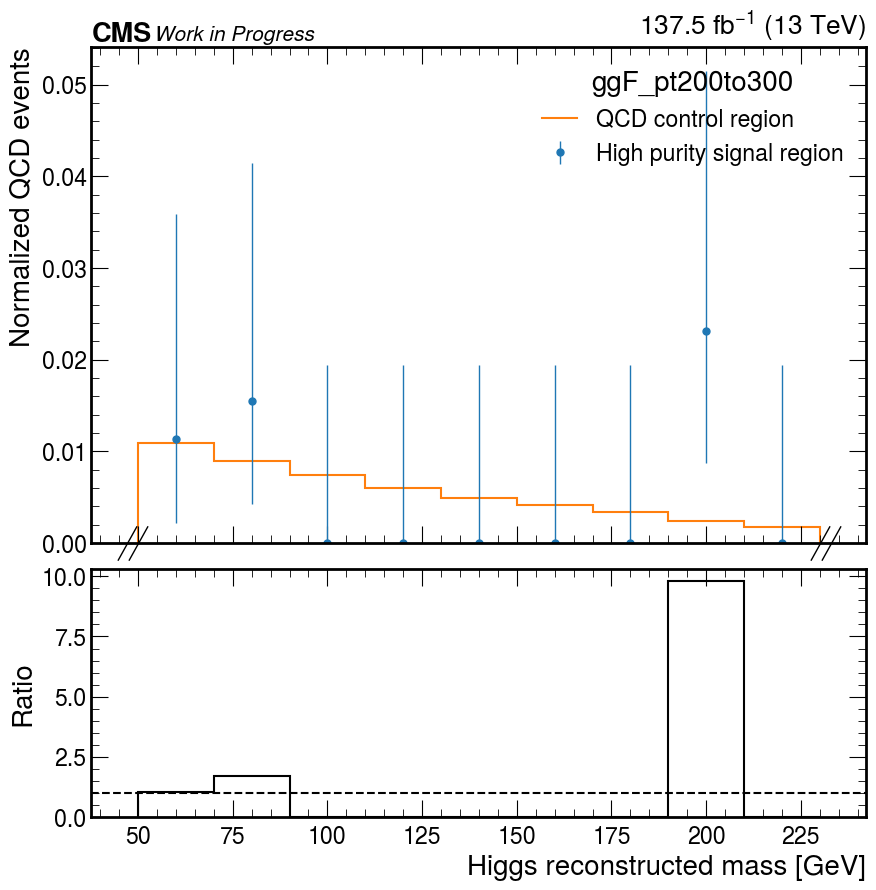

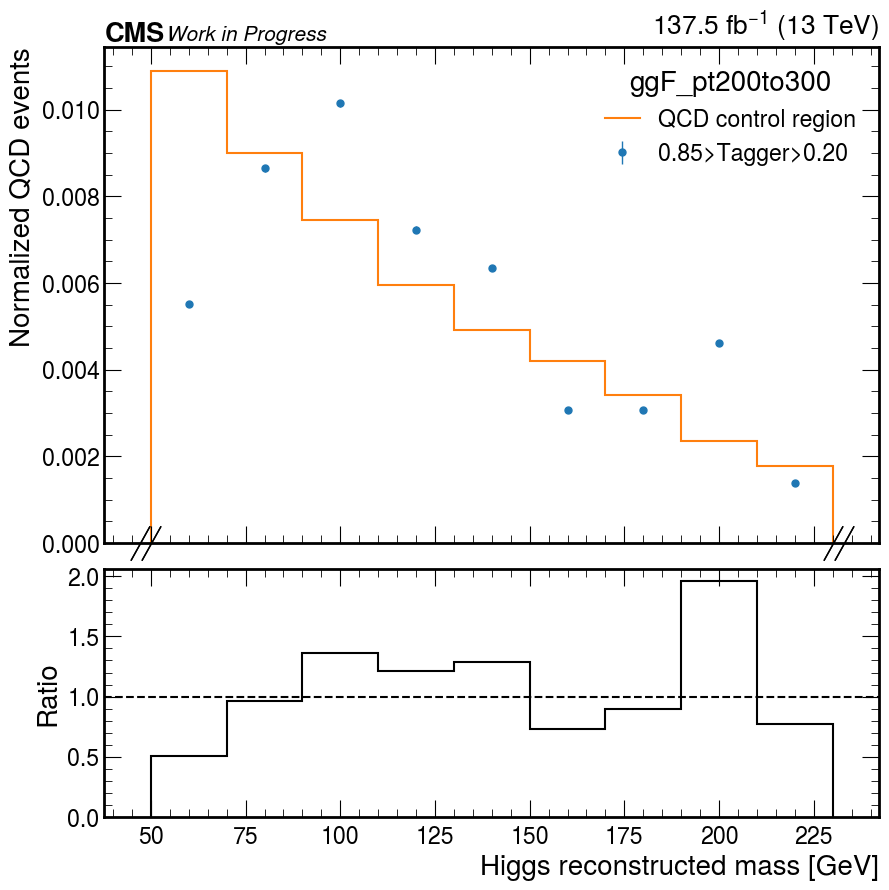

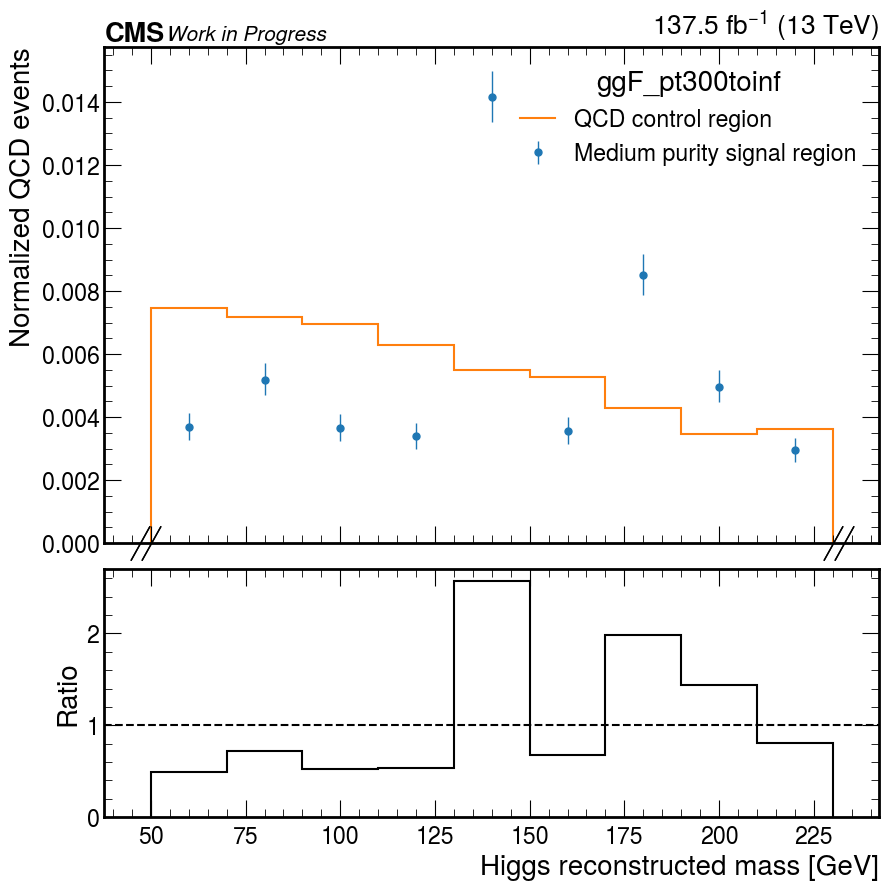

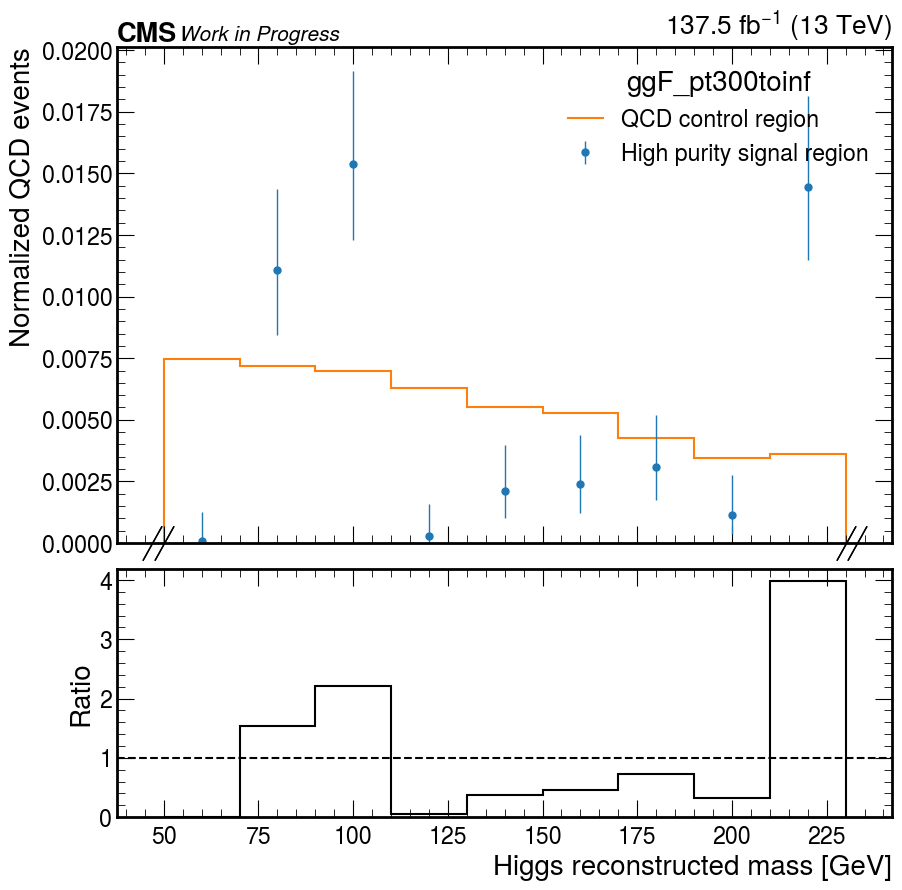

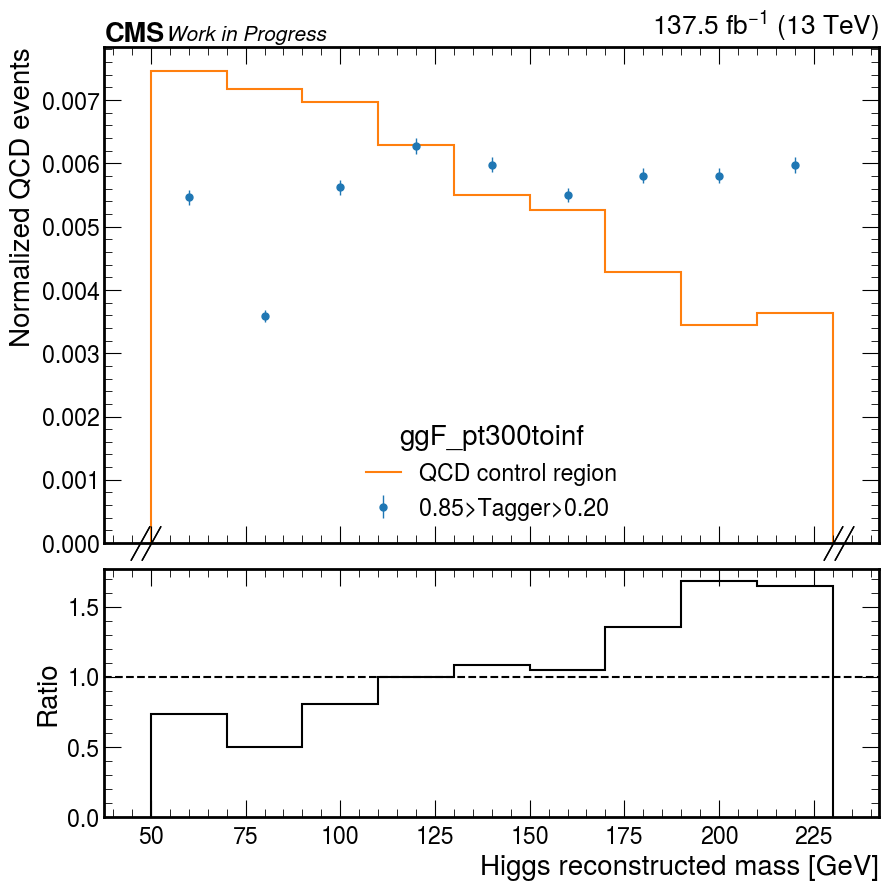

In [754]:
region_dic = {
    "Medium purity signal region": "medium",
    "High purity signal region": "high",
    "0.85>Tagger>0.20": "low",    
}

for category in ["VBF_pt200toinf", "ggF_pt200to300", "ggF_pt300toinf"]:
    
    for region in region_dic:
        plot_ratio(hists["rec_higgs_m"], 
                   years, 
                   region1 = region,
                   region2 = "QCD control region",
                   sample=sample,
                   category=category,
                   tag=f"{category}_{region_dic[region]}"
                  )

In [ ]:
fig, ax = plt.subplots(figsize=(14, 11))
ax.hist(
    x, 
    bins=np.linspace(50,300,bins), 
    weights=w,
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
)

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

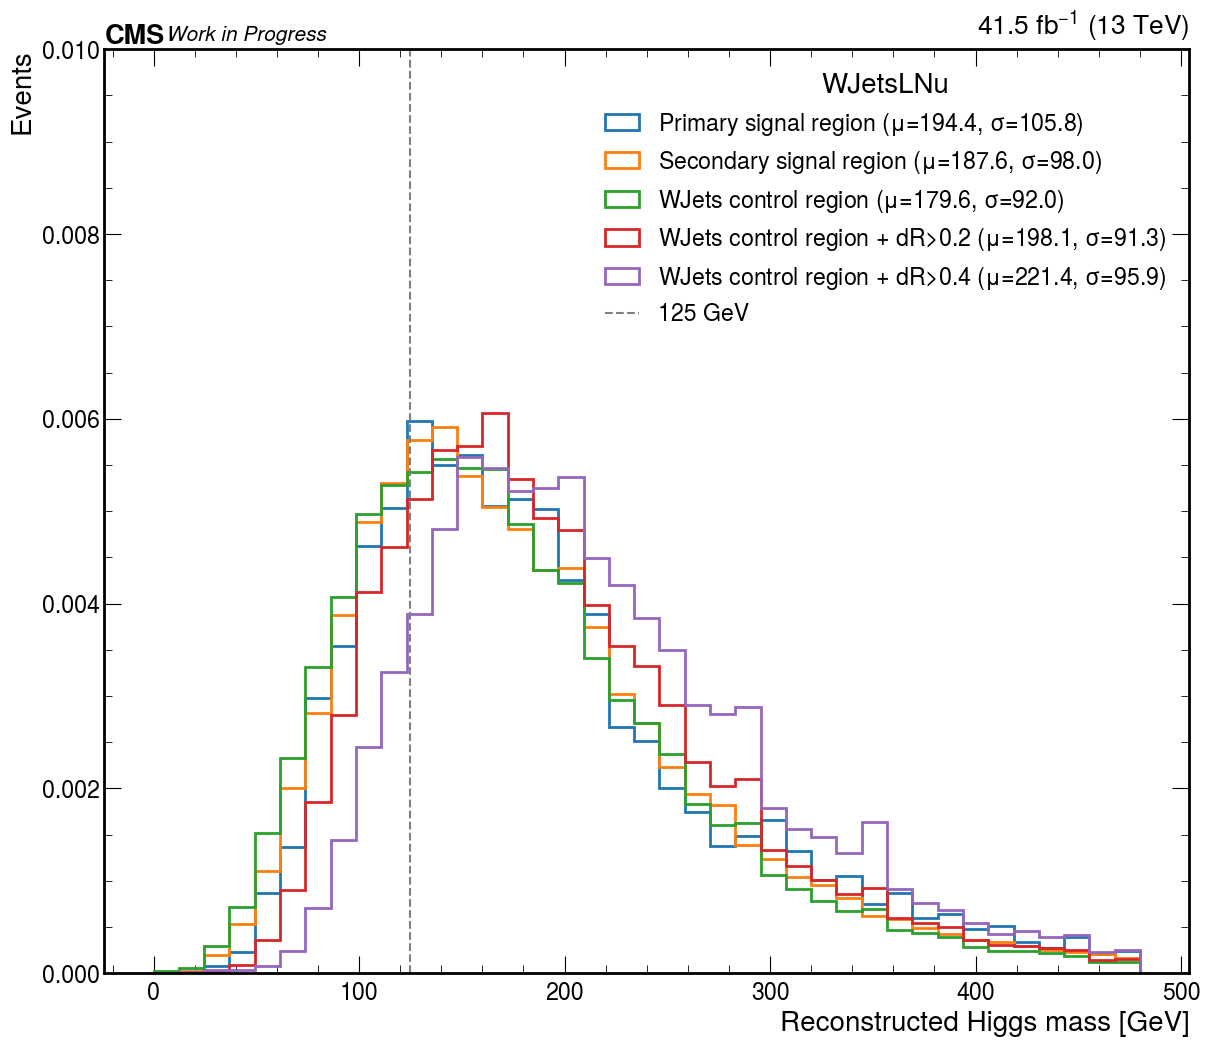

In [140]:
fig, ax = plt.subplots(figsize=(14, 12))
for region, sel in presel.items():

    df1 = df.copy().query(sel)

    x = df1["rec_higgs_m"]
    ax.hist(
        x, 
        bins=np.linspace(0,480,bins), 
        weights=df1["weight"],
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{region} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0, 0.01)

luminosity = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    luminosity += lum / len(channels)    
        
hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakiko/{sample}.pdf")  